📌 Projeto: Transformação CRS → DGGS com Redes Neurais (MLP)

Este projeto aplica redes neurais artificiais (MLPs) para transformar coordenadas geográficas (latitude, longitude) em índices de células de Sistemas de Grade Global Discreta (DGGS), com aplicação no mapeamento de imagens para Cubos de Dados geoespaciais.

## 1. Descrição do Projeto

### 1.1 🎯 Objetivo Geral

Desenvolver e avaliar redes neurais do tipo MLP que realizam a transformação entre um par de coordenadas geográficas (em diferentes sistemas de referência - CRS) e um índice de célula de um DGGS (como H3 ou rHEALPix), em um nível de resolução determinado.

### 1.2 🧠 Treinamento dos Modelos MLP

Serão treinados quatro modelos distintos:
* MLP 1: WGS84 → H3
* MLP 2: Córrego Alegre → H3
* MLP 3: WGS84 → rHEALPix
* MLP 4: Córrego Alegre → rHEALPix

Cada modelo receberá como entrada:
* Coordenadas geográficas tratadas (com Fourier Features)
* Resolução desejada no DGGS alvo

A saída será:
* Índice da célula no DGGS correspondente.

### 1.3 🛰️ Aplicação: Mapeamento de Imagens para Cubo de Dados DGGS

O pipeline completo funciona da seguinte forma:

1. Extração de Metadados da Imagem
* Coleta dos vértices geográficos (bounding box) e da resolução espacial (tamanho do pixel).

2. Determinação do Nível de Resolução DGGS
* Conversão da resolução espacial da imagem para o nível de resolução mais próximo no DGGS.

3. Mapeamento com a MLP
* Geração de uma grade de amostragem sobre a área da imagem.
* Cada ponto é passado como entrada para a MLP, que retorna o índice da célula DGGS.

4. Construção da Imagem DGGS
* Os valores dos pixels são agregados por célula DGGS (ex: média ou valor dominante).

5. Visualização
* A imagem resultante no DGGS pode ser visualizada em mapas ou renderizações hexagonais.

### 1.4 🧪 Experimento para Avaliação das MLPs

**Objetivo do Experimento**

Avaliar o desempenho das MLPs com base em diferentes fatores que afetam a conversão coordenada → índice DGGS.

**Fase Preliminar: Ajuste de Hiperparâmetros**

Antes dos experimentos principais, será conduzida uma fase de ajuste de hiperparâmetros para cada um dos quatro modelos. O objetivo é obter configurações robustas que maximizem o desempenho de cada MLP.

Hiperparâmetros a serem ajustados:
* Número de camadas ocultas
* Número de neurônios por camada
* Funções de ativação
* Otimizador (ex: Adam, SGD)
* Taxa de aprendizado (e uso de scheduler)
* Tamanho do lote (batch size)
* Técnicas de regularização (Dropout, L2)

Metodologia de Ajuste:
* Dados: Um subconjunto representativo dos dados de entrada será utilizado para validação.
* Busca: Random Search, Otimização Bayesiana ou AutoML (ex: Optuna, KerasTuner).
* Métrica de avaliação: Percentual de acerto no conjunto de validação ou erro geodésico médio.
* Resultado: A melhor configuração será documentada e usada nos experimentos principais.

**Métricas de Avaliação**
* Acurácia: Percentual de acertos (índice previsto = índice real)
*  Erro Geodésico Médio: Distância entre centroides das células prevista e real (caso de erro)

**Desenho Experimental**
* Blocos:
     * CRS de origem (WGS84 ou Córrego Alegre)
* Fatores:
     * Faixas de Latitude (ex: equatorial, média latitude, polar)
     * Volume de Dados de Treinamento (ex: 10 mil a 1 milhão de amostras)
* Análise Estatística:
     * Teste de ANOVA para avaliar significância dos efeitos e interações
     * Avaliação dos resíduos por meio de gráficos
     * Teste de Tukey se for significante

**Considerações Adicionais**
* A capacidade de generalização das MLPs será testada com imagens de diferentes resoluções espaciais.
* A robustez dos modelos será avaliada em relação ao nível de resolução DGGS fornecido como entrada.
* A análise incluirá o impacto do volume de dados e da localização geográfica.

### 1.5 ⚙️ Organização do Código

O projeto está dividido em três partes principais:

**Parte 1: Treinamento dos Modelos MLP**
* Geração de dados sintéticos
* Ajuste de hiperparâmetros
* Treinamento e validação do modelo
* Registro de métricas

**Parte 2: Aplicação no Pipeline de Imagem**
* Entrada: metadados da imagem (bounding box e resolução)
* Aplicação da MLP para prever índices DGGS
* Agregação dos valores
* Geração da imagem DGGS

**Parte 3: Execução do Experimento**
* Variação de faixas latitudinais e volumes de dados
* Coleta de métricas para cada condição
* Análise estatística dos resultados

### 1.6 📎 Observações

A arquitetura da MLP será mantida simples e padronizada para todos os modelos.

A inferência retorna o índice em formato de numérico de inteiro (que pode ser convertido em string H3/rHEALPix para visualização).

O projeto é modular: cada parte pode ser rodada separadamente e estendida.

### 1.7 📦 Importações de Pacotes

In [1]:
# !pip install pyproj h3 rhealpixdggs numpy optuna tensorflow scikit-learn -q

### 1.8 🤝 Funções Auxiliares

⌚ Decorator para Medir Tempo de Execução

In [1]:
import time
from functools import wraps
from datetime import datetime

def log_time(label="[INFO]"):
    """
    Decorator que registra no console o início, o fim e o tempo total
    de execução de uma função. Agora inclui o carimbo de data e hora do início.
    """
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            start_timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            print(f"{label} Starting: {func.__name__} at {start_timestamp}")
            start = time.time()
            result = func(*args, **kwargs)
            elapsed = time.time() - start
            print(f"{label} Completed {func.__name__} in {elapsed:.2f} seconds")
            return result
        return wrapper
    return decorator

In [2]:
import logging

# Configuração básica do logging no início do seu script principal
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def log_time_v2(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        logging.info(f"Starting: {func.__name__}")
        start = time.time()
        result = func(*args, **kwargs)
        elapsed = time.time() - start
        logging.info(f"Completed {func.__name__} in {elapsed:.2f} seconds")
        return result
    return wrapper

## 2. Treinamento dos Modelos MLP

### 2.1 Geração de dados sintéticos

#### 📦 Classe do Dataset por DGGS

In [3]:
class FragmentDataset:
    def __init__(self, n_freqs=10, crs='WGS84'):
        self.data = {
            'H3': [],
            'RHEALPIX': []
        }
        self.n_freqs = n_freqs
        self.X_data = {}
        self.y_data = {}
        self.crs = crs

    def _fourier_axis(self, value):
        """
        Vetoriza Fourier Features por eixo (suporta escalar ou array).
        Retorna shape (n, 2*n_freqs)
        """
        value = np.atleast_1d(np.radians(value))  # shape (n,)
        k = np.arange(1, self.n_freqs + 1)  # shape (f,)
        sin = np.sin(np.outer(value, k))   # shape (n, f)
        cos = np.cos(np.outer(value, k))   # shape (n, f)
        return np.hstack([sin, cos])       # shape (n, 2f)

    def add(self, dggs_type, coord, vector, resolution, base, digits, ff_lat=None, ff_lon=None):
        """
        Armazena um único registro de dados.
        As features de Fourier podem ser pré-calculadas e fornecidas para maior eficiência.
        """
        lat, lon = coord
    
        # Calcula as features de Fourier SOMENTE se não forem fornecidas
        if ff_lat is None:
            ff_lat = self._fourier_axis(lat)
        if ff_lon is None:
            ff_lon = self._fourier_axis(lon)
    
        self.data[dggs_type.upper()].append({
            'coord': coord,
            'vector': vector,
            'resolution': resolution,
            'ff_lat': ff_lat,  # Usa a feature (pré-calculada ou calculada agora)
            'ff_lon': ff_lon,  # Usa a feature (pré-calculada ou calculada agora)
            'base': base,
            'digits': digits
        })

    def __len__(self):
        return sum(len(v) for v in self.data.values())

    @log_time_v2
    def build_X_y(self, dggs_type):
        """
        Constrói as matrizes X e y para um DGGS específico.
        X: concatenação de ff_lat + ff_lon + [resolução]
        y: dicionário com base e dígitos hierárquicos
        """
        dggs_type = dggs_type.upper()
        entries = self.data[dggs_type]
        X_list = []

        y = {'base': []}
        max_res = max(entry['resolution'] for entry in entries)
        for i in range(1, max_res + 1):
            y[f'digit_{i}'] = []

        for entry in entries:
            res = entry['resolution']
            ff_lat = entry['ff_lat']
            ff_lon = entry['ff_lon']
            x_vec = np.concatenate([ff_lat.flatten(), 
                                    ff_lon.flatten(), 
                                    [res / 15.0]]) # Normalização da resolução
            X_list.append(x_vec)

            y['base'].append(entry['base'])
            for i in range(1, max_res + 1):
                digit = entry['digits'][i - 1] if i <= len(entry['digits']) else 0
                y[f'digit_{i}'].append(digit)

        # Armazena internamente
        self.X_data[dggs_type] = np.array(X_list, dtype=np.float32)
        for k in y:
            y[k] = np.array(y[k], dtype=np.int64)
        self.y_data[dggs_type] = y

        return self.X_data[dggs_type], self.y_data[dggs_type]

    def get_X_y(self, dggs_type):
        """
        Retorna X e y armazenados ou constrói se necessário.
        """
        dggs_type = dggs_type.upper()
        if dggs_type not in self.X_data:
            return self.build_X_y(dggs_type)
        return self.X_data[dggs_type], self.y_data[dggs_type]

#### 🔁 Transformações de Coordenadas

In [4]:
from pyproj import Transformer

# Projeção geográfica para deslocamento métrico (centroide -> deslocamento em metros)
def displace_latlon(lat, lon, dx, dy):
    """
    Desloca uma coordenada geográfica (lat, lon) por dx, dy em metros usando UTM local.
    """
    # Determina fuso UTM local com base na longitude
    utm_zone = int((lon + 180) / 6) + 1
    is_northern = lat >= 0
    proj_string = f"+proj=utm +zone={utm_zone} +{'north' if is_northern else 'south'} +datum=WGS84 +units=m +no_defs"

    # Projeções: geográfica -> UTM e UTM -> geográfica
    transformer_fwd = Transformer.from_crs("EPSG:4326", proj_string, always_xy=True)
    transformer_inv = Transformer.from_crs(proj_string, "EPSG:4326", always_xy=True)

    x0, y0 = transformer_fwd.transform(lon, lat)
    x1, y1 = x0 + dx, y0 + dy
    lon_disp, lat_disp = transformer_inv.transform(x1, y1)

    return lat_disp, lon_disp

#### 🌐 Conversão para Índices DGGS

In [5]:
import h3
from rhealpixdggs import dggs
import numpy as np
from pyproj import Transformer

# WGS84 Geográfico (padrão)
CRS_WGS84 = "EPSG:4326"

# Córrego Alegre Geográfico e com parâmetros de transformação GLOBAL para WGS84
CRS_CORREGO_ALEGRE_GEOG = "EPSG:4225"
CRS_CORREGO_ALEGRE = "+proj=longlat +ellps=intl +towgs84=-205.57,168.77,-4.12,0,0,0,0 +no_defs"

# Cache global de transformers por zona UTM e hemisfério
_transformer_cache = {}

def get_cached_transformer(from_crs, to_crs):
    """
    Função centralizada para obter qualquer transformer do cache.
    Usa um dicionário global para evitar recriar transformers.
    """
    key = (str(from_crs), str(to_crs)) # Usa string para garantir que a chave seja hasheável
    if key not in _transformer_cache:
        _transformer_cache[key] = Transformer.from_crs(from_crs, to_crs, always_xy=True)
    return _transformer_cache[key]

def displace_latlon_batch(lat, lon, dx_array, dy_array, crs='WGS84'):
    """
    Aplica deslocamentos dx/dy (em metros) à coordenada (lat, lon), retornando arrays (lat[], lon[]).
    """
    # Determinar o CRS geográfico de origem com base na string de entrada
    if crs.upper() == 'WGS84':
        source_crs_geog = CRS_WGS84
        # Para WGS84, o elipsoide é o WGS84
        utm_datum_string = "+datum=WGS84" 
    elif crs.upper() == 'CÓRREGO ALEGRE':
        source_crs_geog = CRS_CORREGO_ALEGRE_GEOG
        # Para Córrego Alegre, o elipsoide é o International 1924
        utm_datum_string = "+ellps=intl"
    else:
        raise ValueError(f"CRS não suportado para deslocamento: {crs}")

    # Construir o CRS projetado (UTM) dinamicamente
    utm_zone = int((lon + 180) / 6) + 1
    is_north = lat >= 0

    # Cria a string de projeção para a zona UTM no datum correto
    target_crs_utm = f"+proj=utm +zone={utm_zone} +{'north' if is_north else 'south'} {utm_datum_string} +units=m +no_defs"
    
    fwd = get_cached_transformer(source_crs_geog, target_crs_utm)
    inv = get_cached_transformer(target_crs_utm, source_crs_geog)
    
    # Projeta o ponto de origem para UTM
    x0, y0 = fwd.transform(lon, lat)
    
    # Adiciona os vetores de deslocamento usando a velocidade do NumPy
    x_arr = x0 + dx_array
    y_arr = y0 + dy_array

    # Projeta o lote de novos pontos UTM de volta para geográfico
    lon_arr, lat_arr = inv.transform(x_arr, y_arr)
    
    return np.array(lat_arr), np.array(lon_arr)

def latlon_to_h3_components(lat, lon, res, crs='WGS84'):
    """
    Converte lat/lon para componentes hierárquicos do H3:
    - célula base (0–121)
    - sequência de dígitos (0–6) para cada nível de resolução
    """
    # Transformação de coordenadas se for Córrego Alegre
    if crs.upper() == 'CÓRREGO ALEGRE':
        transformer = get_cached_transformer(CRS_CORREGO_ALEGRE, CRS_WGS84)
        lon, lat = transformer.transform(lon, lat)
        
    index = h3.latlng_to_cell(lat, lon, res)
    h3_int = h3.str_to_int(index)

    # Extração manual de componentes
    base_cell = (h3_int >> 45) & 0x7F  # bits 59–65 = base cell (0–121)
    # print("H3, célula base calculada:", base_cell, ", célula base real:", h3.get_base_cell_number(index),"CRS:", crs, ", lon, lat:", lon, lat)
    digits = []
    for i in range(1, res + 1):
        shift = 3 * (15 - i)
        digit = (h3_int >> shift) & 0b111 # Máscara para 3 bits
        digits.append(digit)

    return base_cell, digits

# Placeholder para rHEALPix
def latlon_to_rhealpix_components(lat, lon, res, crs='WGS84'):
    """
    Converte lat/lon para componentes hierárquicos do rHEALPix:
    - célula base (face)
    - sequência de dígitos (0–8) para cada nível de resolução
    """
    # Mapeamento das células base para valores numéricos
    base_cell_mapping = {'N': 0, 'O': 1, 'P': 2, 'Q': 3, 'R': 4, 'S': 5}

    # Transformação de coordenadas se for Córrego Alegre
    if crs.upper() == 'CÓRREGO ALEGRE':
        transformer = get_cached_transformer(CRS_CORREGO_ALEGRE, CRS_WGS84)
        lon, lat = transformer.transform(lon, lat)

    # Inicializa o sistema rHEALPix com a resolução desejada
    dg = dggs.RHEALPixDGGS()

    # Obtém o identificador da célula correspondente às coordenadas (OBS: ordem lat-lon é trocada na bib)
    cell = dg.cell_from_point(res, (lon, lat), plane=False)
    cell_id = cell.suid

    # Extrai a face (célula base) e os dígitos hierárquicos
    base_cell_letter = cell_id[0]
    base_cell = base_cell_mapping[base_cell_letter]  # Converte para valor numérico
    # print("rHEALPix, célula base: ",base_cell, "CRS:", crs, "lon, lat:", lon, lat)
    digits = [int(d) for d in cell_id[1:]]  # Lista de dígitos (0–8) para cada nível de resolução

    return base_cell, digits

#### 🧪 Gerador de Fragmentos Sintéticos

In [6]:
import numpy as np

# Vetor com o comprimento dos lados dos hexágonos do H3
H3_EDGE_LENGTH_M = [
    1281256.011, 483056.8391, 182512.9565, 68979.22179,
    26071.5968, 9854.090990, 3724.532667, 1406.475763,
    531.414010, 200.786148, 75.863783, 28.663897,
    10.830188, 4.092010, 1.546100, 0.584169
]
RHEALPIX_EDGE_LENGTH_M = [
    9.2e6, 3.1e6, 1.0e6, 3.4e5, 1.1e5, 3.8e4, 1.3e4, 4.2e3,
    1.4e3, 4.7e2, 1.6e2, 52, 17, 5.8, 1.9, 0.64
]

@log_time_v2
def generate_image_points(n_points: int = 10_000,
                          dggs: str = "H3",
                          res_range: tuple = (5, 14),
                          crs: str = "WGS84"):
    """Generate **approximately** *n_points* DGGS‑labelled coordinate samples.

    Parameters
    ----------
    n_points : int
        Target number of coordinate samples to generate. The function keeps creating random 3×3/4×4/5×5 patches
        until *at least* ``n_points`` coordinates are collected.
    dggs : {"H3", "rHEALPix"}
        Target DGGS family.
    res_range : tuple(int, int)
        Inclusive minimum / maximum DGGS resolution to draw at random for each
        patch.
    crs : str
        Source coordinate reference system ("WGS84" or "Córrego Alegre").

    Returns
    -------
    FragmentDataset
        Dataset instance populated with ≥ *n_points* samples.
    """
    
    dggs = dggs.upper()
    if dggs not in {"H3", "RHEALPIX"}:
        raise ValueError("Invalid DGGS: choose 'H3' or 'rHEALPix'.")
    dataset = FragmentDataset(n_freqs=5, crs=crs)

    current_count = 0
    while current_count < n_points:
        # ----- random patch parameters -----
        size = np.random.choice([3, 4, 5])
        theta = np.random.uniform(0, 2 * np.pi)     # random rotation

        # Coordenadas distribuídas uniformemente pelo globo
        lon_c = np.random.uniform(-180, 180)
        # Limites de amostragem para evitar os polos (sen(-85°) a sen(85°)),
        # pois a conversão UTM dos fragmentos podem gerar distorções
        min_sin_lat = -0.99619 # -85°
        max_sin_lat = 0.99619
        # Sorteia um valor uniformemente no eixo Z (que é o seno da latitude)
        random_sin_lat = np.random.uniform(min_sin_lat, max_sin_lat)
        # Converte de volta para graus de latitude
        lat_c = np.degrees(np.arcsin(random_sin_lat))

        # pixel_size = np.random.uniform(1.2, 5_000)  # metres per pixel
        log_min_gsd = np.log2(0.1)
        log_max_gsd = np.log2(5000.0)
        random_log_gsd = np.random.uniform(log_min_gsd, log_max_gsd)
        pixel_size = 2**random_log_gsd  # metres per pixel in a logarithm space, avoiding oversampling of extremes
        
        # res_dggs = np.random.randint(res_range[0], res_range[1] + 1)
        # DGGS resolution based from the pixel size
        if dggs == "H3":
            diffs = []
            for res in range(res_range[0], res_range[1]+1):
                edge = H3_EDGE_LENGTH_M[res]
                diffs.append(abs(edge*2 - pixel_size)) # pixel == 2x hexagon edge
            res_dggs = np.argmin(diffs) + res_range[0]
        else:
            diffs = []
            for res in range(res_range[0], res_range[1]+1):
                edge = RHEALPIX_EDGE_LENGTH_M[res]
                diffs.append(abs(edge - pixel_size))
            res_dggs = np.argmin(diffs) + res_range[0]

        # ----- build local mesh (size×size) -----
        i_idx, j_idx = np.meshgrid(np.arange(size), np.arange(size), indexing="ij")
        offset = (size - 1) / 2.0
        dx_grid = (j_idx - offset) * pixel_size
        dy_grid = (i_idx - offset) * pixel_size

        # flatten + rotate
        dx_flat = dx_grid.ravel()
        dy_flat = dy_grid.ravel()
        dx_rot = dx_flat * np.cos(theta) - dy_flat * np.sin(theta)
        dy_rot = dx_flat * np.sin(theta) + dy_flat * np.cos(theta)

        # ----- metric displacement to geographic -----
        lat_arr, lon_arr = displace_latlon_batch(lat_c, lon_c, dx_rot, dy_rot, crs=crs)

        # ----- Fourier features (vectorised) -----
        ff_lat_all = dataset._fourier_axis(lat_arr)
        ff_lon_all = dataset._fourier_axis(lon_arr)

        # ----- loop over patch pixels -----
        for lat, lon, ff_lat, ff_lon, dx, dy in zip(
                lat_arr, lon_arr, ff_lat_all, ff_lon_all, dx_rot, dy_rot):
            if dggs == "H3":
                base, digits = latlon_to_h3_components(lat, lon, res_dggs, crs=crs)
            else:  # RHEALPIX
                base, digits = latlon_to_rhealpix_components(lat, lon, res_dggs, crs=crs)

            dataset.add( # Chamada ao método .add, passando as features pré-calculadas
                dggs_type=dggs,
                coord=(lat, lon),
                vector=(dx, dy),
                resolution=res_dggs,
                base=base,
                digits=digits,
                ff_lat=ff_lat,  # Passando a feature já pronta
                ff_lon=ff_lon   # Passando a feature já pronta
            )
            current_count += 1
            if current_count >= n_points:
                break  # exit inner loop
    return dataset

Testar Dados Gerados

2025-06-20 05:20:45,012 - INFO - Starting: generate_image_points


Iniciando a Geração e Análise de Dados para Avaliação
Pontos alvo por modelo: 50000

--- Gerando dados para o modelo: H3 (WGS84) ---


2025-06-20 05:20:46,098 - INFO - Completed generate_image_points in 1.09 seconds
2025-06-20 05:20:46,099 - INFO - Starting: build_X_y


Analisando dados para H3...


2025-06-20 05:20:46,386 - INFO - Completed build_X_y in 0.29 seconds
2025-06-20 05:20:46,400 - INFO - Starting: generate_image_points



--- Gerando dados para o modelo: H3 (Córrego Alegre) ---


2025-06-20 05:20:48,186 - INFO - Completed generate_image_points in 1.79 seconds
2025-06-20 05:20:48,207 - INFO - Starting: build_X_y


Analisando dados para H3...


2025-06-20 05:20:48,492 - INFO - Completed build_X_y in 0.28 seconds
2025-06-20 05:20:48,507 - INFO - Starting: generate_image_points



--- Gerando dados para o modelo: RHEALPIX (WGS84) ---


2025-06-20 05:20:50,831 - INFO - Completed generate_image_points in 2.32 seconds
2025-06-20 05:20:50,850 - INFO - Starting: build_X_y


Analisando dados para RHEALPIX...


2025-06-20 05:20:51,137 - INFO - Completed build_X_y in 0.29 seconds
2025-06-20 05:20:51,153 - INFO - Starting: generate_image_points



--- Gerando dados para o modelo: RHEALPIX (Córrego Alegre) ---


2025-06-20 05:20:53,769 - INFO - Completed generate_image_points in 2.62 seconds
2025-06-20 05:20:53,793 - INFO - Starting: build_X_y


Analisando dados para RHEALPIX...


2025-06-20 05:20:54,073 - INFO - Completed build_X_y in 0.28 seconds
2025-06-20 05:20:54,145 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-20 05:20:54,148 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-20 05:20:54,178 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-20 05:20:54,180 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.




Tabela Resumo Comparativa
                      Modelo  Pontos Gerados   Shape de X Shape de y (base) Resoluções (Min/Max)  Células Base (Únicas)
0                 H3 (WGS84)           50000  (50000, 21)          (50000,)                 7/15                    122
1        H3 (Córrego Alegre)           50000  (50000, 21)          (50000,)                 7/15                    122
2           RHEALPIX (WGS84)           50000  (50000, 21)          (50000,)                 7/15                      6
3  RHEALPIX (Córrego Alegre)           50000  (50000, 21)          (50000,)                 7/15                      6

Gerando gráficos comparativos...


2025-06-20 05:20:54,504 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-20 05:20:54,507 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-20 05:20:54,536 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-20 05:20:54,539 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-20 05:20:54,861 - INFO - Using categorical units to plot a list of strings that are all parsable as 

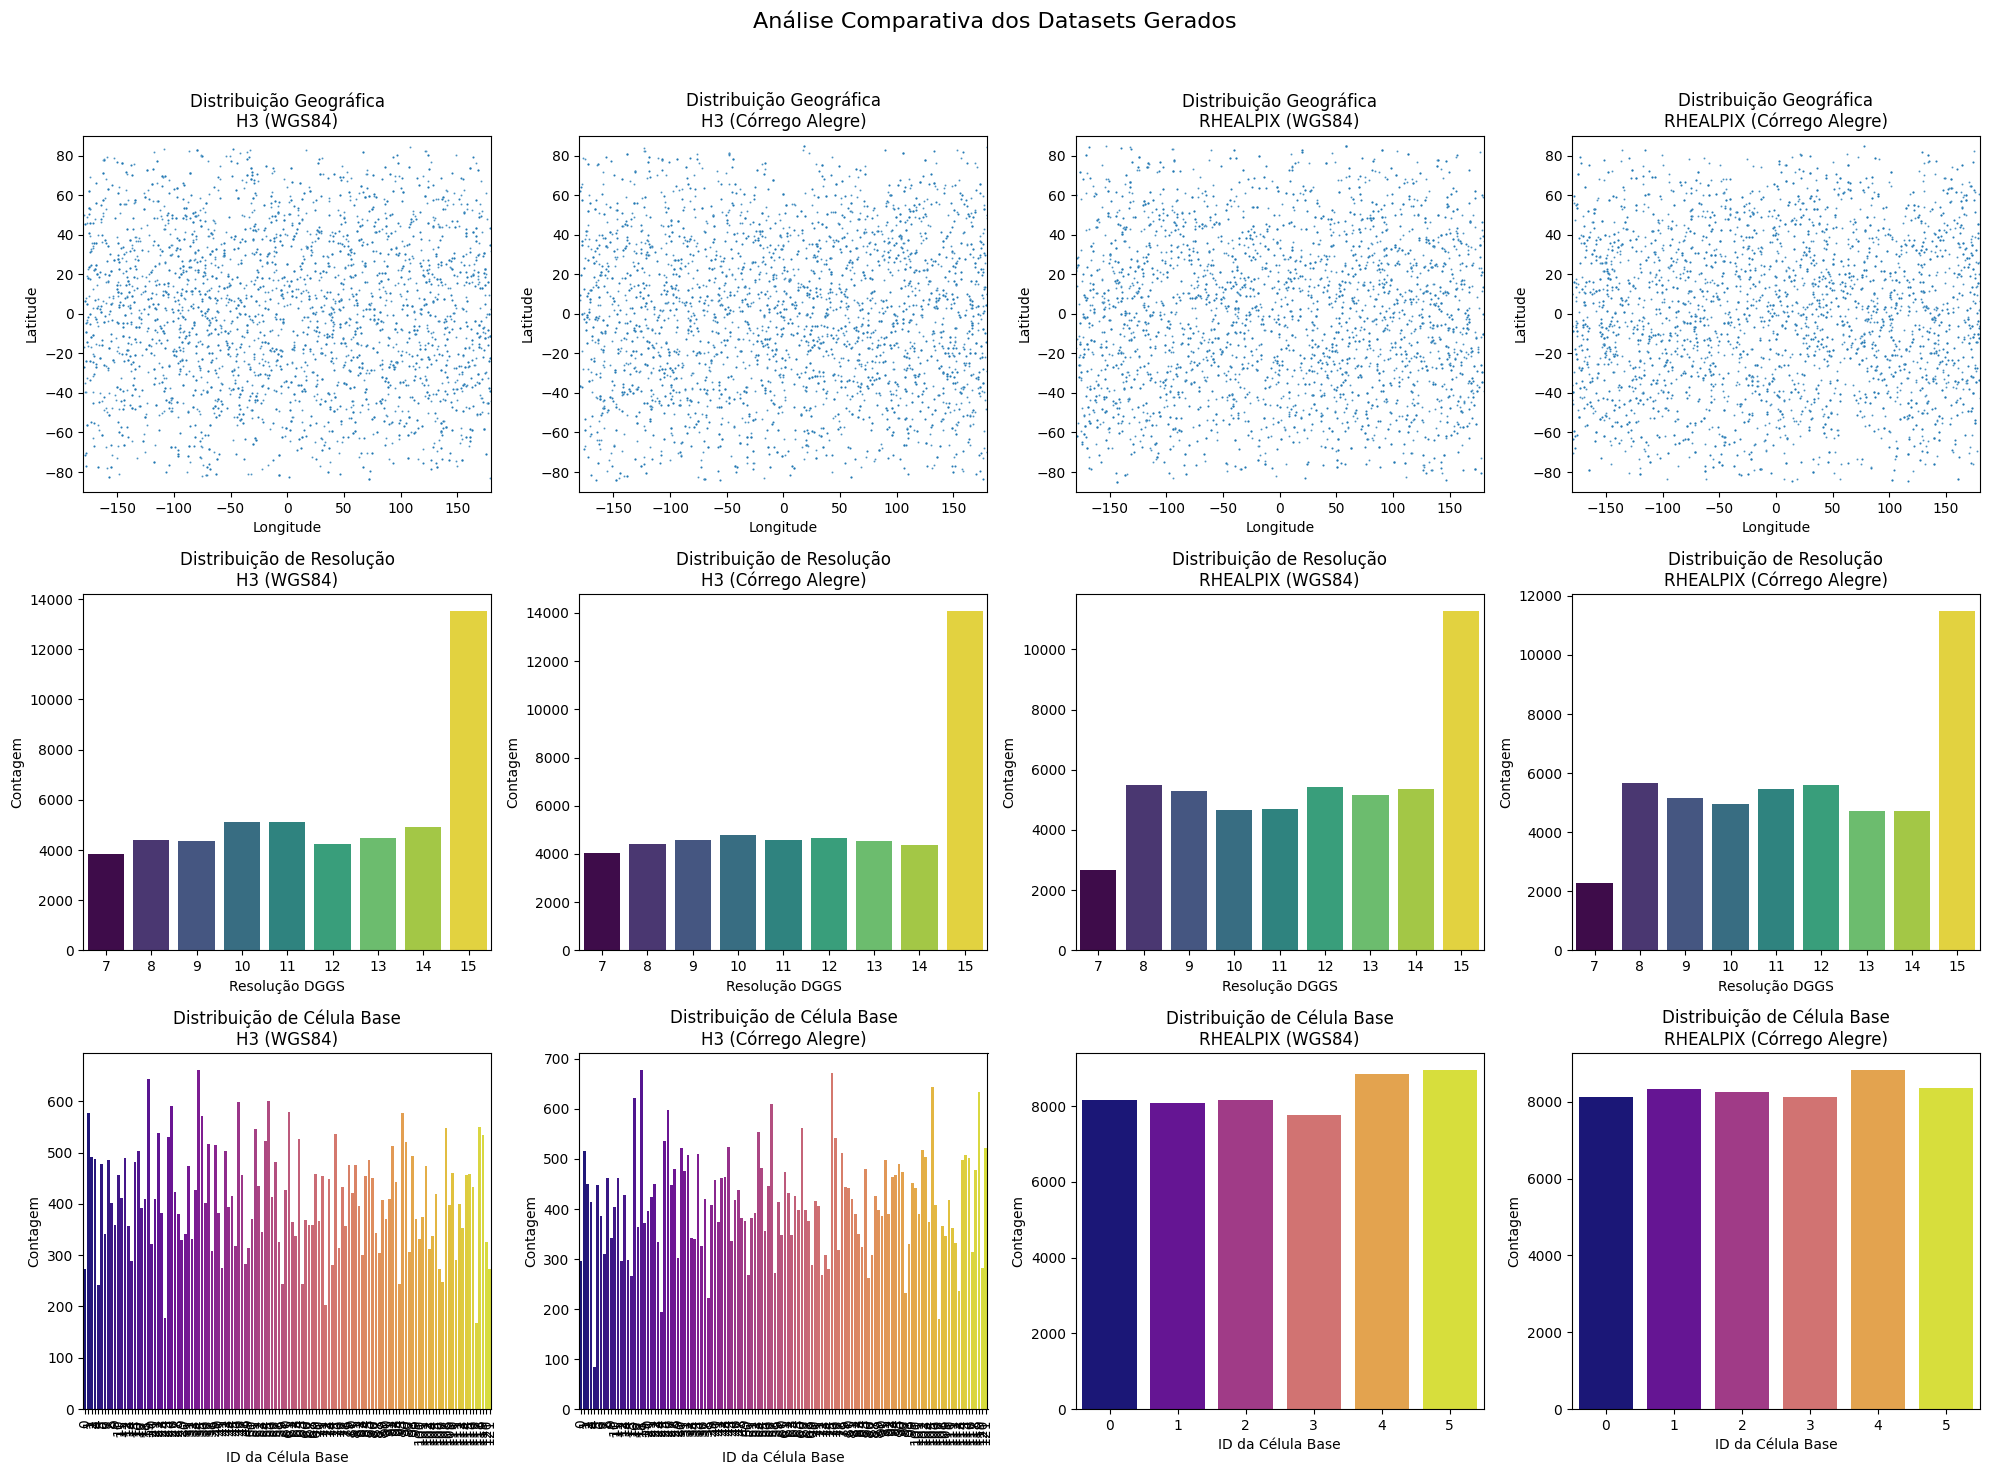


Análise concluída com sucesso!


In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from functools import wraps
import logging
from datetime import datetime

# ==============================================================================
# ETAPA 1: COPIE TODO O SEU CÓDIGO APROVADO AQUI
# (Para tornar este script autônomo, cole as definições de:
#  - log_time_v2
#  - FragmentDataset (com o método .add() corrigido)
#  - Todas as funções de transformação e conversão:
#    - get_cached_transformer
#    - displace_latlon_batch
#    - latlon_to_h3_components
#    - latlon_to_rhealpix_components
#  - E a função principal de geração:
#    - generate_image_points
#  - E as constantes:
#    - CRS_WGS84, CRS_CORREGO_ALEGRE, etc.
#    - H3_EDGE_LENGTH_M, RHEALPIX_EDGE_LENGTH_M
# )
# ...
# EXEMPLO (COLE SEU CÓDIGO REAL AQUI)
# --- Início da Seção de Código do Usuário ---

# Supondo que o código anterior está definido aqui...
# class FragmentDataset: ...
# def get_cached_transformer(...): ...
# etc.

# --- Fim da Seção de Código do Usuário ---
# ==============================================================================


def analyze_generated_data(dataset, dggs_type):
    """
    Analisa um FragmentDataset populado e extrai estatísticas chave.
    """
    print(f"Analisando dados para {dggs_type}...")
    
    # Constrói as matrizes X e y para análise
    X, y = dataset.build_X_y(dggs_type)
    
    # Extrai as coordenadas geográficas originais para plotagem
    coords = [entry['coord'] for entry in dataset.data[dggs_type]]
    lats, lons = zip(*coords)

    analysis = {
        "n_points": len(X),
        "shape_X": X.shape,
        "n_freqs_fourier": (X.shape[1] - 1) // 4, # (n_cols - 1_res) / (2_coords * 2_sincos)
        "shape_y_base": y['base'].shape,
        "resolution_distribution": pd.Series(X[:, -1] * 15).round().astype(int).value_counts().sort_index(),
        "base_cell_distribution": pd.Series(y['base']).value_counts().sort_index(),
        "lats": np.array(lats),
        "lons": np.array(lons),
    }
    
    # Analisa a distribuição de um dígito de resolução intermediária, se existir
    if 'digit_8' in y:
        analysis["digit_8_distribution"] = pd.Series(y['digit_8']).value_counts().sort_index()
        
    return analysis


def plot_analysis_results(results):
    """
    Plota os resultados da análise em uma grade de gráficos para comparação.
    (Versão corrigida para eliminar avisos)
    """
    n_models = len(results)
    fig, axes = plt.subplots(3, n_models, figsize=(5 * n_models, 15), squeeze=False)
    fig.suptitle("Análise Comparativa dos Datasets Gerados", fontsize=16)

    for i, result in enumerate(results):
        model_name = result['model_name']
        
        # --- Gráfico 1: Distribuição Geográfica (sem alterações) ---
        ax = axes[0, i]
        sample_indices = np.random.choice(len(result['lats']), size=min(5000, len(result['lats'])), replace=False)
        sns.scatterplot(x=result['lons'][sample_indices], y=result['lats'][sample_indices], ax=ax, s=2, alpha=0.8)
        ax.set_title(f"Distribuição Geográfica\n{model_name}")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.set_xlim(-180, 180)
        ax.set_ylim(-90, 90)

        # --- Gráfico 2: Distribuição de Resolução (CORRIGIDO) ---
        ax = axes[1, i]
        # Garante que o índice é numérico e aplica a correção do `hue`
        x_res = result['resolution_distribution'].index.astype(int)
        y_res = result['resolution_distribution'].values
        sns.barplot(x=x_res, y=y_res, ax=ax, palette="viridis", 
                    hue=x_res, legend=False) # <--- CORREÇÃO APLICADA
        ax.set_title(f"Distribuição de Resolução\n{model_name}")
        ax.set_xlabel("Resolução DGGS")
        ax.set_ylabel("Contagem")

        # --- Gráfico 3: Distribuição de Célula Base (CORRIGIDO) ---
        ax = axes[2, i]
        # Garante que o índice é numérico e aplica a correção do `hue`
        x_base = result['base_cell_distribution'].index.astype(int)
        y_base = result['base_cell_distribution'].values
        sns.barplot(x=x_base, y=y_base, ax=ax, palette="plasma",
                    hue=x_base, legend=False) # <--- CORREÇÃO APLICADA
        ax.set_title(f"Distribuição de Célula Base\n{model_name}")
        ax.set_xlabel("ID da Célula Base")
        ax.set_ylabel("Contagem")
        # Rotaciona os labels do eixo x se houver muitas células base para não sobrepor
        if len(x_base) > 20:
            ax.tick_params(axis='x', rotation=90)


    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


def main():
    """
    Função principal para orquestrar a geração e análise dos dados.
    """
    # Parâmetros para a geração de dados (etapa de 50k pontos)
    N_POINTS = 50_000
    RES_RANGE = (5, 15)
    N_FREQS = 5 # Deve ser o mesmo usado em generate_image_points

    model_configs = [
        {"dggs": "H3", "crs": "WGS84"},
        {"dggs": "H3", "crs": "Córrego Alegre"},
        {"dggs": "RHEALPIX", "crs": "WGS84"},
        {"dggs": "RHEALPIX", "crs": "Córrego Alegre"},
    ]
    
    all_results = []

    print("="*80)
    print("Iniciando a Geração e Análise de Dados para Avaliação")
    print(f"Pontos alvo por modelo: {N_POINTS}")
    print("="*80)

    for config in model_configs:
        model_name = f"{config['dggs']} ({config['crs']})"
        print(f"\n--- Gerando dados para o modelo: {model_name} ---")
        
        # Gera os dados
        dataset = generate_image_points(
            n_points=N_POINTS,
            dggs=config['dggs'],
            res_range=RES_RANGE,
            crs=config['crs']
        )
        
        # Analisa os dados gerados
        analysis = analyze_generated_data(dataset, config['dggs'])
        analysis['model_name'] = model_name
        all_results.append(analysis)

    # --- Apresentação dos Resultados ---
    
    # 1. Tabela Resumo em Pandas
    summary_data = []
    for r in all_results:
        summary_data.append({
            "Modelo": r['model_name'],
            "Pontos Gerados": r['n_points'],
            "Shape de X": str(r['shape_X']),
            "Shape de y (base)": str(r['shape_y_base']),
            "Resoluções (Min/Max)": f"{r['resolution_distribution'].index.min()}/{r['resolution_distribution'].index.max()}",
            "Células Base (Únicas)": len(r['base_cell_distribution'])
        })
        
    summary_df = pd.DataFrame(summary_data)
    print("\n\n" + "="*80)
    print("Tabela Resumo Comparativa")
    print("="*80)
    print(summary_df.to_string())

    # 2. Gráficos Comparativos
    print("\nGerando gráficos comparativos...")
    plot_analysis_results(all_results)
    
    print("\nAnálise concluída com sucesso!")


if __name__ == '__main__':
    # Configuração do logging para ver a saída do decorator @log_time_v2
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    main()

INICIANDO TESTE 1: Transformação de CRS (Córrego Alegre -> WGS84)
Ponto de Origem (tratado como Córrego Alegre): Lat=-23.551000, Lon=-46.634000
Ponto Transformado (resultado em WGS84):      Lat=-23.551383, Lon=-46.634329

Distância do deslocamento entre os pontos: 54.19 metros.


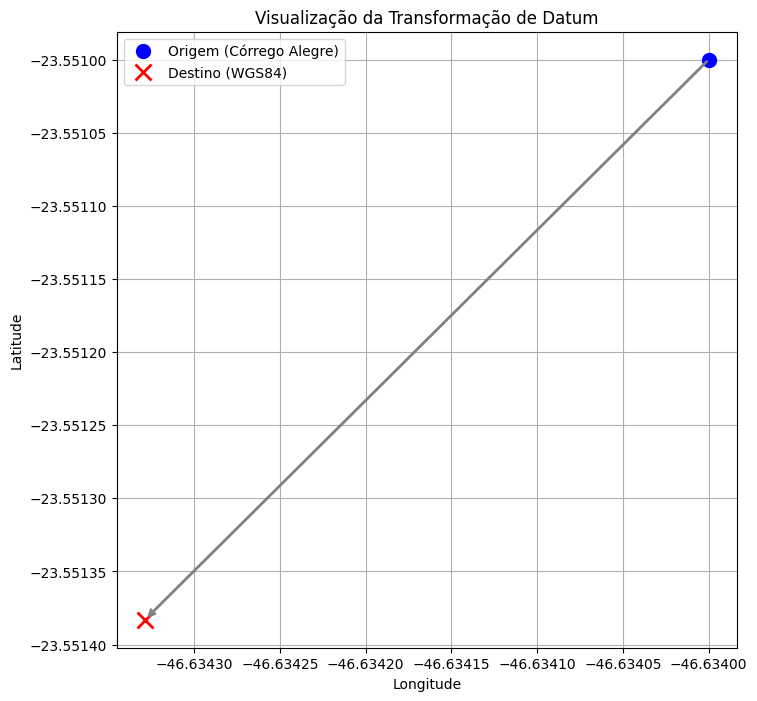


INICIANDO TESTE 2: Validação das Fourier Features
Gerando gráfico para Longitude. Observe o comportamento cíclico (valores em -180 e 180 são iguais).


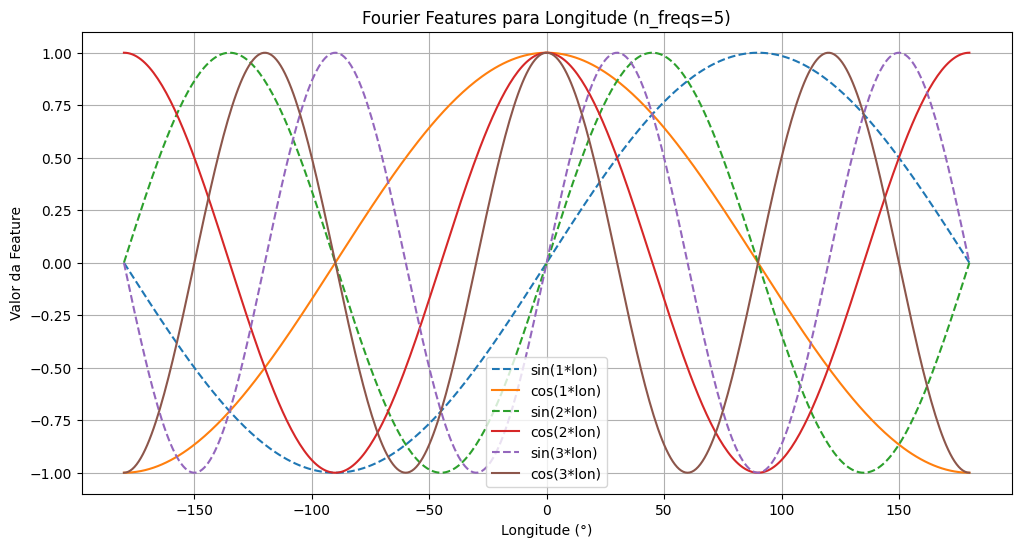

Gerando gráfico para Latitude. Observe o comportamento suave ao longo do intervalo.


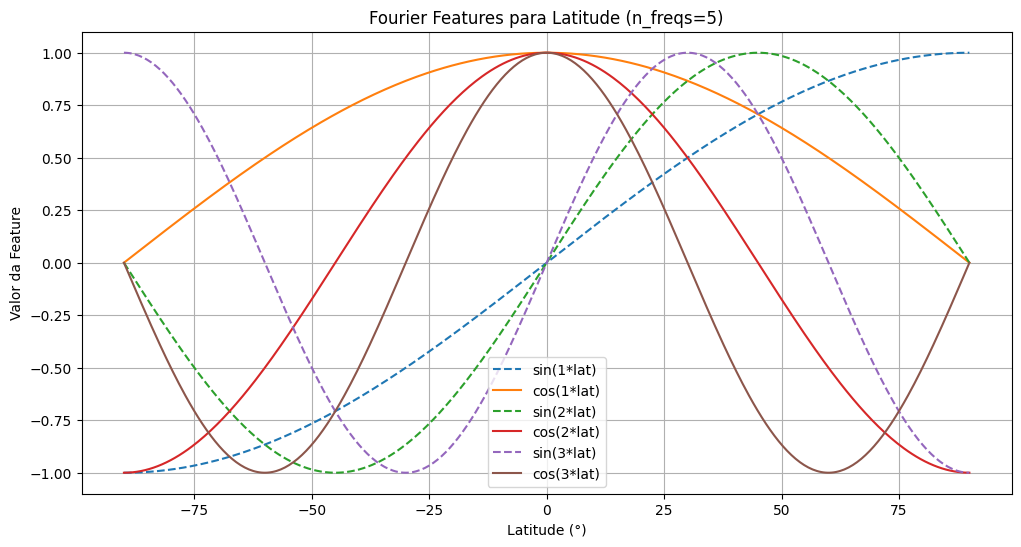

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# ==============================================================================
# SEÇÃO DE SETUP
# Garanta que suas classes e funções estejam disponíveis aqui.
# Exemplo:
# from import FragmentDataset, get_cached_transformer, CRS_CORREGO_ALEGRE, CRS_WGS84
#
# Para este exemplo, vou simular as definições necessárias.

def haversine_distance(lat1, lon1, lat2, lon2):
    """Calcula a distância em metros entre dois pontos geográficos."""
    R = 6371000  # Raio da Terra em metros
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c

def test_crs_transformation():
    """
    Testa a transformação de um ponto de Córrego Alegre para WGS84.
    """
    print("="*80)
    print("INICIANDO TESTE 1: Transformação de CRS (Córrego Alegre -> WGS84)")
    print("="*80)
    
     # Vamos tratar este ponto como se estivesse no datum Córrego Alegre.
    sp_lat_ca, sp_lon_ca = -23.551, -46.634

    print(f"Ponto de Origem (tratado como Córrego Alegre): Lat={sp_lat_ca:.6f}, Lon={sp_lon_ca:.6f}")

    # Usa sua função para obter o transformer
    transformer = get_cached_transformer(CRS_CORREGO_ALEGRE, CRS_WGS84)
    
    # Transforma o ponto
    sp_lon_wgs84, sp_lat_wgs84 = transformer.transform(sp_lon_ca, sp_lat_ca)
    
    print(f"Ponto Transformado (resultado em WGS84):      Lat={sp_lat_wgs84:.6f}, Lon={sp_lon_wgs84:.6f}")
    
    # Calcula o deslocamento
    distance = haversine_distance(sp_lat_ca, sp_lon_ca, sp_lat_wgs84, sp_lon_wgs84)
    
    print(f"\nDistância do deslocamento entre os pontos: {distance:.2f} metros.")
    
    # Visualização
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(sp_lon_ca, sp_lat_ca, 'bo', markersize=10, label='Origem (Córrego Alegre)')
    ax.plot(sp_lon_wgs84, sp_lat_wgs84, 'rx', markersize=12, markeredgewidth=2, label='Destino (WGS84)')
    
    # Adiciona uma seta mostrando o deslocamento
    ax.annotate("", xy=(sp_lon_wgs84, sp_lat_wgs84), xytext=(sp_lon_ca, sp_lat_ca),
                arrowprops=dict(arrowstyle="->", color='gray', lw=2))
                
    ax.legend()
    ax.set_title("Visualização da Transformação de Datum")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.ticklabel_format(style='plain', useOffset=False) # Evita notação científica
    plt.grid(True)
    plt.show()

def test_fourier_features(n_freqs=5):
    """
    Visualiza as componentes das Fourier Features para longitude e latitude.
    """
    print("\n" + "="*80)
    print("INICIANDO TESTE 2: Validação das Fourier Features")
    print("="*80)

    dataset_ff = FragmentDataset(n_freqs=n_freqs)

    # --- Teste para Longitude (comportamento cíclico) ---
    lons = np.linspace(-180, 180, 400)
    ff_lon = dataset_ff._fourier_axis(lons)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    for k in range(1, 4): # Plota as 3 primeiras frequências
        # Colunas de seno: 0, 1, 2, ...
        # Colunas de cosseno: n_freqs, n_freqs+1, ...
        ax.plot(lons, ff_lon[:, k-1], linestyle='--', label=f'sin({k}*lon)')
        ax.plot(lons, ff_lon[:, k-1 + n_freqs], linestyle='-', label=f'cos({k}*lon)')

    ax.set_title(f"Fourier Features para Longitude (n_freqs={n_freqs})")
    ax.set_xlabel("Longitude (°)")
    ax.set_ylabel("Valor da Feature")
    ax.legend()
    ax.grid(True)
    print("Gerando gráfico para Longitude. Observe o comportamento cíclico (valores em -180 e 180 são iguais).")
    plt.show()

    # --- Teste para Latitude (comportamento não-cíclico) ---
    lats = np.linspace(-90, 90, 400)
    ff_lat = dataset_ff._fourier_axis(lats)

    fig, ax = plt.subplots(figsize=(12, 6))
    for k in range(1, 4): # Plota as 3 primeiras frequências
        ax.plot(lats, ff_lat[:, k-1], linestyle='--', label=f'sin({k}*lat)')
        ax.plot(lats, ff_lat[:, k-1 + n_freqs], linestyle='-', label=f'cos({k}*lat)')

    ax.set_title(f"Fourier Features para Latitude (n_freqs={n_freqs})")
    ax.set_xlabel("Latitude (°)")
    ax.set_ylabel("Valor da Feature")
    ax.legend()
    ax.grid(True)
    print("Gerando gráfico para Latitude. Observe o comportamento suave ao longo do intervalo.")
    plt.show()


if __name__ == '__main__':
    # Teste 1: Validação da transformação de Córrego Alegre para WGS84
    test_crs_transformation()

    # Teste 2: Validação da geração das Fourier Features
    # Usando n_freqs=5, como no seu gerador de dados
    test_fourier_features(n_freqs=5)

#### 📊 Geração dos Dados Sintéticos

As resoluções devem variar entre aprox 5km e 10 cm.

Cada fragmento corresponde a aproximadamente 16 coordenadas.

Range de resoluções do H3:
- min: 7 (2,81km - hexEdge: 1,40km)
- max: 15 (1,17m - hexEdge: 0,584m) - maior resolução do H3

Range de resoluções do rHEALPix:
- min: 7 (4,22km)
- max: 15 (0,64m) - maior resolução do rHEALPix

In [7]:
# Quantidade de Pontos
n_points = 100_000

# Geração de fragmentos para WGS84
print('[INFO] Initializing generation of coordinate image fragments for H3 DGGS for WGS84')
dataset_H3_WGS84 = generate_image_points(n_points=n_points, dggs='H3', res_range=(7, 15), crs='WGS84')
# print('[INFO] Initializing generation of coordinate image fragments for H3 DGGS for Corrego Alegre')
# dataset_H3_Corrego = generate_image_points(n_points=n_points, dggs='H3', res_range=(7, 15), crs='CÓRREGO ALEGRE')
print('[INFO] Initializing generation of coordinate image fragments for rHEALPix DGGS for WGS84')
dataset_rHEALPix_WGS84 = generate_image_points(n_points=n_points, dggs='rHEALPix', res_range=(7, 15), crs='WGS84')
# print('[INFO] Initializing generation of coordinate image fragments for rHEALPix DGGS for Corrego Alegre')
# dataset_rHEALPix_Corrego = generate_image_points(n_points=n_points, dggs='rHEALPix', res_range=(7, 15), crs='CÓRREGO ALEGRE')

# Construção das entradas para MLP
print('[INFO] Normalizing coordinate image fragments with Fourier Features')
X_H3_WGS84, y_H3_WGS84 = dataset_H3_WGS84.get_X_y('H3')
# X_H3_Corrego, y_H3_Corrego = dataset_H3_Corrego.get_X_y('H3')
X_rHEALPix_WGS84, y_rHEALPix_WGS84 = dataset_rHEALPix_WGS84.get_X_y('rHEALPix')
# X_rHEALPix_Corrego, y_rHEALPix_Corrego = dataset_rHEALPix_Corrego.get_X_y('rHEALPix')

2025-06-20 18:00:38,257 - INFO - Starting: generate_image_points


[INFO] Initializing generation of coordinate image fragments for H3 DGGS for WGS84


2025-06-20 18:00:39,810 - INFO - Completed generate_image_points in 1.55 seconds
2025-06-20 18:00:39,811 - INFO - Starting: generate_image_points


[INFO] Initializing generation of coordinate image fragments for rHEALPix DGGS for WGS84


2025-06-20 18:00:44,636 - INFO - Completed generate_image_points in 4.83 seconds
2025-06-20 18:00:44,637 - INFO - Starting: build_X_y


[INFO] Normalizing coordinate image fragments with Fourier Features


2025-06-20 18:00:45,178 - INFO - Completed build_X_y in 0.54 seconds
2025-06-20 18:00:45,178 - INFO - Starting: build_X_y
2025-06-20 18:00:45,730 - INFO - Completed build_X_y in 0.55 seconds


### 2.2 Ajuste de hiperparâmetros

#### 📦 Classe de configuração para treinamento e busca de hiperparâmetros

In [133]:
# pip install optuna optuna-integration[tfkeras]
# !pip install pandas

In [8]:
# Supressão dos avisos do Optuna (que polui a saída)
import warnings
import re  # Módulo de expressões regulares

# Supressão de avisos
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module="optuna.trial._trial"
)
warnings.filterwarnings(
    "ignore",
    message=r".*tf.reset_default_graph is deprecated.*"
)

import optuna
from optuna.integration import TFKerasPruningCallback
import gc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import StratifiedKFold
import numpy as np

class HPTuner:
    """
    Refinador de de hiperparâmetros com K-Fold + EarlyStopping.
    -------------------------------------------------
    Parâmetros
    ----------
    search_space : dict
        Chaves e intervalos para Optuna (veja o padrão abaixo).
    n_epochs     : int
        Máximo de épocas por fold.
    es_patience  : int or None
        Paciência para parada antecipada (None = desabilitada).
    n_folds      : int
        Número de K-Fold (>=2). 1 == hold-out (sem CV).
    random_state : int
        Semente para embaralhamento de K-Fold.
    """

    default_space = dict(
        num_hidden_layers=(2, 6),
        neurons_choices=[32, 64, 128, 256, 512],
        activation=['relu', 'tanh', 'elu'],
        optimizer=['adam', 'rmsprop', 'sgd'],
        lr=(1e-5, 1e-2),                 # log scale
        batch_size=[32, 64, 128, 256],
        dropout=(0.1, 0.5),
        l2=(1e-6, 1e-2)                 # log scale
    )

    # ---------- constructor ----------
    def __init__(self,
                 search_space=None,
                 n_epochs=20,
                 es_patience=5,
                 n_folds=5,
                 random_state=42):
        self.space        = search_space or HPTuner.default_space.copy()
        self.n_epochs     = n_epochs
        self.es_patience  = es_patience
        self.n_folds      = max(1, n_folds)
        self.random_state = random_state
        self.best_params  = None
        self.best_score   = -np.inf
        self.study        = None

    # ---------- public: run search ----------
    @log_time_v2
    def run(self, X, y_dict, n_trials=20):
        output_keys = list(y_dict.keys())
        # Usar o MedianPruner para pruning
        pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)  # pular pruning nas primeiras 5 épocas
        self.study  = optuna.create_study(direction='maximize')
        objective   = self._make_objective(X, y_dict, output_keys)
        self.study.optimize(objective, n_trials=n_trials, n_jobs=1)
        self.best_params = self.study.best_params
        self.best_score  = self.study.best_value
        return self.best_params, self.best_score

    # ---------- internal: build Optuna objective ----------
    def _make_objective(self, X, y_dict, output_keys):

        def suggest(trial, name, rng):
            """Helper for readability"""
            if isinstance(rng, tuple):  # range ⇒ int or float
                lo, hi = rng
                return trial.suggest_float(name, lo, hi, log=True) if lo < 1e-3 else trial.suggest_int(name, lo, hi)
            return trial.suggest_categorical(name, rng)

        def objective(trial):
            # Hiperparâmetros
            n_hidden = trial.suggest_int('num_hidden_layers', *self.space['num_hidden_layers'])
            neurons  = [trial.suggest_categorical(f'n_units_{i+1}',
                        self.space['neurons_choices'])
                        for i in range(n_hidden)]
            act      = trial.suggest_categorical('activation', self.space['activation'])
            opt_name = trial.suggest_categorical('optimizer',  self.space['optimizer'])
            lr       = trial.suggest_float('lr', *self.space['lr'], log=True)
            batch    = trial.suggest_categorical('batch_size', self.space['batch_size'])
            dropout  = trial.suggest_float('dropout', *self.space['dropout'])
            l2_reg   = trial.suggest_float('l2', *self.space['l2'], log=True)

            # Validação
            kf = StratifiedKFold(
                    n_splits=self.n_folds,
                    shuffle=True,
                    random_state=self.random_state
                 )

            fold_scores = []
            for train_idx, val_idx in kf.split(X, y_dict['base']):
                X_train, X_val = X[train_idx], X[val_idx]
                y_train = {k: y_dict[k][train_idx] for k in output_keys}
                y_val   = {k: y_dict[k][val_idx]   for k in output_keys}

                # Modelo
                inp = layers.Input(shape=(X.shape[1],))
                x   = inp
                for n in neurons:
                    x = layers.Dense(n, activation=act,
                                     kernel_regularizer=regularizers.l2(l2_reg))(x)
                    if dropout > 0:
                        x = layers.Dropout(dropout)(x)

                outs = {k: layers.Dense(int(y_dict[k].max()) + 1,
                        activation='softmax', name=k)(x)
                        for k in output_keys}
                model = keras.Model(inputs=inp, outputs=outs)

                opt_cls = {'adam': keras.optimizers.Adam,
                           'rmsprop': keras.optimizers.RMSprop,
                           'sgd': keras.optimizers.SGD}[opt_name]
                model.compile(
                    optimizer=opt_cls(learning_rate=lr),
                    loss={k: 'sparse_categorical_crossentropy' for k in output_keys},
                    loss_weights=self._hierarchical_weights(output_keys),
                    metrics={k: 'accuracy' for k in output_keys}
                )

                callbacks = []
                # EarlyStopping
                if self.es_patience:
                    callbacks.append(keras.callbacks.EarlyStopping(
                        monitor=f'val_{output_keys[0]}_accuracy',  # monitor first head
                        mode='max',
                        patience=self.es_patience,
                        restore_best_weights=True,
                        verbose=0
                    ))

                # Optuna Pruning
                callbacks.append(TFKerasPruningCallback(
                    trial,
                    monitor=f'val_{output_keys[0]}_accuracy'
                ))
                
                history = model.fit(
                    X_train, {k: y_train[k] for k in output_keys},
                    validation_data=(X_val, {k: y_val[k] for k in output_keys}),
                    epochs=self.n_epochs,
                    batch_size=batch,
                    callbacks=callbacks,
                    verbose=0
                )

                # último valor após ES - Média ponderada
                weights_dict = self._hierarchical_weights(output_keys)
                weighted_accuracies = [
                    history.history[f'val_{k}_accuracy'][-1] * weights_dict[k] for k in output_keys
                ]
                total_weight = sum(weights_dict.values())
                fold_scores.append(sum(weighted_accuracies) / total_weight)

                # Gerenciamento de Memória
                del model
                keras.backend.clear_session()
                gc.collect()
                
            return float(np.mean(fold_scores))
        return objective

    # ---------- static helper ----------
    @staticmethod
    def _hierarchical_weights(keys):
        w = {}
        for k in keys:
            if k == 'base':
                w[k] = 2.0
            else:
                lvl  = int(k.split('_')[1])
                w[k] = max(0.1, 1.5 / lvl)
        return w

C:\Program Files\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 🔍 Busca de hiperparâmetros

Busca inicial: abrangente com 50000 pontos

In [81]:
import json
import pickle
import os

# Parâmetros de Busca
n_trials = 30
n_epochs = 30
es_patience = 5
n_folds = 4
search_space = dict(
        num_hidden_layers=(2, 6),
        neurons_choices=[32, 64, 128, 256, 512],
        activation=['relu', 'tanh', 'elu'],
        optimizer=['adam', 'rmsprop', 'sgd'],
        lr=(1e-5, 1e-2),                 # log scale
        batch_size=[32, 64, 128, 256],
        dropout=(0.1, 0.5),
        l2=(1e-6, 1e-2)                 # log scale
    )

# H3 (WGS84)
X_H3, y_H3 = dataset_H3_WGS84.get_X_y('H3')

tuner_h3 = HPTuner(
    n_epochs=n_epochs,         # override default
    es_patience=es_patience,   # early-stopping patience
    n_folds=n_folds,           # k-fold CV
    search_space=search_space  # or provide your own dict
)
print('[INFO] Initializing hyper-parameters optimization for H3 DGGS for WGS84')
best_h3_params, best_h3_score = tuner_h3.run(X_H3, y_H3, n_trials=n_trials)
print("H3 ▸ Best Score:", best_h3_score)
print("H3 ▸ Best Params:", best_h3_params)

# Salvar melhores parâmetros em JSON
with open('best_params_h3.json', 'w') as f:
    json.dump(best_h3_params, f, indent=4)
# Salvar objeto de estudo completo em Pickle
with open('study_h3.pkl', 'wb') as f:
    pickle.dump(tuner_h3.study, f)
print("[INFO] Results for H3 were saved in 'best_params_h3.json' and 'study_h3.pkl'")


# rHEALPix (WGS84)
X_rhp, y_rhp = dataset_rHEALPix_WGS84.get_X_y('rHEALPix')
tuner_rhp = HPTuner(
    n_epochs=n_epochs,
    es_patience=es_patience,
    n_folds=n_folds,
    search_space=search_space   # same space reused
)
print('[INFO] Initializing hyper-parameters optimization for rHEALPix DGGS for WGS84')
best_rhp_params, best_rhp_score = tuner_rhp.run(X_rhp, y_rhp, n_trials=n_trials)
print("rHEALPix ▸ Best Score:", best_rhp_score)
print("rHEALPix ▸ Best Params:", best_rhp_params)

# Salvar melhores parâmetros em JSON
with open('best_params_rhealpix.json', 'w') as f:
    json.dump(best_rhp_params, f, indent=4)
# Salvar objeto de estudo completo em Pickle
with open('study_rhealpix.pkl', 'wb') as f:
    pickle.dump(tuner_rhp.study, f)
print("[INFO] Results for rHEALPix foram saved in 'best_params_rhealpix.json' and 'study_rhealpix.pkl'")

2025-06-20 06:17:11,230 - INFO - Starting: run
[I 2025-06-20 06:17:11,231] A new study created in memory with name: no-name-8c15cbf8-60c9-4f18-b4be-84e7103ad32c


[INFO] Initializing hyper-parameters optimization for H3 DGGS for WGS84



2025-06-20 06:17:25,347 - WARNING - From C:\Program Files\Python312\Lib\site-packages\keras\src\backend\common\global_state.py:82: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

[I 2025-06-20 06:18:15,877] Trial 0 finished with value: 0.5038754095557048 and parameters: {'num_hidden_layers': 2, 'n_units_1': 128, 'n_units_2': 32, 'activation': 'relu', 'optimizer': 'rmsprop', 'lr': 0.003468624140467975, 'batch_size': 256, 'dropout': 0.14704538681668966, 'l2': 8.44369247544635e-06}. Best is trial 0 with value: 0.5038754095557048.
[I 2025-06-20 06:23:05,048] Trial 1 finished with value: 0.5352443942505765 and parameters: {'num_hidden_layers': 2, 'n_units_1': 32, 'n_units_2': 64, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.0017187842656109149, 'batch_size': 32, 'dropout': 0.15757449800408324, 'l2': 1.1366516570635596e-06}. Best is trial 1 with value: 0.5352443942505765.
[I 2025-06-20 06:24:47,316] Trial 2 finished with value: 0.466

H3 ▸ Best Score: 0.7253657313212076
H3 ▸ Best Params: {'num_hidden_layers': 3, 'n_units_1': 512, 'n_units_2': 512, 'n_units_3': 512, 'activation': 'tanh', 'optimizer': 'rmsprop', 'lr': 0.0003323808203380748, 'batch_size': 32, 'dropout': 0.1123385256967263, 'l2': 0.0024194369669555825}
[INFO] Results for H3 were saved in 'best_params_h3.json' and 'study_h3.pkl'
[INFO] Initializing hyper-parameters optimization for rHEALPix DGGS for WGS84


[I 2025-06-20 07:12:20,191] Trial 0 finished with value: 0.6187354174828884 and parameters: {'num_hidden_layers': 5, 'n_units_1': 32, 'n_units_2': 512, 'n_units_3': 32, 'n_units_4': 32, 'n_units_5': 128, 'activation': 'tanh', 'optimizer': 'rmsprop', 'lr': 0.0001379201963972756, 'batch_size': 32, 'dropout': 0.18419712417902045, 'l2': 0.0014942893713779295}. Best is trial 0 with value: 0.6187354174828884.
[I 2025-06-20 07:14:44,465] Trial 1 finished with value: 0.5876147194290835 and parameters: {'num_hidden_layers': 3, 'n_units_1': 512, 'n_units_2': 512, 'n_units_3': 128, 'activation': 'elu', 'optimizer': 'rmsprop', 'lr': 2.144321245726765e-05, 'batch_size': 256, 'dropout': 0.2919759158790874, 'l2': 5.533106157940655e-06}. Best is trial 0 with value: 0.6187354174828884.
[I 2025-06-20 07:19:43,764] Trial 2 finished with value: 0.5781040990757259 and parameters: {'num_hidden_layers': 5, 'n_units_1': 64, 'n_units_2': 64, 'n_units_3': 64, 'n_units_4': 128, 'n_units_5': 64, 'activation': 'ta

rHEALPix ▸ Best Score: 0.846125161374744
rHEALPix ▸ Best Params: {'num_hidden_layers': 3, 'n_units_1': 128, 'n_units_2': 256, 'n_units_3': 512, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.0011971480386034734, 'batch_size': 64, 'dropout': 0.1047108846255364, 'l2': 1.0024687785967218e-06}
[INFO] Results for rHEALPix foram saved in 'best_params_rhealpix.json' and 'study_rhealpix.pkl'


Busca final: refinada

In [84]:
len(dataset_H3_WGS84.data['H3'])

100000

In [9]:
# Parâmetros de Busca Refinada
n_trials = 50
n_epochs = 30
es_patience = 5
n_folds = 4

# H3 (WGS84)
search_space_h3 = dict(
        num_hidden_layers=(2, 4),
        neurons_choices=[256, 512, 768, 1024],
        activation=['tanh'],
        optimizer=['adam', 'rmsprop'],
        lr=(1e-4, 2e-3),                 # log scale
        batch_size=[32, 64],
        dropout=(0.0, 0.25),
        l2=(5e-4, 5e-3)                 # log scale
    )
X_H3, y_H3 = dataset_H3_WGS84.get_X_y('H3')

tuner_h3 = HPTuner(
    n_epochs=n_epochs,            # override default
    es_patience=es_patience,      # early-stopping patience
    n_folds=n_folds,              # k-fold CV
    search_space=search_space_h3  # or provide your own dict
)
print('[INFO] Initializing hyper-parameters optimization for H3 DGGS for WGS84')
best_h3_params, best_h3_score = tuner_h3.run(X_H3, y_H3, n_trials=n_trials)
print("H3 ▸ Best Score:", best_h3_score)
print("H3 ▸ Best Params:", best_h3_params)

# Salvar melhores parâmetros em JSON
with open('best_params_h3_refined.json', 'w') as f:
    json.dump(best_h3_params, f, indent=4)
# Salvar objeto de estudo completo em Pickle
with open('study_h3_refined.pkl', 'wb') as f:
    pickle.dump(tuner_h3.study, f)
print("[INFO] Results for H3 were saved in 'best_params_h3_refined.json' and 'study_h3_refined.pkl'")

2025-06-20 18:02:57,797 - INFO - Starting: run
[I 2025-06-20 18:02:57,798] A new study created in memory with name: no-name-670f901b-ac6f-4a8e-818a-97000130d8c3


[INFO] Initializing hyper-parameters optimization for H3 DGGS for WGS84


2025-06-20 18:04:08,874 - WARNING - From C:\Program Files\Python312\Lib\site-packages\keras\src\backend\common\global_state.py:82: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

[I 2025-06-20 18:11:44,100] Trial 0 finished with value: 0.5304268911888566 and parameters: {'num_hidden_layers': 4, 'n_units_1': 256, 'n_units_2': 512, 'n_units_3': 256, 'n_units_4': 768, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.00010091208385221982, 'batch_size': 64, 'dropout': 0.17299462308759356, 'l2': 0.004485170904733805}. Best is trial 0 with value: 0.5304268911888566.
[I 2025-06-20 18:19:42,279] Trial 1 finished with value: 0.6198818491641684 and parameters: {'num_hidden_layers': 4, 'n_units_1': 1024, 'n_units_2': 1024, 'n_units_3': 768, 'n_units_4': 512, 'activation': 'tanh', 'optimizer': 'rmsprop', 'lr': 0.0017659794488841052, 'batch_size': 64, 'dropout': 0.06374168480760198, 'l2': 0.0017043024938129447}. Best is trial 1 with value: 0.619

H3 ▸ Best Score: 0.8139219062113578
H3 ▸ Best Params: {'num_hidden_layers': 3, 'n_units_1': 512, 'n_units_2': 512, 'n_units_3': 1024, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.00032559986818454475, 'batch_size': 64, 'dropout': 0.007363372617554281, 'l2': 0.0009186983777395298}


NameError: name 'json' is not defined

In [11]:
# Salvar melhores parâmetros em JSON
with open('best_params_h3_refined.json', 'w') as f:
    json.dump(best_h3_params, f, indent=4)
# Salvar objeto de estudo completo em Pickle
with open('study_h3_refined.pkl', 'wb') as f:
    pickle.dump(tuner_h3.study, f)
print("[INFO] Results for H3 were saved in 'best_params_h3_refined.json' and 'study_h3_refined.pkl'")

[INFO] Results for H3 were saved in 'best_params_h3_refined.json' and 'study_h3_refined.pkl'


In [10]:
import json
import pickle
import os

# rHEALPix (WGS84)
search_space_rhp = dict(
        num_hidden_layers=(2, 4),
        neurons_choices=[128, 256, 512, 768],
        activation=['tanh'],
        optimizer=['adam', 'rmsprop'],
        lr=(1e-4, 2e-3),                 # log scale
        batch_size=[32, 64, 128],
        dropout=(0.0, 0.25),
        l2=(1e-8, 1e-4)                 # log scale
    )
X_rhp, y_rhp = dataset_rHEALPix_WGS84.get_X_y('rHEALPix')

tuner_rhp = HPTuner(
    n_epochs=n_epochs,
    es_patience=es_patience,
    n_folds=n_folds,
    search_space=search_space_rhp
)
print('[INFO] Initializing hyper-parameters optimization for rHEALPix DGGS for WGS84')
best_rhp_params, best_rhp_score = tuner_rhp.run(X_rhp, y_rhp, n_trials=n_trials)
print("rHEALPix ▸ Best Score:", best_rhp_score)
print("rHEALPix ▸ Best Params:", best_rhp_params)

# Salvar melhores parâmetros em JSON
with open('best_params_rhealpix_refined.json', 'w') as f:
    json.dump(best_rhp_params, f, indent=4)
# Salvar objeto de estudo completo em Pickle
with open('study_rhealpix_refined.pkl', 'wb') as f:
    pickle.dump(tuner_rhp.study, f)
print("[INFO] Results for rHEALPix foram saved in 'best_params_rhealpix_refined.json' and 'study_rhealpix_refined.pkl'")

2025-06-21 00:49:30,703 - INFO - Starting: run
[I 2025-06-21 00:49:30,704] A new study created in memory with name: no-name-201ece96-543b-453d-b923-8d781aad4f69


[INFO] Initializing hyper-parameters optimization for rHEALPix DGGS for WGS84


[I 2025-06-21 01:02:29,187] Trial 0 finished with value: 0.7311172994742741 and parameters: {'num_hidden_layers': 2, 'n_units_1': 512, 'n_units_2': 128, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.00017222700909945034, 'batch_size': 64, 'dropout': 0.05650025877560577, 'l2': 3.110699343939974e-06}. Best is trial 0 with value: 0.7311172994742741.
[I 2025-06-21 01:09:47,041] Trial 1 finished with value: 0.7893135025661328 and parameters: {'num_hidden_layers': 4, 'n_units_1': 256, 'n_units_2': 256, 'n_units_3': 512, 'n_units_4': 128, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.0011869700930145237, 'batch_size': 128, 'dropout': 0.10314493925232512, 'l2': 6.296266694195145e-07}. Best is trial 1 with value: 0.7893135025661328.
[I 2025-06-21 01:36:23,956] Trial 2 finished with value: 0.787865028950401 and parameters: {'num_hidden_layers': 2, 'n_units_1': 512, 'n_units_2': 512, 'activation': 'tanh', 'optimizer': 'rmsprop', 'lr': 0.0006474611480833035, 'batch_size': 32, 'dropout': 

rHEALPix ▸ Best Score: 0.9057541882354342
rHEALPix ▸ Best Params: {'num_hidden_layers': 3, 'n_units_1': 768, 'n_units_2': 512, 'n_units_3': 768, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.000539950623038664, 'batch_size': 64, 'dropout': 0.025905973023106377, 'l2': 4.615031433683314e-05}
[INFO] Results for rHEALPix foram saved in 'best_params_rhealpix_refined.json' and 'study_rhealpix_refined.pkl'


### 2.3 Treinamento e validação

#### Função do MLP

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import numpy as np

def build_mlp(input_dim, output_keys, y_dict, params):
    """Constrói o modelo MLP usando a configuração de 'params'."""
    inp = layers.Input(shape=(input_dim,))
    x = inp
    
    # Camadas ocultas
    num_layers = params.space['num_hidden_layers']
    neurons_list = params.space['neurons_choices']

    # Garante que temos neurônios definidos para cada camada
    if len(neurons_list) < num_layers:
        raise ValueError(f"The number of layers ({num_layers}) is greater than the neurons list provided ({len(neurons_list)}).")

    for i in range(num_layers):
        x = layers.Dense(neurons_list[i], # Usa o neurônio correspondente à camada i
                         activation=params.space['activation'],
                         kernel_regularizer=regularizers.l2(params.space['l2']))(x)
        if params.space['dropout'] > 0:
            x = layers.Dropout(params.space['dropout'])(x)

    # Seleção dinâmica do otimizador
    opt_name = params.space['optimizer']
    opt_cls = {
        'adam': keras.optimizers.Adam,
        'rmsprop': keras.optimizers.RMSprop,
        'sgd': keras.optimizers.SGD
    }[opt_name]
            
    # Saídas hierárquicas
    outs = {k: layers.Dense(int(y_dict[k].max()) + 1, activation='softmax', name=k)(x) for k in output_keys}
    model = keras.Model(inputs=inp, outputs=outs)
    model.compile(
        optimizer=opt_cls(learning_rate=params.space['lr']),
        loss={k: 'sparse_categorical_crossentropy' for k in output_keys},
        loss_weights={k: 2.0 if k == 'base' else max(0.1, 1.5 / int(k.split('_')[1])) for k in output_keys},
        metrics={k: 'accuracy' for k in output_keys}
    )
    return model

#### Função do treinamento

In [20]:
# --- Função para treinar/testar adaptada para receber um ParamsContainer ---
@log_time_v2
def train_and_evaluate(X, y, container, label):
    output_keys = list(y.keys())
    X_train, X_test, y_train_idx, y_test_idx = train_test_split(
        X, np.arange(X.shape[0]), test_size=0.2, stratify=y['base'], random_state=42)
    y_train = {k: y[k][y_train_idx] for k in output_keys}
    y_test = {k: y[k][y_test_idx] for k in output_keys}

    # Permite passar HPTuner
    params = container

    # Prepara lista de neurônios, compatível com saída Optuna
    n_layers = params.space['num_hidden_layers']

    model = build_mlp(X.shape[1], output_keys, y, params)
    callbacks = [keras.callbacks.EarlyStopping(
        monitor=f'val_{output_keys[0]}_accuracy',
        mode='max',
        patience=params.es_patience,
        restore_best_weights=True,
        verbose=0
    )]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=params.n_epochs,
        batch_size=params.space['batch_size'],
        callbacks=callbacks,
        verbose=0
    )

    # Avaliação (pode personalizar mais métricas)
    y_pred_dict = model.predict(X_test)
    # Acessa o dicionário de previsões usando a chave 'base'
    base_pred = np.argmax(y_pred_dict['base'], axis=1)
    acc = accuracy_score(y_test['base'], base_pred)
    print(f"[{label}] Base accuracy: {acc:.4f}")
    return model, acc, history.history

#### Atribuição dos hiperparâmetros em uma classe container

In [14]:
class ParamsContainer:
    """
    Uma classe container simples para armazenar uma configuração fixa de
    hiperparâmetros para o treinamento final, mantendo a mesma estrutura
    esperada pela função train_and_evaluate.
    """
    def __init__(self, model_params_dict, n_epochs, es_patience, n_folds):
        # O atributo 'space' armazena os parâmetros da arquitetura do modelo
        self.space = model_params_dict

        # Atributos para o processo de treinamento
        self.n_epochs = n_epochs
        self.es_patience = es_patience
        self.n_folds = n_folds
 
# Melhores hiperparâmetros encontrados
final_h3_params_dict = dict(
        num_hidden_layers=3,
        neurons_choices=[512, 512, 1024],
        activation='tanh',
        optimizer='adam',
        lr=3.26e-4,
        batch_size=64,
        dropout=7.36e-3,
        l2=9.19e-4
    )
final_rhp_params_dict = dict(
        num_hidden_layers=3,
        neurons_choices=[768, 768, 512],
        activation='tanh',
        optimizer='adam',
        lr=5.4e-4,
        batch_size=64,
        dropout=2.59e-2,
        l2=4.61e-5
    )

h3_final_config = ParamsContainer(
    model_params_dict=final_h3_params_dict,
    n_epochs=200,
    es_patience=15,
    n_folds=10
)

rhp_final_config = ParamsContainer(
    model_params_dict=final_rhp_params_dict,
    n_epochs=200,
    es_patience=15,
    n_folds=10
)


#### Criação dos dados de treinamento

In [15]:
# Lista de quantidades de pontos para teste
points_list = [1000, 10000, 100000, 1000000]

# Estrutura para guardar os dados gerados por amostra (quantidade de pontos)
class DataPerSample:
    """
    Container para armazenar todos os dados gerados por quantidade de pontos (n_points).
    """
    def __init__(self, n_points, h3_wgs84, h3_corrego, rhp_wgs84, rhp_corrego, trained_models=None):
        self.n_points      = n_points
        self.h3_wgs84      = h3_wgs84        # [dataset, X, y]
        self.h3_corrego    = h3_corrego      # [dataset, X, y]
        self.rhp_wgs84     = rhp_wgs84       # [dataset, X, y]
        self.rhp_corrego   = rhp_corrego     # [dataset, X, y]
        self.trained_models = trained_models # Dict com os modelos treinados

    def __repr__(self):
        return (f"DataPerSample(n_points={self.n_points}, "
                f"h3_wgs84=..., h3_corrego=..., rhp_wgs84=..., rhp_corrego=..., "
                f"trained_model={'set' if self.trained_model else None})")

# Laço de criação dos pontos pelo vetor points_list
all_data = []
for n_points in points_list:
    print(f"\n[INFO] Running experiment with n_points = {n_points}")

    # Geração de fragmentos para WGS84 e Corrego Alegre
    print('[INFO] Generating points from image fragments...')
    dataset_H3_WGS84 = generate_image_points(n_points=n_points, dggs='H3', res_range=(7, 15), crs='WGS84')
    dataset_H3_Corrego = generate_image_points(n_points=n_points, dggs='H3', res_range=(7, 15), crs='CÓRREGO ALEGRE')
    dataset_rHEALPix_WGS84 = generate_image_points(n_points=n_points, dggs='rHEALPix', res_range=(7, 15), crs='WGS84')
    dataset_rHEALPix_Corrego = generate_image_points(n_points=n_points, dggs='rHEALPix', res_range=(7, 15), crs='CÓRREGO ALEGRE')

    # Normalização
    print('[INFO] Normalizing coordinate image fragments with Fourier Features...')
    X_H3_WGS84, y_H3_WGS84 = dataset_H3_WGS84.get_X_y('H3')
    X_H3_Corrego, y_H3_Corrego = dataset_H3_Corrego.get_X_y('H3')
    X_rHEALPix_WGS84, y_rHEALPix_WGS84 = dataset_rHEALPix_WGS84.get_X_y('rHEALPix')
    X_rHEALPix_Corrego, y_rHEALPix_Corrego = dataset_rHEALPix_Corrego.get_X_y('rHEALPix')

    # Armazenamento dos dados gerados
    points_data = DataPerSample(
        n_points   = n_points,
        h3_wgs84    = [dataset_H3_WGS84, X_H3_WGS84, y_H3_WGS84],
        h3_corrego  = [dataset_H3_Corrego, X_H3_Corrego, y_H3_Corrego],
        rhp_wgs84   = [dataset_rHEALPix_WGS84, X_rHEALPix_WGS84, y_rHEALPix_WGS84],
        rhp_corrego = [dataset_rHEALPix_Corrego, X_rHEALPix_Corrego, y_rHEALPix_Corrego],
        trained_models = None
    )
    all_data.append(points_data)

2025-06-21 14:56:00,095 - INFO - Starting: generate_image_points
2025-06-21 14:56:00,105 - INFO - Completed generate_image_points in 0.01 seconds
2025-06-21 14:56:00,144 - INFO - Starting: generate_image_points



[INFO] Running experiment with n_points = 1000
[INFO] Generating points from image fragments...


2025-06-21 14:56:00,642 - INFO - Completed generate_image_points in 0.50 seconds
2025-06-21 14:56:00,642 - INFO - Starting: generate_image_points
2025-06-21 14:56:00,693 - INFO - Completed generate_image_points in 0.05 seconds
2025-06-21 14:56:00,736 - INFO - Starting: generate_image_points
2025-06-21 14:56:01,077 - INFO - Completed generate_image_points in 0.34 seconds
2025-06-21 14:56:01,078 - INFO - Starting: build_X_y
2025-06-21 14:56:01,084 - INFO - Completed build_X_y in 0.01 seconds
2025-06-21 14:56:01,085 - INFO - Starting: build_X_y
2025-06-21 14:56:01,091 - INFO - Completed build_X_y in 0.01 seconds
2025-06-21 14:56:01,091 - INFO - Starting: build_X_y
2025-06-21 14:56:01,096 - INFO - Completed build_X_y in 0.00 seconds
2025-06-21 14:56:01,097 - INFO - Starting: build_X_y
2025-06-21 14:56:01,103 - INFO - Completed build_X_y in 0.01 seconds
2025-06-21 14:56:01,104 - INFO - Starting: generate_image_points
2025-06-21 14:56:01,186 - INFO - Completed generate_image_points in 0.08 s

[INFO] Normalizing coordinate image fragments with Fourier Features...

[INFO] Running experiment with n_points = 10000
[INFO] Generating points from image fragments...


2025-06-21 14:56:01,692 - INFO - Completed generate_image_points in 0.50 seconds
2025-06-21 14:56:01,692 - INFO - Starting: generate_image_points
2025-06-21 14:56:02,170 - INFO - Completed generate_image_points in 0.48 seconds
2025-06-21 14:56:02,170 - INFO - Starting: generate_image_points
2025-06-21 14:56:02,659 - INFO - Completed generate_image_points in 0.49 seconds
2025-06-21 14:56:02,660 - INFO - Starting: build_X_y
2025-06-21 14:56:02,716 - INFO - Completed build_X_y in 0.06 seconds
2025-06-21 14:56:02,717 - INFO - Starting: build_X_y
2025-06-21 14:56:02,772 - INFO - Completed build_X_y in 0.06 seconds
2025-06-21 14:56:02,772 - INFO - Starting: build_X_y
2025-06-21 14:56:02,827 - INFO - Completed build_X_y in 0.05 seconds
2025-06-21 14:56:02,827 - INFO - Starting: build_X_y


[INFO] Normalizing coordinate image fragments with Fourier Features...


2025-06-21 14:56:02,882 - INFO - Completed build_X_y in 0.05 seconds
2025-06-21 14:56:02,882 - INFO - Starting: generate_image_points



[INFO] Running experiment with n_points = 100000
[INFO] Generating points from image fragments...


2025-06-21 14:56:03,718 - INFO - Completed generate_image_points in 0.84 seconds
2025-06-21 14:56:03,719 - INFO - Starting: generate_image_points
2025-06-21 14:56:04,688 - INFO - Completed generate_image_points in 0.97 seconds
2025-06-21 14:56:04,689 - INFO - Starting: generate_image_points
2025-06-21 14:56:09,443 - INFO - Completed generate_image_points in 4.75 seconds
2025-06-21 14:56:09,444 - INFO - Starting: generate_image_points
2025-06-21 14:56:14,398 - INFO - Completed generate_image_points in 4.95 seconds
2025-06-21 14:56:14,398 - INFO - Starting: build_X_y


[INFO] Normalizing coordinate image fragments with Fourier Features...


2025-06-21 14:56:14,963 - INFO - Completed build_X_y in 0.56 seconds
2025-06-21 14:56:14,964 - INFO - Starting: build_X_y
2025-06-21 14:56:15,507 - INFO - Completed build_X_y in 0.54 seconds
2025-06-21 14:56:15,508 - INFO - Starting: build_X_y
2025-06-21 14:56:16,069 - INFO - Completed build_X_y in 0.56 seconds
2025-06-21 14:56:16,070 - INFO - Starting: build_X_y
2025-06-21 14:56:16,620 - INFO - Completed build_X_y in 0.55 seconds
2025-06-21 14:56:16,621 - INFO - Starting: generate_image_points



[INFO] Running experiment with n_points = 1000000
[INFO] Generating points from image fragments...


2025-06-21 14:56:32,468 - INFO - Completed generate_image_points in 15.85 seconds
2025-06-21 14:56:32,469 - INFO - Starting: generate_image_points
2025-06-21 14:56:42,064 - INFO - Completed generate_image_points in 9.59 seconds
2025-06-21 14:56:42,065 - INFO - Starting: generate_image_points
2025-06-21 14:57:29,588 - INFO - Completed generate_image_points in 47.52 seconds
2025-06-21 14:57:29,589 - INFO - Starting: generate_image_points
2025-06-21 14:58:26,662 - INFO - Completed generate_image_points in 57.07 seconds
2025-06-21 14:58:26,663 - INFO - Starting: build_X_y


[INFO] Normalizing coordinate image fragments with Fourier Features...


2025-06-21 14:58:32,476 - INFO - Completed build_X_y in 5.81 seconds
2025-06-21 14:58:32,477 - INFO - Starting: build_X_y
2025-06-21 14:58:38,104 - INFO - Completed build_X_y in 5.63 seconds
2025-06-21 14:58:38,105 - INFO - Starting: build_X_y
2025-06-21 14:58:43,867 - INFO - Completed build_X_y in 5.76 seconds
2025-06-21 14:58:43,868 - INFO - Starting: build_X_y
2025-06-21 14:58:49,580 - INFO - Completed build_X_y in 5.71 seconds


#### Aplicação do treinamento

1.000 pontos:    sample_index = 0

In [21]:
"""
Treinamento pela amostra

O treinamento é realizada pela amostra (quantidade de pontos) definidos nos elementos de points_list.

O índice de point list se refere à quantidade de pontos:
1000 pontos:    sample_index = 0
10000 pontos:   sample_index = 1
100000 pontos:  sample_index = 2
1000000 pontos: sample_index = 3

"""
sample_index = 0

data_training = all_data[sample_index]

n_points = data_training.n_points

X_H3_WGS84         = data_training.h3_wgs84[1]
y_H3_WGS84         = data_training.h3_wgs84[2]
X_H3_Corrego       = data_training.h3_corrego[1]
y_H3_Corrego       = data_training.h3_corrego[2]
X_rHEALPix_WGS84   = data_training.rhp_wgs84[1]
y_rHEALPix_WGS84   = data_training.rhp_wgs84[2]
X_rHEALPix_Corrego = data_training.rhp_corrego[1]
y_rHEALPix_Corrego = data_training.rhp_corrego[2]

# Inicialização do salvamento dos modelos (redundante pois estava dando erro)
if all_data[sample_index].trained_models is not None:
    all_data[sample_index].trained_models.clear()
else:
    all_data[sample_index].trained_models = []

# Laço dos treinamentos por tipo
for label, X, y, config in [
    (f"H3-WGS84_{n_points}", X_H3_WGS84, y_H3_WGS84, h3_final_config),
    (f"H3-Corrego_{n_points}", X_H3_Corrego, y_H3_Corrego, h3_final_config),
    (f"rHEALPix-WGS84_{n_points}", X_rHEALPix_WGS84, y_rHEALPix_WGS84, rhp_final_config),
    (f"rHEALPix-Corrego_{n_points}", X_rHEALPix_Corrego, y_rHEALPix_Corrego, rhp_final_config)
]:
    print(f"[INFO] Training {label}")
    model, acc, history_data = train_and_evaluate(X, y, config, label)
    # Salvar modelo (em disco)
    model_path = f"trained_{label}.keras"
    model.save(model_path)
    print(f"[INFO] Saved model to {model_path}")
    all_data[sample_index].trained_models.append({
        'model_path': model_path, 
        'accuracy': acc,
        'history': history_data
    })

print(f'\n[INFO] Training for {n_points} points has been completed.\n')

2025-06-21 15:31:23,484 - INFO - Starting: train_and_evaluate


[INFO] Training H3-WGS84_1000


2025-06-21 15:31:34,149 - WARNING - 5 out of the last 15 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000027B390DFB00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


2025-06-21 15:31:34,275 - INFO - Completed train_and_evaluate in 10.79 seconds


[H3-WGS84_1000] Base accuracy: 1.0000


2025-06-21 15:31:34,361 - INFO - Starting: train_and_evaluate


[INFO] Saved model to trained_H3-WGS84_1000.keras
[INFO] Training H3-Corrego_1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


2025-06-21 15:31:45,537 - INFO - Completed train_and_evaluate in 11.17 seconds


[H3-Corrego_1000] Base accuracy: 1.0000
[INFO] Saved model to trained_H3-Corrego_1000.keras
[INFO] Training rHEALPix-WGS84_1000


2025-06-21 15:31:45,602 - INFO - Starting: train_and_evaluate


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2025-06-21 15:31:54,402 - INFO - Completed train_and_evaluate in 8.80 seconds
2025-06-21 15:31:54,467 - INFO - Starting: train_and_evaluate


[rHEALPix-WGS84_1000] Base accuracy: 1.0000
[INFO] Saved model to trained_rHEALPix-WGS84_1000.keras
[INFO] Training rHEALPix-Corrego_1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


2025-06-21 15:32:03,239 - INFO - Completed train_and_evaluate in 8.77 seconds


[rHEALPix-Corrego_1000] Base accuracy: 1.0000
[INFO] Saved model to trained_rHEALPix-Corrego_1000.keras

[INFO] Training for 1000 points has been completed.



In [22]:
import matplotlib.pyplot as plt
import numpy as np

# PLOT DO HISTÓRICO
def plot_training_history(history_dict, model_label):
    """
    Plota as curvas de aprendizado de acurácia e perda a partir de um 
    dicionário de histórico do Keras.

    Args:
        history_dict (dict): O dicionário retornado por `history.history`.
        model_label (str): O nome do modelo para usar no título do gráfico.
    """
    # Checa se as chaves de métricas necessárias existem
    required_keys = ['base_accuracy', 'val_base_accuracy', 'loss', 'val_loss']
    if not all(key in history_dict for key in required_keys):
        print(f"[WARNING] The historical dictionary for '{model_label}' does not contain all required keys. Available keys: {list(history_dict.keys())}")
        return

    # Extrai os dados do histórico
    acc = history_dict['base_accuracy']
    val_acc = history_dict['val_base_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs_range = range(1, len(acc) + 1)

    # Cria a figura com dois subplots (um para acurácia, um para perda)
    plt.figure(figsize=(14, 5))

    # --- Subplot 1: Acurácia do Treinamento e Validação ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'bo-', label='Training Accuracy (Baseline)')
    plt.plot(epochs_range, val_acc, 'ro-', label='Validation Accuracy (Baseline)')
    plt.title(f'Accuracy History - {model_label}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='lower right')

    # --- Subplot 2: Perda (Loss) do Treinamento e Validação ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'bo-', label='Training Loss')
    plt.plot(epochs_range, val_loss, 'ro-', label='Loss of Validation')
    plt.title(f'Loss History - {model_label}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

[INFO] 📊 Generating historical graphs for training with 1000 points...


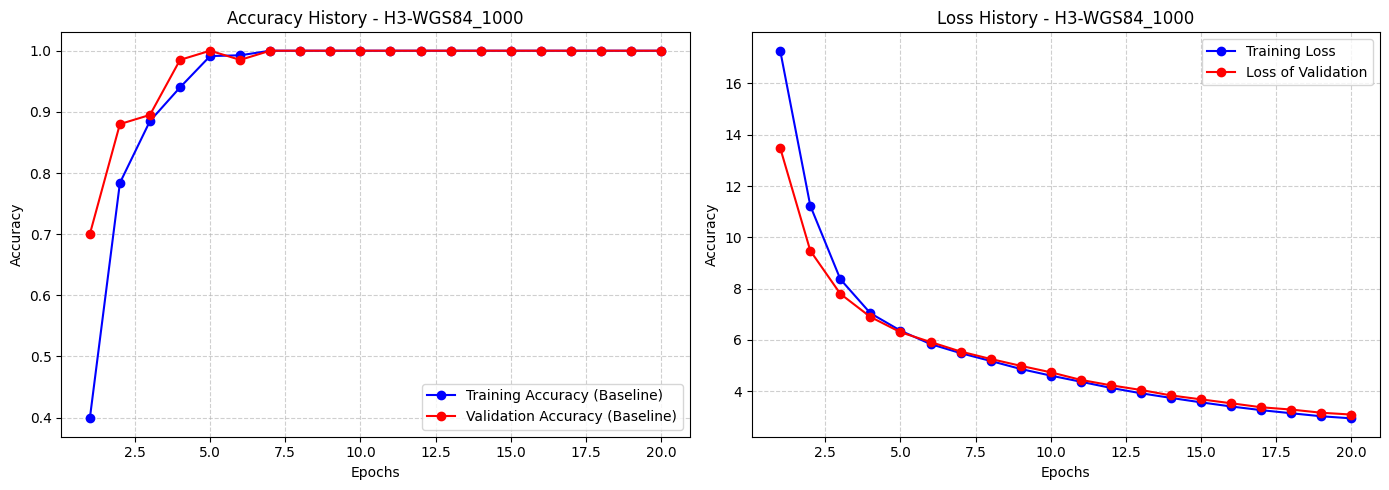

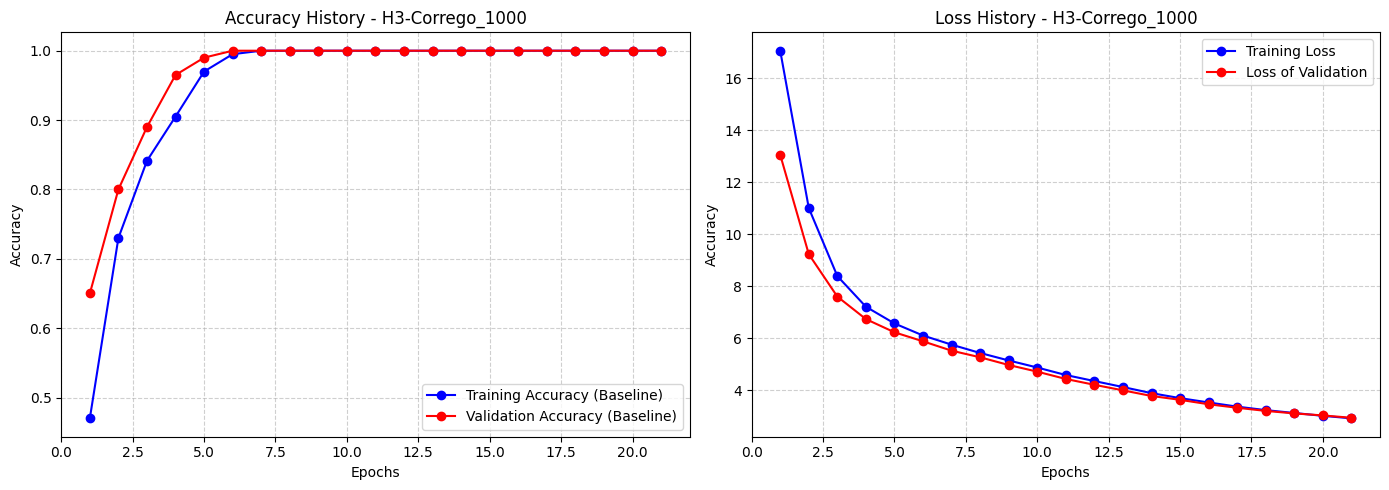

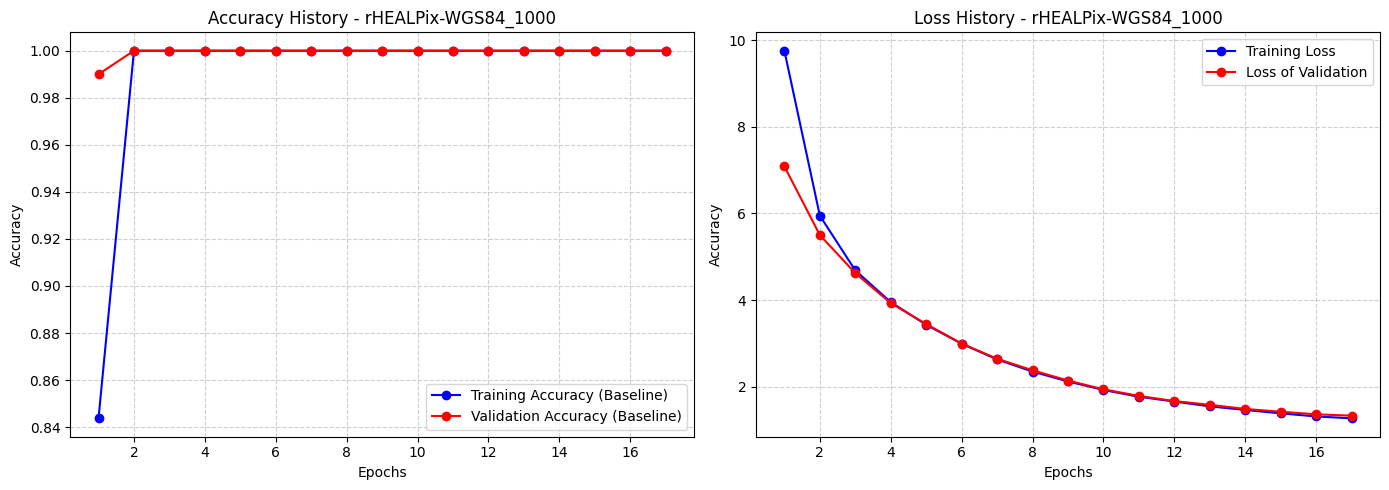

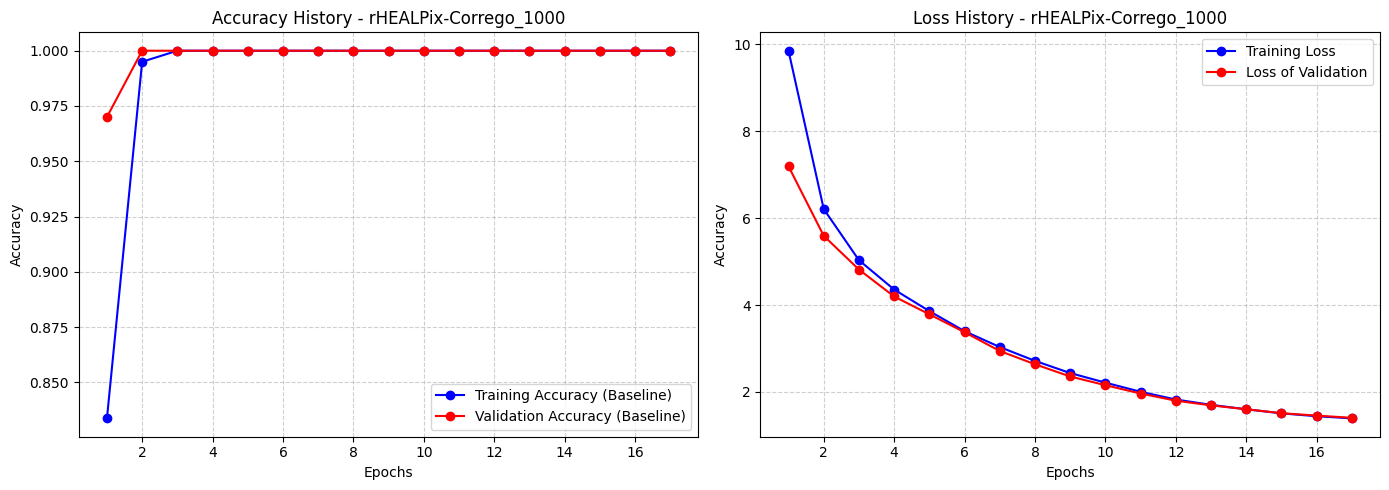

In [23]:
# --- Script Principal para Execução ---
# all_data[0]: 1000 pontos
# all_data[1]: 10000 pontos
# all_data[2]: 100000 pontos
# all_data[3]: 1000000 pontos
data_to_plot = all_data[0] 

# Lista de rótulos correspondente à ordem em que você treinou e salvou os modelos
model_labels = [
    f"H3-WGS84_{data_to_plot.n_points}",
    f"H3-Corrego_{data_to_plot.n_points}",
    f"rHEALPix-WGS84_{data_to_plot.n_points}",
    f"rHEALPix-Corrego_{data_to_plot.n_points}"
]

print(f"[INFO] 📊 Generating historical graphs for training with {data_to_plot.n_points} points...")

# Itera sobre os resultados salvos e plota o histórico de cada um
for i, result in enumerate(data_to_plot.trained_models):
    history = result.get('history')
    label = model_labels[i]
    
    if history:
        plot_training_history(history, label)
    else:
        print(f"[WARNING] No training history found for the model '{label}'.")

10.000 pontos:    sample_index = 1

In [24]:
"""
Treinamento pela amostra

O treinamento é realizada pela amostra (quantidade de pontos) definidos nos elementos de points_list.

O índice de point list se refere à quantidade de pontos:
1000 pontos:    sample_index = 0
10000 pontos:   sample_index = 1
100000 pontos:  sample_index = 2
1000000 pontos: sample_index = 3

"""
sample_index = 1

data_training = all_data[sample_index]

n_points = data_training.n_points

X_H3_WGS84         = data_training.h3_wgs84[1]
y_H3_WGS84         = data_training.h3_wgs84[2]
X_H3_Corrego       = data_training.h3_corrego[1]
y_H3_Corrego       = data_training.h3_corrego[2]
X_rHEALPix_WGS84   = data_training.rhp_wgs84[1]
y_rHEALPix_WGS84   = data_training.rhp_wgs84[2]
X_rHEALPix_Corrego = data_training.rhp_corrego[1]
y_rHEALPix_Corrego = data_training.rhp_corrego[2]

# Inicialização do salvamento dos modelos
if all_data[sample_index].trained_models is not None:
    all_data[sample_index].trained_models.clear()
else:
    all_data[sample_index].trained_models = []

# Laço dos treinamentos por tipo
for label, X, y, tuner in [
    (f"H3-WGS84_{n_points}", X_H3_WGS84, y_H3_WGS84, h3_final_config),
    (f"H3-Corrego_{n_points}", X_H3_Corrego, y_H3_Corrego, h3_final_config),
    (f"rHEALPix-WGS84_{n_points}", X_rHEALPix_WGS84, y_rHEALPix_WGS84, rhp_final_config),
    (f"rHEALPix-Corrego_{n_points}", X_rHEALPix_Corrego, y_rHEALPix_Corrego, rhp_final_config)
]:
    print(f"[INFO] Training {label}")
    model, acc, history_data = train_and_evaluate(X, y, tuner, label)
    # Salvar modelo (em disco)
    model_path = f"trained_{label}.keras"
    model.save(model_path)
    print(f"[INFO] Saved model to {model_path}")
    all_data[sample_index].trained_models.append({
        'model_path': model_path, 
        'accuracy': acc,
        'history': history_data
    })

print(f'\n[INFO] Training for {n_points} points has been completed.\n')

2025-06-21 15:33:36,523 - INFO - Starting: train_and_evaluate


[INFO] Training H3-WGS84_10000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[H3-WGS84_10000] Base accuracy: 0.9995

2025-06-21 15:35:01,496 - INFO - Completed train_and_evaluate in 84.97 seconds



[INFO] Saved model to trained_H3-WGS84_10000.keras
[INFO] Training H3-Corrego_10000


2025-06-21 15:35:01,563 - INFO - Starting: train_and_evaluate


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


2025-06-21 15:36:10,335 - INFO - Completed train_and_evaluate in 68.77 seconds


[H3-Corrego_10000] Base accuracy: 0.9985
[INFO] Saved model to trained_H3-Corrego_10000.keras
[INFO] Training rHEALPix-WGS84_10000


2025-06-21 15:36:10,404 - INFO - Starting: train_and_evaluate


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


2025-06-21 15:36:54,005 - INFO - Completed train_and_evaluate in 43.60 seconds
2025-06-21 15:36:54,069 - INFO - Starting: train_and_evaluate


[rHEALPix-WGS84_10000] Base accuracy: 1.0000
[INFO] Saved model to trained_rHEALPix-WGS84_10000.keras
[INFO] Training rHEALPix-Corrego_10000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


2025-06-21 15:37:36,899 - INFO - Completed train_and_evaluate in 42.83 seconds


[rHEALPix-Corrego_10000] Base accuracy: 1.0000
[INFO] Saved model to trained_rHEALPix-Corrego_10000.keras

[INFO] Training for 10000 points has been completed.



[INFO] 📊 Generating historical graphs for training with 10000 points...


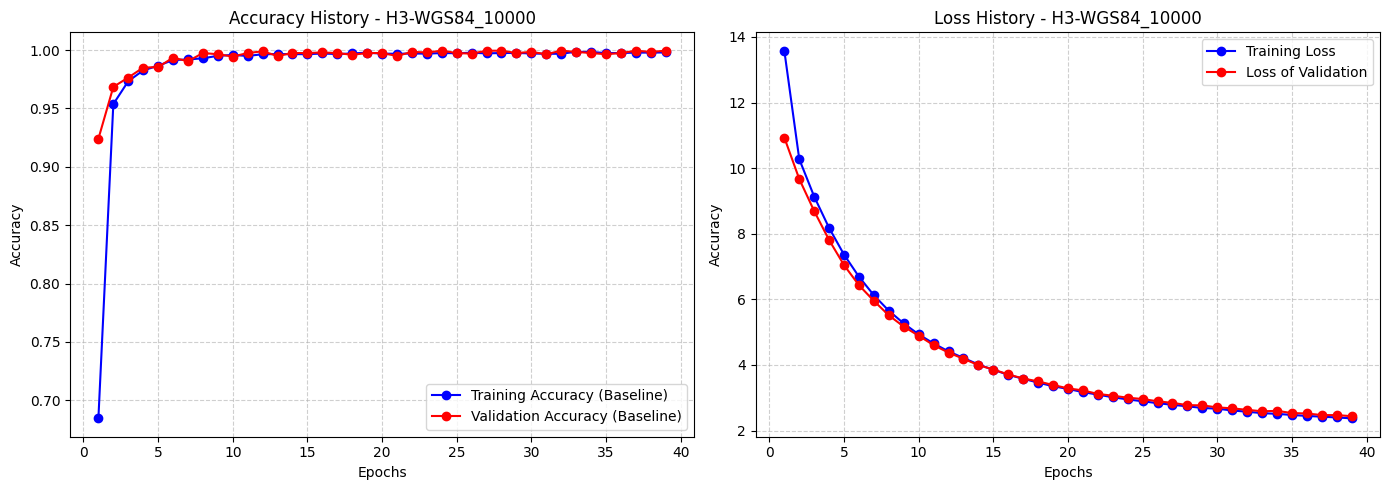

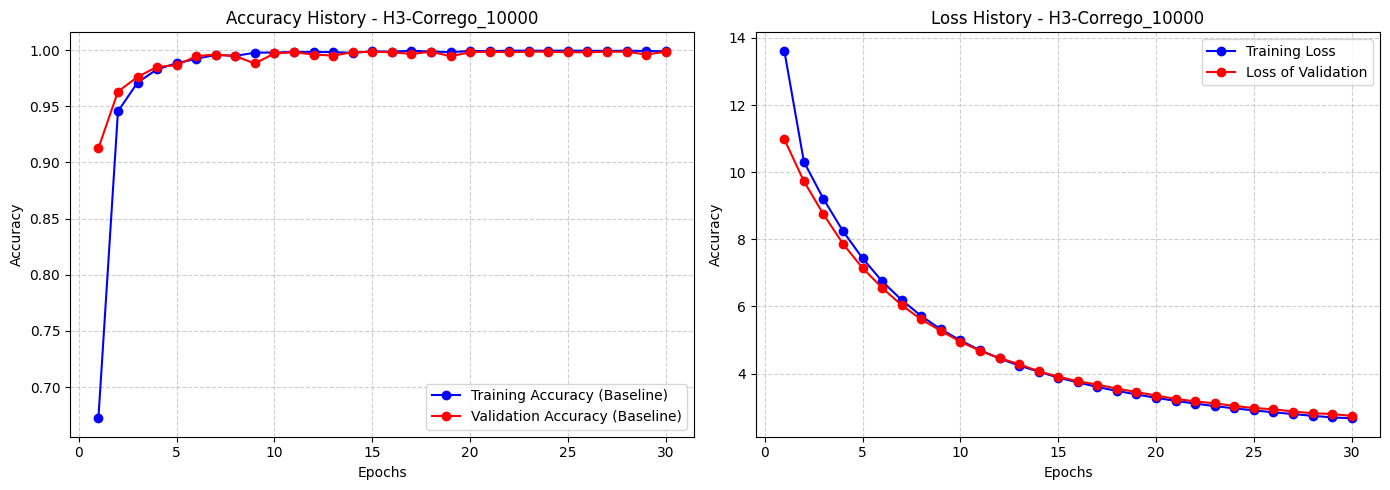

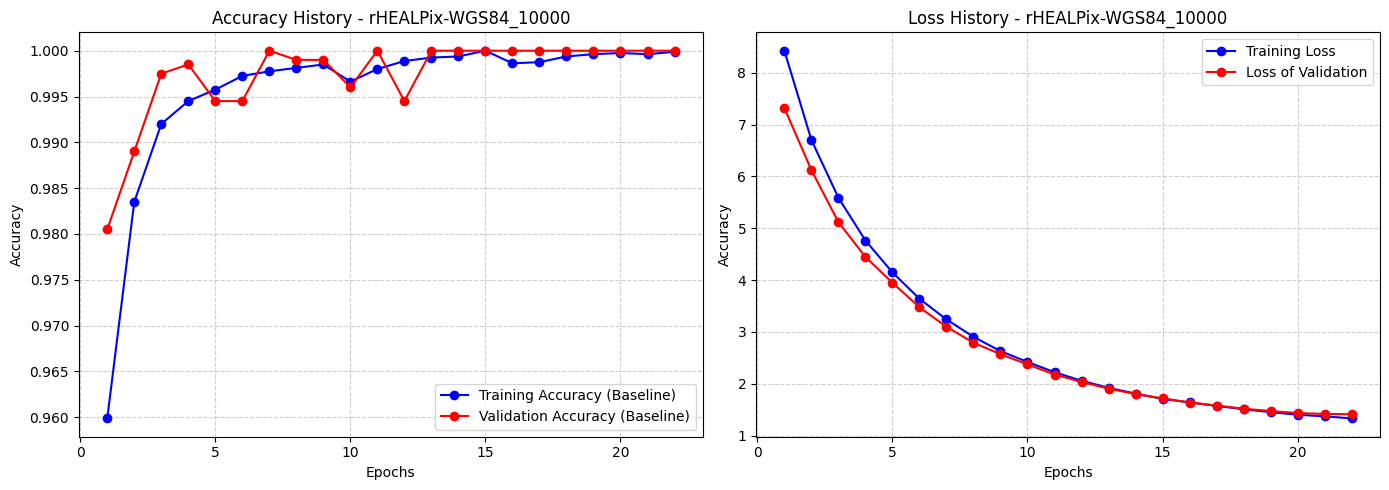

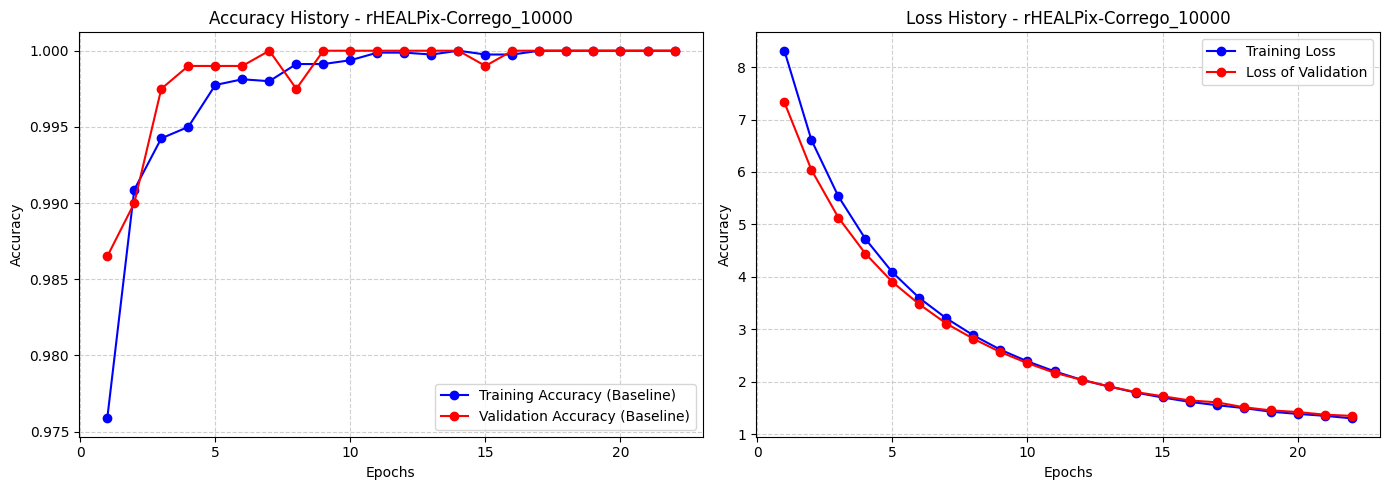

In [25]:
# --- Script Principal para Execução ---
# all_data[0]: 1000 pontos
# all_data[1]: 10000 pontos
# all_data[2]: 100000 pontos
# all_data[3]: 1000000 pontos
data_to_plot = all_data[1] 

# Lista de rótulos correspondente à ordem em que você treinou e salvou os modelos
model_labels = [
    f"H3-WGS84_{data_to_plot.n_points}",
    f"H3-Corrego_{data_to_plot.n_points}",
    f"rHEALPix-WGS84_{data_to_plot.n_points}",
    f"rHEALPix-Corrego_{data_to_plot.n_points}"
]

print(f"[INFO] 📊 Generating historical graphs for training with {data_to_plot.n_points} points...")

# Itera sobre os resultados salvos e plota o histórico de cada um
for i, result in enumerate(data_to_plot.trained_models):
    history = result.get('history')
    label = model_labels[i]
    
    if history:
        plot_training_history(history, label)
    else:
        print(f"[WARNING] No training history found for the model '{label}'.")

100.000 pontos:    sample_index = 2

In [26]:
"""
Treinamento pela amostra

O treinamento é realizada pela amostra (quantidade de pontos) definidos nos elementos de points_list.

O índice de point list se refere à quantidade de pontos:
1000 pontos:    sample_index = 0
10000 pontos:   sample_index = 1
100000 pontos:  sample_index = 2
1000000 pontos: sample_index = 3

"""
sample_index = 2

data_training = all_data[sample_index]

n_points = data_training.n_points

X_H3_WGS84         = data_training.h3_wgs84[1]
y_H3_WGS84         = data_training.h3_wgs84[2]
X_H3_Corrego       = data_training.h3_corrego[1]
y_H3_Corrego       = data_training.h3_corrego[2]
X_rHEALPix_WGS84   = data_training.rhp_wgs84[1]
y_rHEALPix_WGS84   = data_training.rhp_wgs84[2]
X_rHEALPix_Corrego = data_training.rhp_corrego[1]
y_rHEALPix_Corrego = data_training.rhp_corrego[2]

# Inicialização do salvamento dos modelos
if all_data[sample_index].trained_models is not None:
    all_data[sample_index].trained_models.clear()
else:
    all_data[sample_index].trained_models = []

# Laço dos treinamentos por tipo
for label, X, y, tuner in [
    (f"H3-WGS84_{n_points}", X_H3_WGS84, y_H3_WGS84, h3_final_config),
    (f"H3-Corrego_{n_points}", X_H3_Corrego, y_H3_Corrego, h3_final_config),
    (f"rHEALPix-WGS84_{n_points}", X_rHEALPix_WGS84, y_rHEALPix_WGS84, rhp_final_config),
    (f"rHEALPix-Corrego_{n_points}", X_rHEALPix_Corrego, y_rHEALPix_Corrego, rhp_final_config)
]:
    print(f"[INFO] Training {label}")
    model, acc, history_data = train_and_evaluate(X, y, tuner, label)
    # Salvar modelo (em disco)
    model_path = f"trained_{label}.keras"
    model.save(model_path)
    print(f"[INFO] Saved model to {model_path}")
    all_data[sample_index].trained_models.append({
        'model_path': model_path, 
        'accuracy': acc,
        'history': history_data
    })

print(f'\n[INFO] Training for {n_points} points has been completed.\n')

2025-06-21 16:05:38,524 - INFO - Starting: train_and_evaluate


[INFO] Training H3-WGS84_100000
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


2025-06-21 16:33:37,647 - INFO - Completed train_and_evaluate in 1679.12 seconds
2025-06-21 16:33:37,713 - INFO - Starting: train_and_evaluate


[H3-WGS84_100000] Base accuracy: 0.9970
[INFO] Saved model to trained_H3-WGS84_100000.keras
[INFO] Training H3-Corrego_100000
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


2025-06-21 16:56:25,685 - INFO - Completed train_and_evaluate in 1367.97 seconds
2025-06-21 16:56:25,750 - INFO - Starting: train_and_evaluate


[H3-Corrego_100000] Base accuracy: 0.9981
[INFO] Saved model to trained_H3-Corrego_100000.keras
[INFO] Training rHEALPix-WGS84_100000
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


2025-06-21 17:03:12,331 - INFO - Completed train_and_evaluate in 406.58 seconds
2025-06-21 17:03:12,393 - INFO - Starting: train_and_evaluate


[rHEALPix-WGS84_100000] Base accuracy: 0.9999
[INFO] Saved model to trained_rHEALPix-WGS84_100000.keras
[INFO] Training rHEALPix-Corrego_100000
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


2025-06-21 17:10:26,411 - INFO - Completed train_and_evaluate in 434.02 seconds


[rHEALPix-Corrego_100000] Base accuracy: 1.0000
[INFO] Saved model to trained_rHEALPix-Corrego_100000.keras

[INFO] Training for 100000 points has been completed.



[INFO] 📊 Generating historical graphs for training with 100000 points...


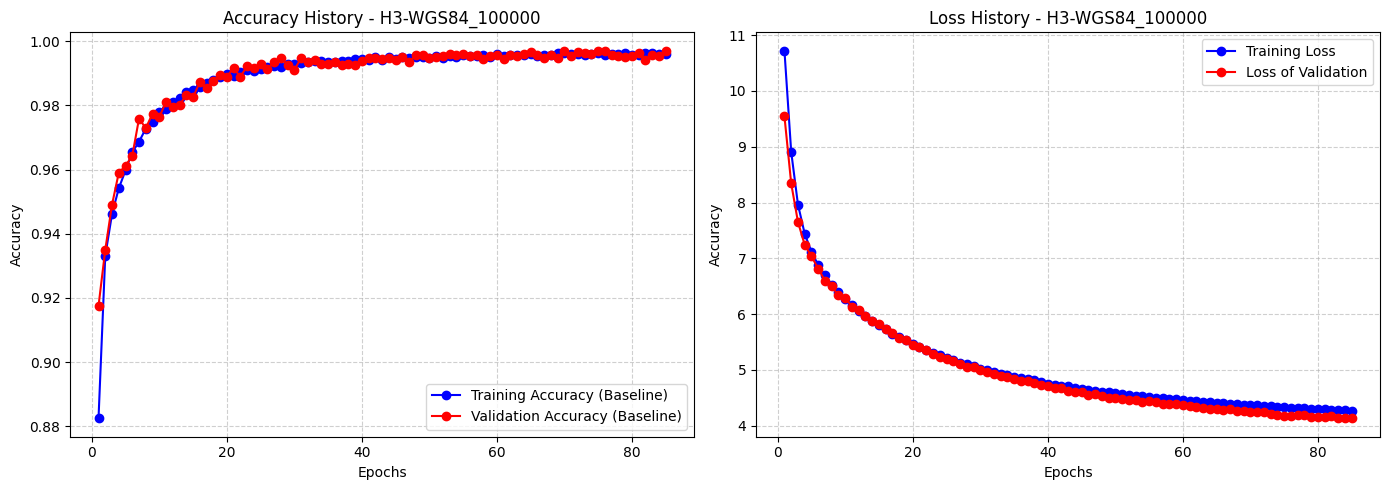

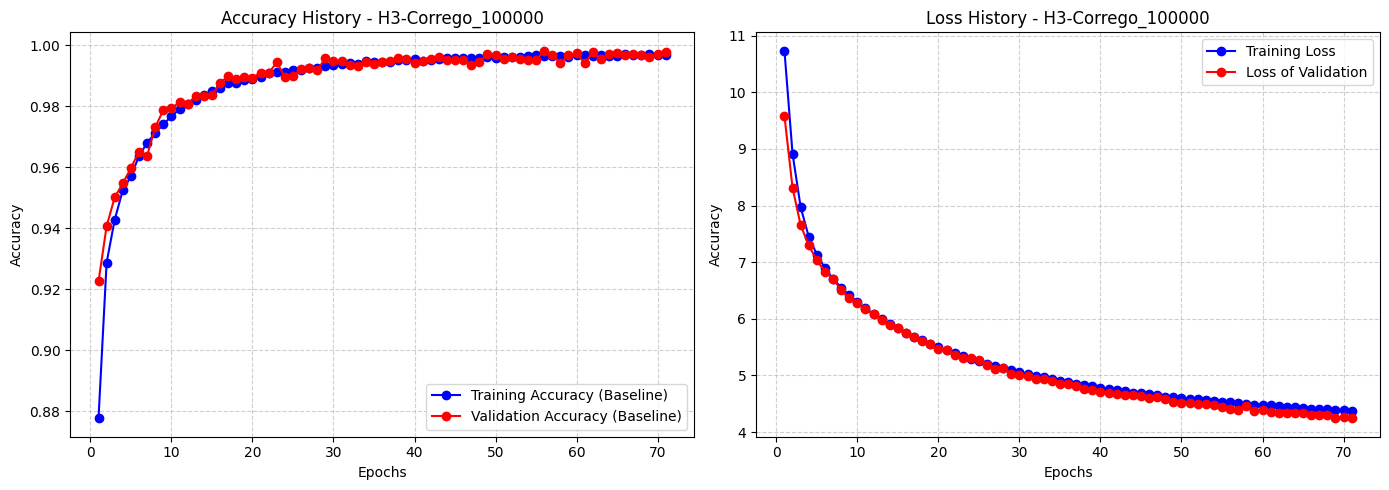

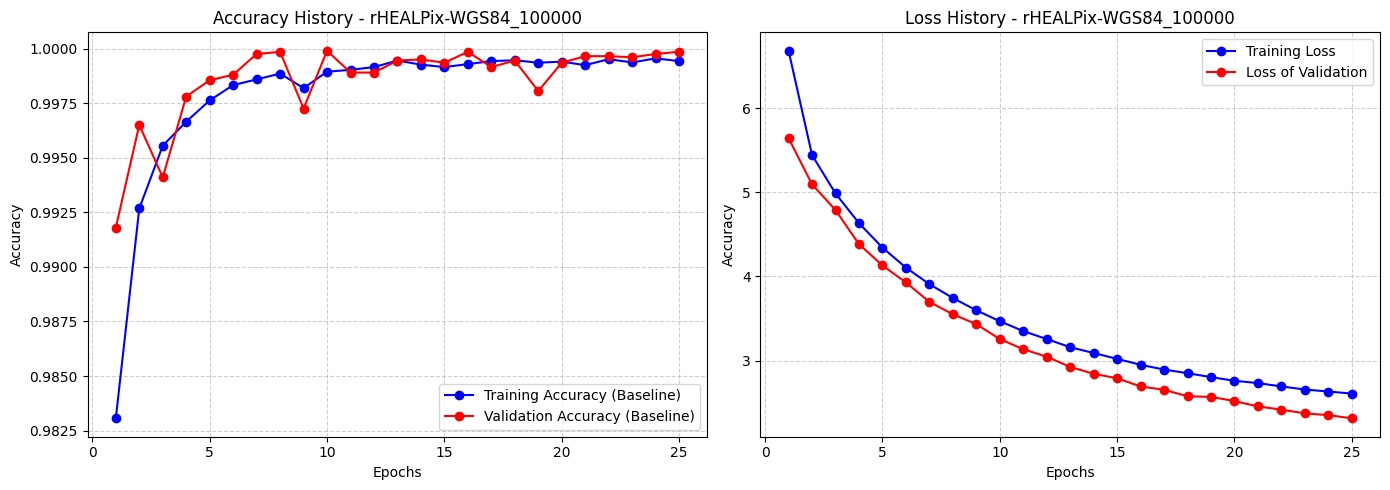

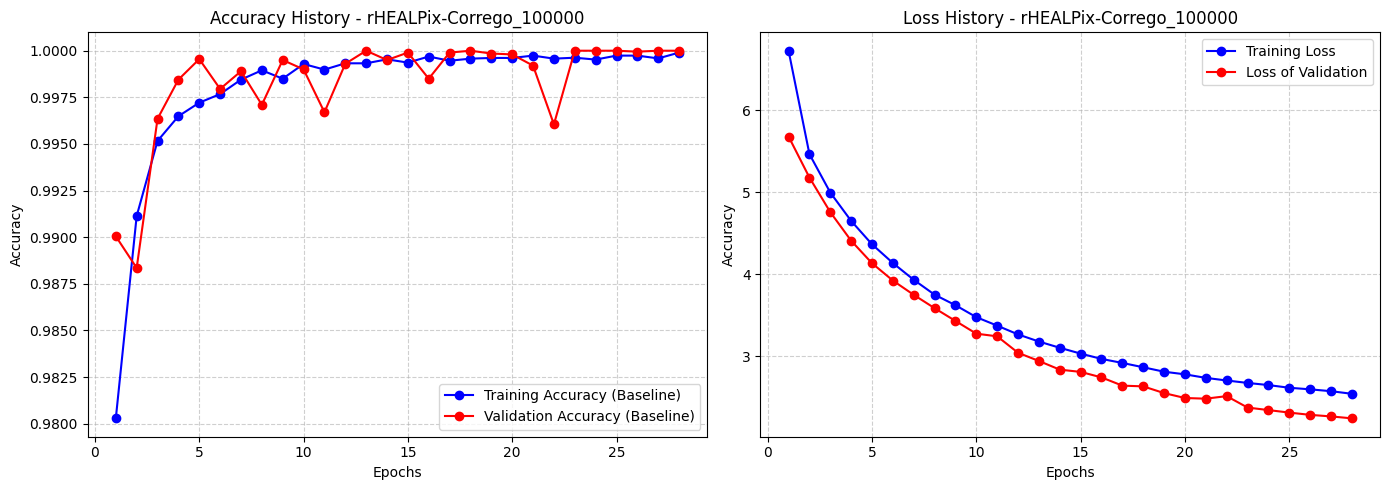

In [27]:
# --- Script Principal para Execução ---
# all_data[0]: 1000 pontos
# all_data[1]: 10000 pontos
# all_data[2]: 100000 pontos
# all_data[3]: 1000000 pontos
data_to_plot = all_data[2] 

# Lista de rótulos correspondente à ordem em que você treinou e salvou os modelos
model_labels = [
    f"H3-WGS84_{data_to_plot.n_points}",
    f"H3-Corrego_{data_to_plot.n_points}",
    f"rHEALPix-WGS84_{data_to_plot.n_points}",
    f"rHEALPix-Corrego_{data_to_plot.n_points}"
]

print(f"[INFO] 📊 Generating historical graphs for training with {data_to_plot.n_points} points...")

# Itera sobre os resultados salvos e plota o histórico de cada um
for i, result in enumerate(data_to_plot.trained_models):
    history = result.get('history')
    label = model_labels[i]
    
    if history:
        plot_training_history(history, label)
    else:
        print(f"[WARNING] No training history found for the model '{label}'.")

1.000.000 pontos:    sample_index = 3

In [28]:
"""
Treinamento pela amostra

O treinamento é realizada pela amostra (quantidade de pontos) definidos nos elementos de points_list.

O índice de point list se refere à quantidade de pontos:
1000 pontos:    sample_index = 0
10000 pontos:   sample_index = 1
100000 pontos:  sample_index = 2
1000000 pontos: sample_index = 3

"""
sample_index = 3

data_training = all_data[sample_index]

n_points = data_training.n_points

X_H3_WGS84         = data_training.h3_wgs84[1]
y_H3_WGS84         = data_training.h3_wgs84[2]
X_H3_Corrego       = data_training.h3_corrego[1]
y_H3_Corrego       = data_training.h3_corrego[2]
X_rHEALPix_WGS84   = data_training.rhp_wgs84[1]
y_rHEALPix_WGS84   = data_training.rhp_wgs84[2]
X_rHEALPix_Corrego = data_training.rhp_corrego[1]
y_rHEALPix_Corrego = data_training.rhp_corrego[2]

# Inicialização do salvamento dos modelos
if all_data[sample_index].trained_models is not None:
    all_data[sample_index].trained_models.clear()
else:
    all_data[sample_index].trained_models = []

# Laço dos treinamentos por tipo
for label, X, y, tuner in [
    (f"H3-WGS84_{n_points}", X_H3_WGS84, y_H3_WGS84, h3_final_config),
    (f"H3-Corrego_{n_points}", X_H3_Corrego, y_H3_Corrego, h3_final_config),
    (f"rHEALPix-WGS84_{n_points}", X_rHEALPix_WGS84, y_rHEALPix_WGS84, rhp_final_config),
    (f"rHEALPix-Corrego_{n_points}", X_rHEALPix_Corrego, y_rHEALPix_Corrego, rhp_final_config)
]:
    print(f"[INFO] Training {label}")
    model, acc, history_data = train_and_evaluate(X, y, tuner, label)
    # Salvar modelo (em disco)
    model_path = f"trained_{label}.keras"
    model.save(model_path)  
    print(f"[INFO] Saved model to {model_path}")
    all_data[sample_index].trained_models.append({
        'model_path': model_path, 
        'accuracy': acc,
        'history': history_data
    })

print(f'\n[INFO] Training for {n_points} points has been completed.\n')

2025-06-21 17:31:35,815 - INFO - Starting: train_and_evaluate


[INFO] Training H3-WGS84_1000000
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step


2025-06-21 23:30:34,435 - INFO - Completed train_and_evaluate in 21538.62 seconds
2025-06-21 23:30:34,502 - INFO - Starting: train_and_evaluate


[H3-WGS84_1000000] Base accuracy: 0.9733
[INFO] Saved model to trained_H3-WGS84_1000000.keras
[INFO] Training H3-Corrego_1000000
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


2025-06-22 03:45:04,019 - INFO - Completed train_and_evaluate in 15269.52 seconds
2025-06-22 03:45:04,099 - INFO - Starting: train_and_evaluate


[H3-Corrego_1000000] Base accuracy: 0.9735
[INFO] Saved model to trained_H3-Corrego_1000000.keras
[INFO] Training rHEALPix-WGS84_1000000
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


2025-06-22 05:44:44,567 - INFO - Completed train_and_evaluate in 7180.47 seconds
2025-06-22 05:44:44,631 - INFO - Starting: train_and_evaluate


[rHEALPix-WGS84_1000000] Base accuracy: 0.9993
[INFO] Saved model to trained_rHEALPix-WGS84_1000000.keras
[INFO] Training rHEALPix-Corrego_1000000
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step


2025-06-22 07:35:01,377 - INFO - Completed train_and_evaluate in 6616.74 seconds


[rHEALPix-Corrego_1000000] Base accuracy: 0.9994
[INFO] Saved model to trained_rHEALPix-Corrego_1000000.keras

[INFO] Training for 1000000 points has been completed.



[INFO] 📊 Generating historical graphs for training with 1000000 points...


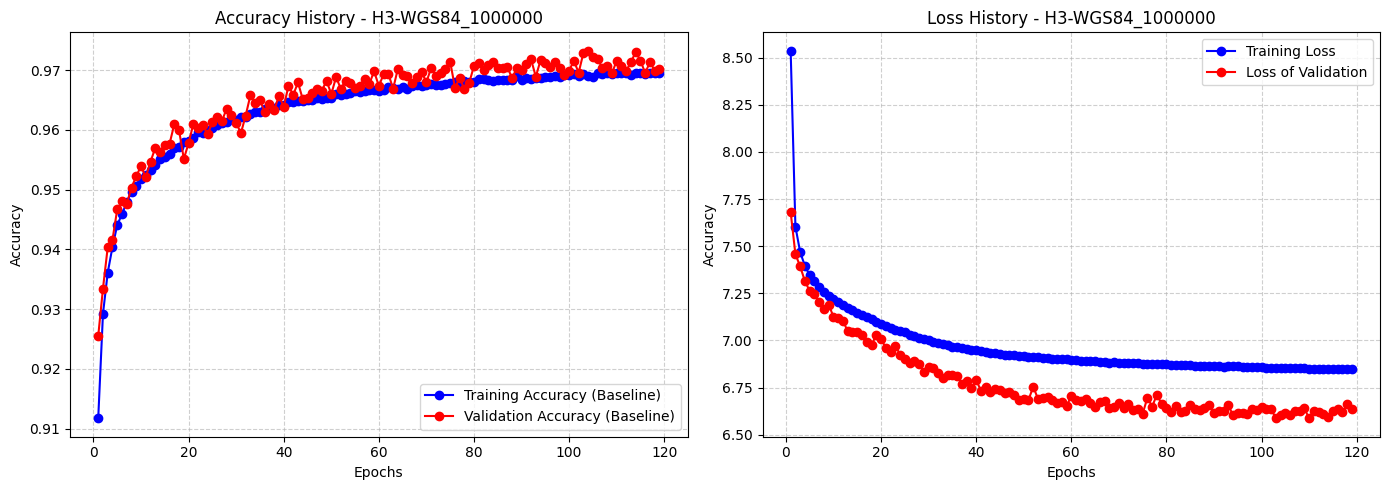

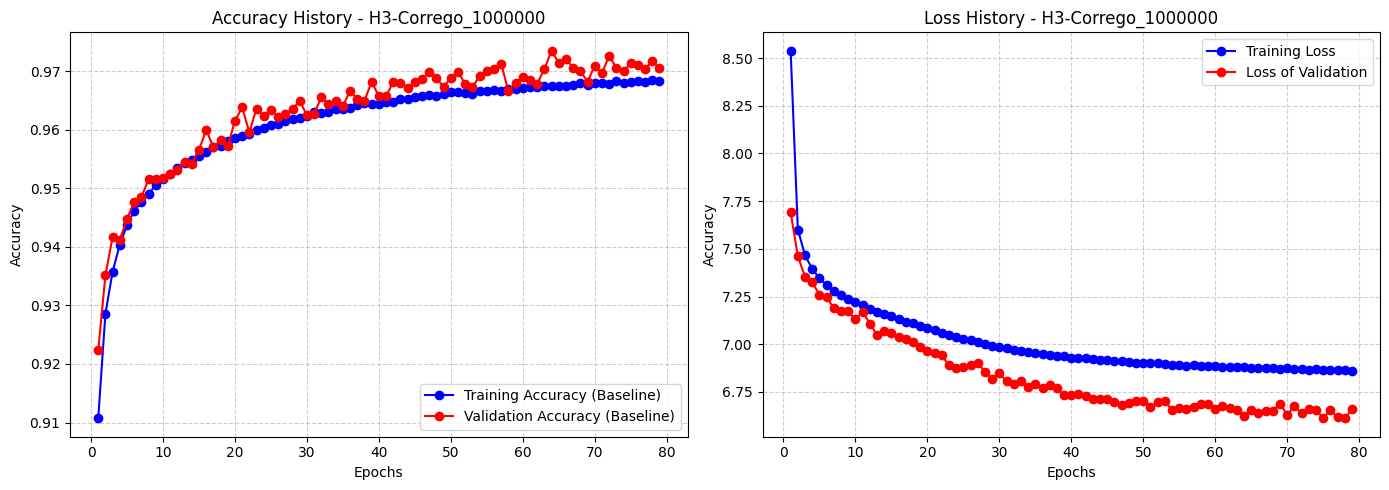

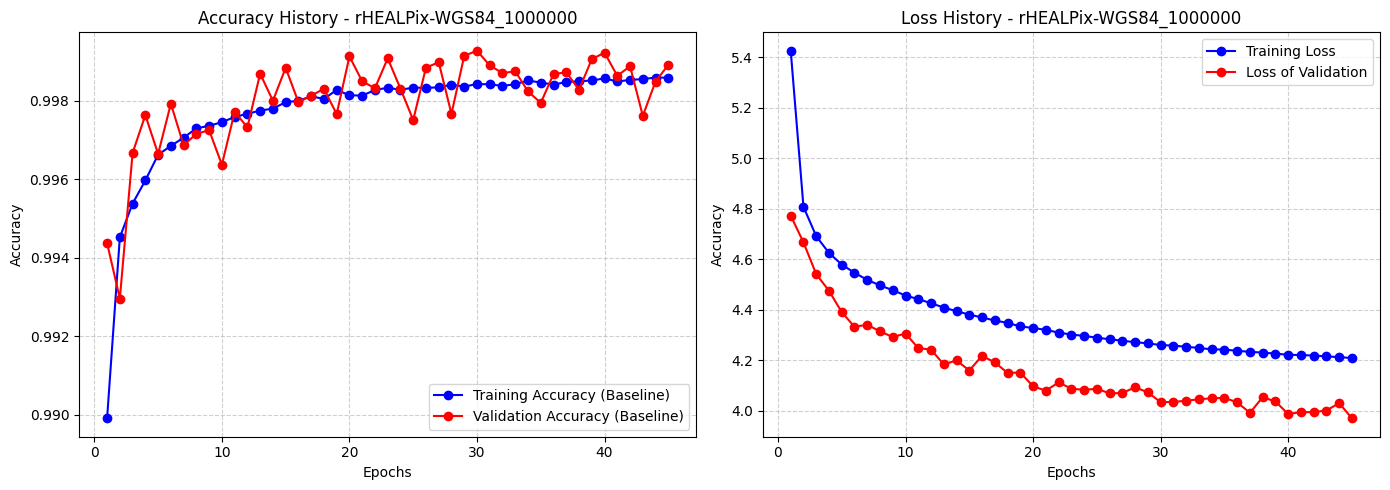

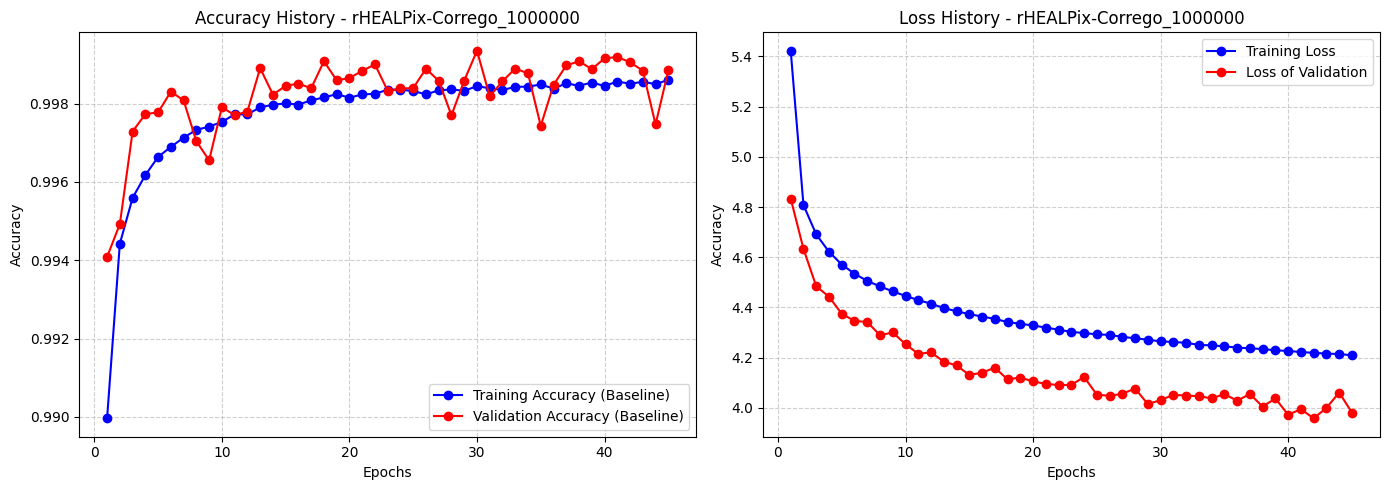

In [29]:
# --- Script Principal para Execução ---
# all_data[0]: 1000 pontos
# all_data[1]: 10000 pontos
# all_data[2]: 100000 pontos
# all_data[3]: 1000000 pontos
data_to_plot = all_data[3] 

# Lista de rótulos correspondente à ordem em que você treinou e salvou os modelos
model_labels = [
    f"H3-WGS84_{data_to_plot.n_points}",
    f"H3-Corrego_{data_to_plot.n_points}",
    f"rHEALPix-WGS84_{data_to_plot.n_points}",
    f"rHEALPix-Corrego_{data_to_plot.n_points}"
]

print(f"[INFO] 📊 Generating historical graphs for training with {data_to_plot.n_points} points...")

# Itera sobre os resultados salvos e plota o histórico de cada um
for i, result in enumerate(data_to_plot.trained_models):
    history = result.get('history')
    label = model_labels[i]
    
    if history:
        plot_training_history(history, label)
    else:
        print(f"[WARNING] No training history found for the model '{label}'.")

Salvar histórico em txt

In [30]:
import pandas as pd
import numpy as np
import os

@log_time_v2
def save_histories_to_txt(all_data_list, output_dir="training_histories"):
    """
    Itera sobre a lista 'all_data', extrai o histórico de treinamento de cada modelo
    e o salva em um arquivo .txt formatado como tabela com separação por tabulação.

    Args:
        all_data_list (list): A lista contendo objetos DataPerSample.
        output_dir (str): O nome do diretório onde os arquivos serão salvos.
    """
    # Cria o diretório de saída se ele não existir
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"[INFO] Created directory: {output_dir}")

    # Itera sobre cada conjunto de dados (1k, 10k, 100k pontos, etc.)
    for data_per_sample in all_data_list:
        n_points = data_per_sample.n_points
        training_results = data_per_sample.trained_models
        
        # Define os rótulos dos modelos na ordem em que foram treinados
        model_labels = [
            f"H3-WGS84_{n_points}",
            f"H3-Corrego_{n_points}",
            f"rHEALPix-WGS84_{n_points}",
            f"rHEALPix-Corrego_{n_points}"
        ]

        # Verifica se há modelos treinados para este tamanho de amostra
        if not training_results:
            print(f"[INFO] No trained models found for n_points = {n_points}. Skipping.")
            continue
            
        print(f"\n[INFO] Saving histories for n_points = {n_points}...")

        # Itera sobre cada modelo treinado e salva seu histórico
        for i, result in enumerate(training_results):
            model_label = model_labels[i]
            history_dict = result.get('history')
            
            if history_dict:
                try:
                    # Converte o dicionário de histórico para um DataFrame do Pandas
                    df = pd.DataFrame(history_dict)
                    
                    # Adiciona uma coluna de épocas para facilitar a leitura
                    df.insert(0, 'epoch', range(1, len(df) + 1))
                    
                    # Define o caminho do arquivo de saída
                    output_path = os.path.join(output_dir, f"history_{model_label}.txt")
                    
                    # Salva o DataFrame em um arquivo .txt com separação por tabulação
                    df.to_csv(output_path, sep='\t', index=False, float_format='%.6f')
                    
                    print(f"  ✅ Saved history for {model_label} to {output_path}")
                except Exception as e:
                    print(f"  ❌ ERROR saving history for {model_label}: {e}")
            else:
                print(f"  ⚠️ WARNING: No history found for model '{model_label}'.")

# --- Script Principal para Execução ---
save_histories_to_txt(all_data)

2025-06-22 13:55:02,701 - INFO - Starting: save_histories_to_txt
2025-06-22 13:55:02,792 - INFO - Completed save_histories_to_txt in 0.09 seconds


[INFO] Created directory: training_histories

[INFO] Saving histories for n_points = 1000...
  ✅ Saved history for H3-WGS84_1000 to training_histories\history_H3-WGS84_1000.txt
  ✅ Saved history for H3-Corrego_1000 to training_histories\history_H3-Corrego_1000.txt
  ✅ Saved history for rHEALPix-WGS84_1000 to training_histories\history_rHEALPix-WGS84_1000.txt
  ✅ Saved history for rHEALPix-Corrego_1000 to training_histories\history_rHEALPix-Corrego_1000.txt

[INFO] Saving histories for n_points = 10000...
  ✅ Saved history for H3-WGS84_10000 to training_histories\history_H3-WGS84_10000.txt
  ✅ Saved history for H3-Corrego_10000 to training_histories\history_H3-Corrego_10000.txt
  ✅ Saved history for rHEALPix-WGS84_10000 to training_histories\history_rHEALPix-WGS84_10000.txt
  ✅ Saved history for rHEALPix-Corrego_10000 to training_histories\history_rHEALPix-Corrego_10000.txt

[INFO] Saving histories for n_points = 100000...
  ✅ Saved history for H3-WGS84_100000 to training_histories\hist

### 2.4 Registro das métricas

#### Teste de sanidade dos modelos

Rodar as funções auxiliares reconstruct_h3_index_safe reconstruct_rhealpix_index_safe antes de executar

In [42]:
def fourier_axis(value, n_freqs=10):
    """
    Vetoriza Fourier Features para um único valor de eixo (lat ou lon).
    """
    value_rad = np.radians(value)
    k = np.arange(1, n_freqs + 1)
    sin = np.sin(value_rad * k)
    cos = np.cos(value_rad * k)
    return np.hstack([sin, cos])
    
def predict_and_compare(model_path, lat, lon, res, dggs_type, crs='WGS84', n_freqs=10):
    """
    Carrega um modelo Keras treinado, faz uma predição para uma única coordenada
    e compara o resultado com o valor real.

    Args:
        model_path (str): Caminho para o arquivo .keras do modelo salvo.
        lat (float): Latitude da coordenada de entrada.
        lon (float): Longitude da coordenada de entrada.
        res (int): Nível de resolução DGGS alvo.
        dggs_type (str): 'H3' ou 'rHEALPix'.
        crs (str): 'WGS84' ou 'CÓRREGO ALEGRE'.
        n_freqs (int): Número de frequências usado para as Fourier Features (deve ser o mesmo do treino).
    """
    print("=" * 80)
    print(f"🔬 Testando Modelo: {model_path}")
    print(f"   Entrada: Lat={lat}, Lon={lon}, Res={res}, CRS={crs}, DGGS={dggs_type}")
    print("=" * 80)

    # 1. Carregar o modelo
    try:
        model = keras.models.load_model(model_path, compile=False)
        print("[INFO] Modelo carregado com sucesso.")
    except Exception as e:
        print(f"[ERRO] Falha ao carregar o modelo: {e}")
        return

    # 2. Preparar o vetor de entrada (X) com Fourier Features
    ff_lat = fourier_axis(lat, n_freqs)
    ff_lon = fourier_axis(lon, n_freqs)
    # Normalizar a resolução, como no treinamento.
    normalized_res = res / 15.0
    
    # Concatena as features e a resolução
    input_vector = np.hstack([ff_lat, ff_lon, [normalized_res]]).astype(np.float32)
    
    # Ajusta o shape para o formato esperado pelo Keras (batch de 1 amostra)
    input_vector_batch = np.expand_dims(input_vector, axis=0)
    print(f"[INFO] Vetor de entrada preparado com shape: {input_vector_batch.shape}")

    # 3. Fazer a predição
    y_pred_dict = model.predict(input_vector_batch, verbose=0)

    # 4. Decodificar a saída do modelo
    # Acessa o dicionário pela chave de string 'base'
    pred_base = np.argmax(y_pred_dict['base'], axis=1)[0]
    # Itera corretamente para obter os dígitos usando as chaves de string
    pred_digits = [np.argmax(y_pred_dict[f'digit_{i}'], axis=1)[0] for i in range(1, res + 1)]

    # 5. Calcular a "Verdade Terrestre" (Ground Truth) para comparação
    true_base, true_digits = (
        latlon_to_h3_components(lat, lon, res, crs) if dggs_type.upper() == 'H3'
        else latlon_to_rhealpix_components(lat, lon, res, crs)
    )

    # 6. Reconstruir os índices completos
    if dggs_type.upper() == 'H3':
        predicted_index = reconstruct_h3_index_safe(pred_base, pred_digits, res)
        true_index = reconstruct_h3_index_safe(true_base, true_digits, res)
    else:
        dg = dggs.RHEALPixDGGS()
        predicted_index = reconstruct_rhealpix_index_safe(pred_base, pred_digits, res, dg)
        true_index = reconstruct_rhealpix_index_safe(true_base, true_digits, res, dg)
        
    # 7. Apresentar os resultados
    print("\n--- Resultado da Predição ---")
    print(f"Componentes Previstos:   Base={pred_base}, Dígitos={pred_digits}")
    print(f"Índice DGGS Previsto:    {predicted_index}")
    print("\n--- Valor Real (Ground Truth) ---")
    print(f"Componentes Reais:       Base={true_base}, Dígitos={true_digits}")
    print(f"Índice DGGS Real:        {true_index}")
    
    print("\n--- Comparação ---")
    if predicted_index == true_index:
        print("✅ SUCESSO: O índice previsto corresponde ao índice real.")
    else:
        print("❌ FALHA: O índice previsto é diferente do real.")
    print("=" * 80 + "\n")

# ==============================================================================
# SEÇÃO 3: BLOCO DE EXECUÇÃO DE EXEMPLO
# ==============================================================================
if __name__ == '__main__':
    # --- 1. SELEÇÃO DO MODELO ---
    # Altere APENAS esta linha para escolher qual modelo testar.
    # Opções disponíveis: "h3_wgs84", "h3_corrego", "rhp_wgs84", "rhp_corrego"
    MODEL_KEY_TO_TEST = "rhp_wgs84"
    
    # --- 2. CONFIGURAÇÕES DOS MODELOS ---
    # Todas as configurações ficam centralizadas aqui.
    # Adicione ou altere os caminhos para seus modelos de 1_000, 10_000, 100_000 ou 1_000_000.
    N_POINTS = 1_000_000 # Altere aqui o tamanho do dataset que quer testar

    MODEL_CONFIGURATIONS = {
        "h3_wgs84": {
            "path": f"trained_H3-WGS84_{N_POINTS}.keras",
            "dggs": "H3",
            "crs": "WGS84"
        },
        "h3_corrego": {
            "path": f"trained_H3-Corrego_{N_POINTS}.keras",
            "dggs": "H3",
            "crs": "CÓRREGO ALEGRE"
        },
        "rhp_wgs84": {
            "path": f"trained_rHEALPix-WGS84_{N_POINTS}.keras",
            "dggs": "rHEALPix",
            "crs": "WGS84"
        },
        "rhp_corrego": {
            "path": f"trained_rHEALPix-Corrego_{N_POINTS}.keras",
            "dggs": "rHEALPix",
            "crs": "CÓRREGO ALEGRE"
        }
    }

    # --- 3. PARÂMETROS GERAIS DO TESTE ---
    # O número de frequências deve ser o mesmo usado no treinamento
    N_FREQS_TRAINING = 5 
    
    # Coordenadas de teste
    TEST_LAT = -23.1791
    TEST_LON = -45.8872
    TEST_RES = 10
    
    # --- 4. EXECUÇÃO DO TESTE ---
    # O código abaixo seleciona a configuração correta automaticamente
    try:
        # Pega a configuração escolhida do dicionário
        config = MODEL_CONFIGURATIONS[MODEL_KEY_TO_TEST.lower()]

        print(f"\n[INFO] Configuração selecionada: {MODEL_KEY_TO_TEST}")
        
        predict_and_compare(
            model_path=config['path'],
            lat=TEST_LAT,
            lon=TEST_LON,
            res=TEST_RES,
            dggs_type=config['dggs'],
            crs=config['crs'],
            n_freqs=N_FREQS_TRAINING
        )

    except KeyError:
        print(f"\n[ERRO FATAL] A chave de modelo '{MODEL_KEY_TO_TEST}' é inválida.")
        print(f"    Opções válidas são: {list(MODEL_CONFIGURATIONS.keys())}")
    except FileNotFoundError:
        print(f"\n[ERRO FATAL] O arquivo do modelo '{config['path']}' não foi encontrado.")
        print("                 Certifique-se de que o modelo treinado está no diretório correto.")
    except Exception as e:
        print(f"\n[ERRO FATAL] Ocorreu um erro inesperado: {e}")



[INFO] Configuração selecionada: rhp_wgs84
🔬 Testando Modelo: trained_rHEALPix-WGS84_1000000.keras
   Entrada: Lat=-23.1791, Lon=-45.8872, Res=10, CRS=WGS84, DGGS=rHEALPix
[INFO] Modelo carregado com sucesso.
[INFO] Vetor de entrada preparado com shape: (1, 21)

--- Resultado da Predição ---
Componentes Previstos:   Base=2, Dígitos=[np.int64(7), np.int64(4), np.int64(1), np.int64(3), np.int64(3), np.int64(2), np.int64(6), np.int64(2), np.int64(6), np.int64(6)]
Índice DGGS Previsto:    P7413326266

--- Valor Real (Ground Truth) ---
Componentes Reais:       Base=2, Dígitos=[7, 4, 1, 3, 2, 6, 6, 8, 2, 1]
Índice DGGS Real:        P7413266821

--- Comparação ---
❌ FALHA: O índice previsto é diferente do real.



#### Criação de dados de teste independentes

In [49]:
# Quantidade de Pontos
n_points = 10_000

# Geração de fragmentos para WGS84
print('[INFO] Initializing generation of coordinate image fragments for H3 DGGS for WGS84')
dataset_H3_WGS84 = generate_image_points(n_points=n_points, dggs='H3', res_range=(7, 15), crs='WGS84')
print('[INFO] Initializing generation of coordinate image fragments for H3 DGGS for Corrego Alegre')
dataset_H3_Corrego = generate_image_points(n_points=n_points, dggs='H3', res_range=(7, 15), crs='CÓRREGO ALEGRE')
print('[INFO] Initializing generation of coordinate image fragments for rHEALPix DGGS for WGS84')
dataset_rHEALPix_WGS84 = generate_image_points(n_points=n_points, dggs='rHEALPix', res_range=(7, 15), crs='WGS84')
print('[INFO] Initializing generation of coordinate image fragments for rHEALPix DGGS for Corrego Alegre')
dataset_rHEALPix_Corrego = generate_image_points(n_points=n_points, dggs='rHEALPix', res_range=(7, 15), crs='CÓRREGO ALEGRE')

# Construção das entradas para MLP
print('[INFO] Normalizing coordinate image fragments with Fourier Features')
X_H3_WGS84, y_H3_WGS84 = dataset_H3_WGS84.get_X_y('H3')
X_H3_Corrego, y_H3_Corrego = dataset_H3_Corrego.get_X_y('H3')
X_rHEALPix_WGS84, y_rHEALPix_WGS84 = dataset_rHEALPix_WGS84.get_X_y('rHEALPix')
X_rHEALPix_Corrego, y_rHEALPix_Corrego = dataset_rHEALPix_Corrego.get_X_y('rHEALPix')

2025-06-22 16:49:07,829 - INFO - Starting: generate_image_points
2025-06-22 16:49:07,917 - INFO - Completed generate_image_points in 0.09 seconds
2025-06-22 16:49:07,917 - INFO - Starting: generate_image_points


[INFO] Initializing generation of coordinate image fragments for H3 DGGS for WGS84
[INFO] Initializing generation of coordinate image fragments for H3 DGGS for Corrego Alegre


2025-06-22 16:49:08,018 - INFO - Completed generate_image_points in 0.10 seconds
2025-06-22 16:49:08,019 - INFO - Starting: generate_image_points


[INFO] Initializing generation of coordinate image fragments for rHEALPix DGGS for WGS84


2025-06-22 16:49:08,525 - INFO - Completed generate_image_points in 0.51 seconds
2025-06-22 16:49:08,526 - INFO - Starting: generate_image_points


[INFO] Initializing generation of coordinate image fragments for rHEALPix DGGS for Corrego Alegre


2025-06-22 16:49:09,037 - INFO - Completed generate_image_points in 0.51 seconds
2025-06-22 16:49:09,038 - INFO - Starting: build_X_y
2025-06-22 16:49:09,097 - INFO - Completed build_X_y in 0.06 seconds
2025-06-22 16:49:09,098 - INFO - Starting: build_X_y
2025-06-22 16:49:09,154 - INFO - Completed build_X_y in 0.06 seconds
2025-06-22 16:49:09,154 - INFO - Starting: build_X_y
2025-06-22 16:49:09,210 - INFO - Completed build_X_y in 0.06 seconds


[INFO] Normalizing coordinate image fragments with Fourier Features


2025-06-22 16:49:09,211 - INFO - Starting: build_X_y
2025-06-22 16:49:09,267 - INFO - Completed build_X_y in 0.06 seconds


#### Funções auxiliares para avaliação

In [15]:
# !pip install geopy
# !pip install tqdn

In [37]:
import pandas as pd
import numpy as np
from tensorflow import keras
import h3
from rhealpixdggs import dggs
from geopy.distance import geodesic
from tqdm import tqdm
import warnings

# Suprime os avisos de formatação do Keras que podem poluir a saída
warnings.filterwarnings("ignore", category=UserWarning)

def get_latitude_band(lat):
    """Categoriza uma latitude em bandas Polar, Média ou Equatorial."""
    LAT_BOUNDARY_1 = 19.47 # 1/3 da área do hemisfério
    LAT_BOUNDARY_2 = 41.81 # 2/3 da área do hemisfério
    abs_lat = abs(lat)
    if abs_lat > LAT_BOUNDARY_2:
        return 'Polar (Area-Equal)'
    elif abs_lat > LAT_BOUNDARY_1:
        return 'Mid-latitude (Area-Equal)'
    else:
        return 'Equatorial (Area-Equal)'

# Pré-calcula um mapa de número de célula base para string H3 para eficiência
BASE_CELL_TO_H3_STRING_MAP = {h3.get_base_cell_number(cell): cell for cell in h3.get_res0_cells()}

def reconstruct_h3_index_safe(base, digits, res):
    """
    Reconstrói um índice H3 de forma segura a partir de seus componentes.
    Retorna None se a reconstrução falhar.
    """
    try:
        # Pega a string da célula base a partir do número usando o mapa pré-calculado
        reconstructed_index = BASE_CELL_TO_H3_STRING_MAP.get(base)
        if reconstructed_index is None:
            print("[ERROR] Predicted base cell invalid")
            return None # Célula base prevista é inválida

        # Navega pela hierarquia usando os dígitos
        for i in range(res):
            children = h3.cell_to_children(reconstructed_index, i + 1)
            digit = digits[i]
            if not (0 <= digit < len(children)):
                return None # Dígito previsto é inválido para esta célula (ex: pentágono)
            reconstructed_index = children[digit]
            
        return reconstructed_index
    except Exception:
        return None

def reconstruct_rhealpix_index_safe(base_num, digits, res, dg_instance):
    """
    Reconstrói um ID de célula rHEALPix de forma segura a partir de seus componentes.
    Retorna None se a reconstrução falhar.
    """
    try:
        base_cell_mapping_inv = {0: 'N', 1: 'O', 2: 'P', 3: 'Q', 4: 'R', 5: 'S'}
        base_letter = base_cell_mapping_inv.get(base_num)
        if base_letter is None:
            print("[ERROR] Predicted base cell invalid")
            return None # Célula base prevista é inválida

        suid_tuple = (base_letter,) + tuple(digits)
        return dggs.Cell(dg_instance, suid_tuple)
    except Exception:
        return None

#### Função principal de teste e registro das métricas

In [46]:
@log_time_v2
def test_and_log_metrics(model, X_test, y_test, original_dataset, dggs_type):
    """
    Testa um modelo treinado, calcula métricas detalhadas e retorna
    uma lista de dicionários com os resultados.
    """
    print(f"Evaluating {len(X_test)} test points...")
    
    # Decodificação Robusta das Predições
    y_pred_dict = model.predict(X_test, verbose=0)

    # Itera sobre o dicionário de previsões para decodificar os componentes
    predicted_components = {
        key: np.argmax(pred_array, axis=1) 
        for key, pred_array in y_pred_dict.items()
    }
    
    results = []
    dg_instance_rhp = dggs.RHEALPixDGGS() if dggs_type == 'RHEALPIX' else None

    # Iterar usando os índices corretos
    # Usamos enumerate para ter um contador para o test set (i_test) e o valor do índice original (i_original)
    for i in tqdm(range(len(X_test)), desc="Calculating Metrics"):
        # Pega os metadados do dataset original usando o índice correto
        original_entry = original_dataset.data[dggs_type.upper()][i]
        res = original_entry['resolution']
        lat, lon = original_entry['coord']
        
        # Pega os valores verdadeiros e previstos usando o índice do test set
        true_base = y_test['base'][i]
        pred_base = predicted_components['base'][i]
        
        true_digits = [y_test[f'digit_{d+1}'][i] for d in range(res)]
        pred_digits = [predicted_components[f'digit_{d+1}'][i] for d in range(res)]
        
        # Métrica 1: Acurácia da Célula Base (muito mais informativa)
        base_correct = (true_base == pred_base)
        
        # Métrica 2: Acurácia da Célula Perfeita (muito rigorosa)
        perfect_cell_correct = base_correct and (true_digits == pred_digits)
        
        # Métrica 3: Erro Geodésico
        error_meters = np.nan
        if dggs_type == 'H3':
            true_cell_str = reconstruct_h3_index_safe(true_base, true_digits, res)
            pred_cell_str = reconstruct_h3_index_safe(pred_base, pred_digits, res)
            if true_cell_str and pred_cell_str:
                true_centroid = h3.cell_to_latlng(true_cell_str)
                pred_centroid = h3.cell_to_latlng(pred_cell_str)
                error_meters = geodesic(true_centroid, pred_centroid).meters
        else: # rHEALPix
            true_cell_obj = reconstruct_rhealpix_index_safe(true_base, true_digits, res, dg_instance_rhp)
            pred_cell_obj = reconstruct_rhealpix_index_safe(pred_base, pred_digits, res, dg_instance_rhp)
            if true_cell_obj and pred_cell_obj:
                true_centroid_lon_lat = true_cell_obj.centroid(plane=False)
                pred_centroid_lon_lat = pred_cell_obj.centroid(plane=False)
                true_centroid = (true_centroid_lon_lat[1], true_centroid_lon_lat[0])
                pred_centroid = (pred_centroid_lon_lat[1], pred_centroid_lon_lat[0])
                error_meters = geodesic(true_centroid, pred_centroid).meters

        results.append({
            'latitude': lat,
            'latitude_band': get_latitude_band(lat),
            'resolution': res,
            'base_correct': int(base_correct), # Converte booleano para 0/1
            'perfect_cell_correct': int(perfect_cell_correct), # Converte booleano para 0/1
            'error_meters': error_meters
        })
        
    return results

#### Laço principal de execução do experimento

In [50]:

# Use o nome do arquivo que corresponde ao número de pontos do seu treino final (ex: 100000, 1000000)
N_POINTS_TRAINED_ON = 1_000_000 # <-- número de pontos do modelo a ser testado
model_paths = {
    "H3-WGS84": f"trained_H3-WGS84_{N_POINTS_TRAINED_ON}.keras",
    "H3-Corrego": f"trained_H3-Corrego_{N_POINTS_TRAINED_ON}.keras",
    "rHEALPix-WGS84": f"trained_rHEALPix-WGS84_{N_POINTS_TRAINED_ON}.keras",
    "rHEALPix-Corrego": f"trained_rHEALPix-Corrego_{N_POINTS_TRAINED_ON}.keras"
}

datasets_for_testing = {
    "H3-WGS84": (X_H3_WGS84, y_H3_WGS84, dataset_H3_WGS84, "H3"),
    "H3-Corrego": (X_H3_Corrego, y_H3_Corrego, dataset_H3_Corrego, "H3"),
    "rHEALPix-WGS84": (X_rHEALPix_WGS84, y_rHEALPix_WGS84, dataset_rHEALPix_WGS84, "RHEALPIX"),
    "rHEALPix-Corrego": (X_rHEALPix_Corrego, y_rHEALPix_Corrego, dataset_rHEALPix_Corrego, "RHEALPIX")
}

all_results_df = pd.DataFrame()

for model_name, path in model_paths.items():
    print(f"\n--- Loading and Testing Model: {model_name} ---")
    try:
        model = keras.models.load_model(path, compile=False) # compile=False acelera o carregamento
        X_test, y_test, original_dataset, dggs_type = datasets_for_testing[model_name]
        
        # Executa a avaliação
        model_results = test_and_log_metrics(model, X_test, y_test, original_dataset, dggs_type)
        
        # Adiciona os resultados a um DataFrame do Pandas
        df = pd.DataFrame(model_results)
        df['model'] = model_name
        all_results_df = pd.concat([all_results_df, df], ignore_index=True)
        
    except Exception as e:
        print(f"💥 ERROR loading or testing model {model_name}: {e}")

2025-06-22 16:49:14,565 - INFO - Starting: test_and_log_metrics



--- Loading and Testing Model: H3-WGS84 ---
Evaluating 10000 test points...


Calculating Metrics: 100%|█████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5610.06it/s]
2025-06-22 16:49:17,886 - INFO - Completed test_and_log_metrics in 3.32 seconds
2025-06-22 16:49:17,963 - INFO - Starting: test_and_log_metrics



--- Loading and Testing Model: H3-Corrego ---
Evaluating 10000 test points...


Calculating Metrics: 100%|█████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5663.67it/s]
2025-06-22 16:49:21,231 - INFO - Completed test_and_log_metrics in 3.27 seconds
2025-06-22 16:49:21,307 - INFO - Starting: test_and_log_metrics



--- Loading and Testing Model: rHEALPix-WGS84 ---
Evaluating 10000 test points...


Calculating Metrics: 100%|███████████████████████████████████████████████████████| 10000/10000 [03:47<00:00, 43.97it/s]
2025-06-22 16:53:10,242 - INFO - Completed test_and_log_metrics in 228.93 seconds
2025-06-22 16:53:10,321 - INFO - Starting: test_and_log_metrics



--- Loading and Testing Model: rHEALPix-Corrego ---
Evaluating 10000 test points...


Calculating Metrics: 100%|███████████████████████████████████████████████████████| 10000/10000 [03:59<00:00, 41.72it/s]
2025-06-22 16:57:11,505 - INFO - Completed test_and_log_metrics in 241.18 seconds


#### Apresentação dos resultados

In [51]:
if not all_results_df.empty:
    # --- Tabela 1: Resumo Geral por Modelo ---
    summary = all_results_df.groupby('model').agg(
        Base_Cell_Accuracy=('base_correct', 'mean'),
        Perfect_Cell_Accuracy=('perfect_cell_correct', 'mean'),
        Mean_Error_Meters=('error_meters', 'mean') # Média dos erros finitos (NaNs são ignorados)
    ).reset_index()

    summary['Base_Cell_Accuracy'] = summary['Base_Cell_Accuracy'].map("{:.2%}".format)
    summary['Perfect_Cell_Accuracy'] = summary['Perfect_Cell_Accuracy'].map("{:.2%}".format)
    summary['Mean_Error_Meters'] = summary['Mean_Error_Meters'].map("{:,.2f} m".format)
    
    print("--- Overall Summary by Model ---")
    print(summary.to_string(index=False))
    print("\n" + "-"*50 + "\n")
    
    # --- Tabela 2: Análise por Faixa de Latitude ---
    accuracy_by_latitude = all_results_df.groupby(['model', 'latitude_band'])['base_correct'].mean().unstack()
    print("--- Base Cell Accuracy by Latitude Band ---")
    print(accuracy_by_latitude.to_string(formatters={col: '{:.2%}'.format for col in accuracy_by_latitude.columns}))
    print("\n")
    
    # --- NOVA Tabela 3: Análise por Resolução DGGS ---
    accuracy_by_resolution = all_results_df.groupby(['model', 'resolution'])['base_correct'].mean().unstack()
    print("--- Base Cell Accuracy by DGGS Resolution ---")
    # Formata cada coluna para porcentagem, tratando NaNs
    formatters_res = {col: lambda x: f"{x:.2%}" if pd.notna(x) else 'N/A' for col in accuracy_by_resolution.columns}
    print(accuracy_by_resolution.to_string(formatters=formatters_res))
    print("\n")

    # --- Tabela 4 (anterior Tabela 3): Erro por Faixa de Latitude ---
    error_by_latitude = all_results_df.groupby(['model', 'latitude_band'])['error_meters'].mean().unstack()
    print("--- Mean Geodesic Error by Latitude Band ---")
    print(error_by_latitude.to_string(formatters={col: '{:,.2f} m'.format for col in error_by_latitude.columns}))
    print("\n")
    
    # --- NOVA Tabela 5: Erro por Resolução DGGS ---
    error_by_resolution = all_results_df.groupby(['model', 'resolution'])['error_meters'].mean().unstack()
    print("--- Mean Geodesic Error by DGGS Resolution ---")
    formatters_err = {col: lambda x: f"{x:,.2f} m" if pd.notna(x) else 'N/A' for col in error_by_resolution.columns}
    print(error_by_resolution.to_string(formatters=formatters_err))
    
else:
    print("No results were generated for analysis.")

--- Overall Summary by Model ---
           model Base_Cell_Accuracy Perfect_Cell_Accuracy Mean_Error_Meters
      H3-Corrego             94.74%                 0.00%      290,773.98 m
        H3-WGS84             94.69%                 0.00%      286,101.10 m
rHEALPix-Corrego             99.68%                 0.00%      144,193.52 m
  rHEALPix-WGS84             99.84%                 0.00%      154,814.45 m

--------------------------------------------------

--- Base Cell Accuracy by Latitude Band ---
latitude_band    Equatorial (Area-Equal) Mid-latitude (Area-Equal) Polar (Area-Equal)
model                                                                                
H3-Corrego                        95.63%                    94.56%             94.10%
H3-WGS84                          93.90%                    94.41%             95.91%
rHEALPix-Corrego                  99.48%                   100.00%             99.54%
rHEALPix-WGS84                   100.00%                    

## 3. Mudança de Estratégia

Após a conclusão do treinamento dos quatro modelos finais (H3/WGS84, H3/Córrego Alegre, rHEALPix/WGS84, rHEALPix/Córrego Alegre) sobre os conjuntos de dados de teste independentes, uma análise inicial das métricas agregadas revelou um paradoxo fundamental sobre o comportamento dos modelos.

### 3.1 Resultados Iniciais: Alta Acurácia e Erro Elevado

A primeira tabela de resultados mostrou um comportamento aparentemente contraditório:

1. Sucesso Aparente: Todos os modelos alcançaram uma Acurácia da Célula Base extremamente alta, variando de 94.69% a 99.84%. Isso indica que os modelos se tornaram excelentes em identificar a região geográfica geral (a célula de resolução 0) de uma dada coordenada.

2. Falha Aparente: Em contrapartida, a Acurácia de Célula Perfeita (onde a célula base e todos os dígitos da hierarquia são previstos corretamente) foi de 0.00% para todos os modelos. Consequentemente, o Erro Geodésico Médio foi extremamente alto, na casa de centenas de quilômetros.

Isso levanta a questão central: _Como um modelo pode ser tão preciso na localização geral e, ao mesmo tempo, ter um erro médio tão grande e nunca acertar o alvo perfeitamente?_

O diagnóstico para este comportamento reside na combinação da arquitetura multi-head da rede neural e da estratégia de ponderação da perda (loss_weights) que foi deliberadamente escolhida.

Ao atribuirmos um peso maior à perda da célula base, incentivamos o otimizador a focar a capacidade de aprendizado da rede nesta tarefa, que é a mais importante hierarquicamente. O modelo respondeu a este incentivo de forma ótima, tornando-se um excelente especialista em prever a célula base (Lazy Learning).

No entanto, um efeito colateral desta forte especialização foi que os "sinais" de erro (gradientes) vindos das cabeças de previsão dos dígitos de alta resolução se tornaram muito fracos em comparação. O modelo efetivamente não foi incentivado a aprender a tarefa mais sutil de diferenciar entre células vizinhas em resoluções finas.

Portanto, o erro geodésico de centenas de quilômetros não representa o modelo errando por essa distância, mas sim a distância média entre o centro da célula correta e o centro de outra célula dentro da mesma célula base, que foi prevista com os dígitos errados.

**Com esses resultados, infelizmente, não será possível aplicar o pipeline de conversão de imagens.**

### 3.2 Medindo a Acurácia por Nível de Resolução

A análise inicial da performance dos modelos revelou que uma métrica binária de "acerto perfeito" (0% ou 100%) não é informativa ou útil para avaliar este tipo de modelo hierárquico. Uma previsão que acerta 9 de 10 dígitos é imensamente mais útil do que uma que erra a célula base, mas ambas seriam contadas como "falha" na métrica de acerto perfeito.

Diante disso, a estratégia de análise foi redefinida para quantificar o "grau de acerto" de cada predição, respondendo a uma pergunta muito mais prática e relevante:

    Até qual nível de resolução o modelo consegue prever o índice corretamente?

Para responder a esta pergunta, foi introduzida a métrica principal de avaliação: a Resolução Correta Média (**Mean Correct Resolution - MCR**). Para cada predição no conjunto de teste, identifica-se a resolução máxima em que a hierarquia de componentes (célula base e dígitos) corresponde perfeitamente à hierarquia real. A MCR é então a média destes valores sobre todo o conjunto de teste. Um modelo com uma MCR de 7.5, por exemplo, indica que, em média, ele é capaz de acertar a estrutura do grid até a resolução 7, com sucesso parcial na resolução 8.

Aqui vamos testar um pouco os resultados dos modelos.

#### Funções auxiliares

In [52]:
import pandas as pd
import numpy as np
import os
import time
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

@log_time_v2
def calculate_hierarchical_metrics(model, X_data, y_data):
    """
    Testa um modelo, calcula a resolução máxima correta para cada ponto e retorna os resultados.
    """
    print(f"Analyzing hierarchical accuracy for {len(X_data)} points...")
    
    # Fazer predições e decodificar para componentes
    y_pred_dict = model.predict(X_data, verbose=0)
    predicted_components = {
        key: np.argmax(pred_array, axis=1) 
        for key, pred_array in y_pred_dict.items()
    }
    
    max_possible_res = max([int(k.split('_')[1]) for k in y_data.keys() if k.startswith('digit_')])
    
    max_correct_resolutions = []
    for i in tqdm(range(len(X_data)), desc="Analyzing each prediction"):
        correct_until_res = -1
        
        if predicted_components['base'][i] == y_data['base'][i]:
            correct_until_res = 0
            for res_level in range(1, max_possible_res + 1):
                digit_key = f'digit_{res_level}'
                if predicted_components[digit_key][i] == y_data[digit_key][i]:
                    correct_until_res = res_level
                else:
                    break
        max_correct_resolutions.append(correct_until_res)
        
    return pd.Series(max_correct_resolutions, name="max_correct_resolution")

#### Execução do teste

In [57]:
# Use o número de pontos do seu conjunto de teste (ex: 10000)
N_POINTS_TEST_SET = 10000

# Use o nome do arquivo que corresponde ao número de pontos do seu treino final (ex: 100000, 1000000)
N_POINTS_TRAINED_ON = 1_000_000 # <-- número de pontos do modelo a ser testado
model_paths = {
    "H3-WGS84": f"trained_H3-WGS84_{N_POINTS_TRAINED_ON}.keras",
    "H3-Corrego": f"trained_H3-Corrego_{N_POINTS_TRAINED_ON}.keras",
    "rHEALPix-WGS84": f"trained_rHEALPix-WGS84_{N_POINTS_TRAINED_ON}.keras",
    "rHEALPix-Corrego": f"trained_rHEALPix-Corrego_{N_POINTS_TRAINED_ON}.keras"
}

datasets_for_testing = {
    "H3-WGS84": (X_H3_WGS84, y_H3_WGS84, dataset_H3_WGS84, "H3"),
    "H3-Corrego": (X_H3_Corrego, y_H3_Corrego, dataset_H3_Corrego, "H3"),
    "rHEALPix-WGS84": (X_rHEALPix_WGS84, y_rHEALPix_WGS84, dataset_rHEALPix_WGS84, "RHEALPIX"),
    "rHEALPix-Corrego": (X_rHEALPix_Corrego, y_rHEALPix_Corrego, dataset_rHEALPix_Corrego, "RHEALPIX")
}


all_results_df = pd.DataFrame()

for model_name, path in model_paths.items():
    print(f"\n--- Processing Model: {model_name} ---")
    try:
        model = keras.models.load_model(path, compile=False)
        X_data, y_data, original_dataset, dggs_type = datasets_for_testing[model_name]
        
        # Gera a nova métrica para cada ponto
        max_correct_res_series = calculate_hierarchical_metrics(model, X_data, y_data)
        
        # Constrói um DataFrame temporário com todos os dados necessários
        temp_df = pd.DataFrame({
            'model': model_name,
            'resolution_input': [d['resolution'] for d in original_dataset.data[dggs_type.upper()]],
            'latitude': [d['coord'][0] for d in original_dataset.data[dggs_type.upper()]],
            'max_correct_resolution': max_correct_res_series
        })
        temp_df['latitude_band'] = temp_df['latitude'].apply(get_latitude_band)
        
        all_results_df = pd.concat([all_results_df, temp_df], ignore_index=True)

    except Exception as e:
        print(f"💥 ERROR processing model {model_name}: {e}")

2025-06-22 21:10:38,012 - INFO - Starting: calculate_hierarchical_metrics



--- Processing Model: H3-WGS84 ---
Analyzing hierarchical accuracy for 10000 points...


Analyzing each prediction: 100%|████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1174875.07it/s]
2025-06-22 21:10:39,609 - INFO - Completed calculate_hierarchical_metrics in 1.60 seconds
2025-06-22 21:10:39,685 - INFO - Starting: calculate_hierarchical_metrics



--- Processing Model: H3-Corrego ---
Analyzing hierarchical accuracy for 10000 points...


Analyzing each prediction: 100%|████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1172346.48it/s]
2025-06-22 21:10:41,269 - INFO - Completed calculate_hierarchical_metrics in 1.58 seconds
2025-06-22 21:10:41,344 - INFO - Starting: calculate_hierarchical_metrics



--- Processing Model: rHEALPix-WGS84 ---
Analyzing hierarchical accuracy for 10000 points...


Analyzing each prediction: 100%|█████████████████████████████████████████████| 10000/10000 [00:00<00:00, 868619.71it/s]
2025-06-22 21:10:42,912 - INFO - Completed calculate_hierarchical_metrics in 1.57 seconds
2025-06-22 21:10:42,989 - INFO - Starting: calculate_hierarchical_metrics



--- Processing Model: rHEALPix-Corrego ---
Analyzing hierarchical accuracy for 10000 points...


Analyzing each prediction: 100%|█████████████████████████████████████████████| 10000/10000 [00:00<00:00, 908782.53it/s]
2025-06-22 21:10:44,581 - INFO - Completed calculate_hierarchical_metrics in 1.59 seconds


#### Apresentação dos resultados


Table 1: Overall Predictive Performance Summary by Model
           Model Base Cell Accuracy Mean Correct Resolution Median Correct Resolution
      H3-Corrego             94.74%                    1.38                         2
        H3-WGS84             94.69%                    1.49                         2
rHEALPix-Corrego             99.68%                    3.35                         3
  rHEALPix-WGS84             99.84%                    3.30                         3


Table 2: Cumulative Hierarchical Accuracy by Latitude Band
latitude_band                             Equatorial (Area-Equal)                                           Mid-latitude (Area-Equal)                                          Polar (Area-Equal)                                    
('H3-Corrego', 'Equatorial (Area-Equal)')                      -1      0      1     2     3     4    5    6                        -1      0     1     2     3     4    5    6                 -1      0     1     2     3   

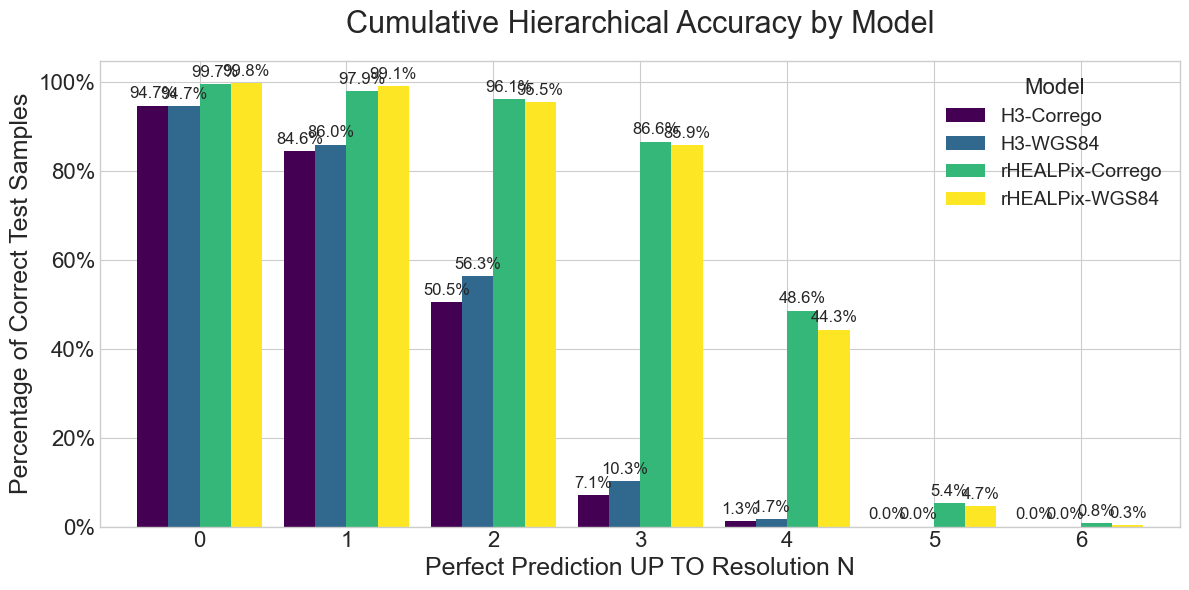



Figure 2: Comparative Plot of Performance by Latitude Band


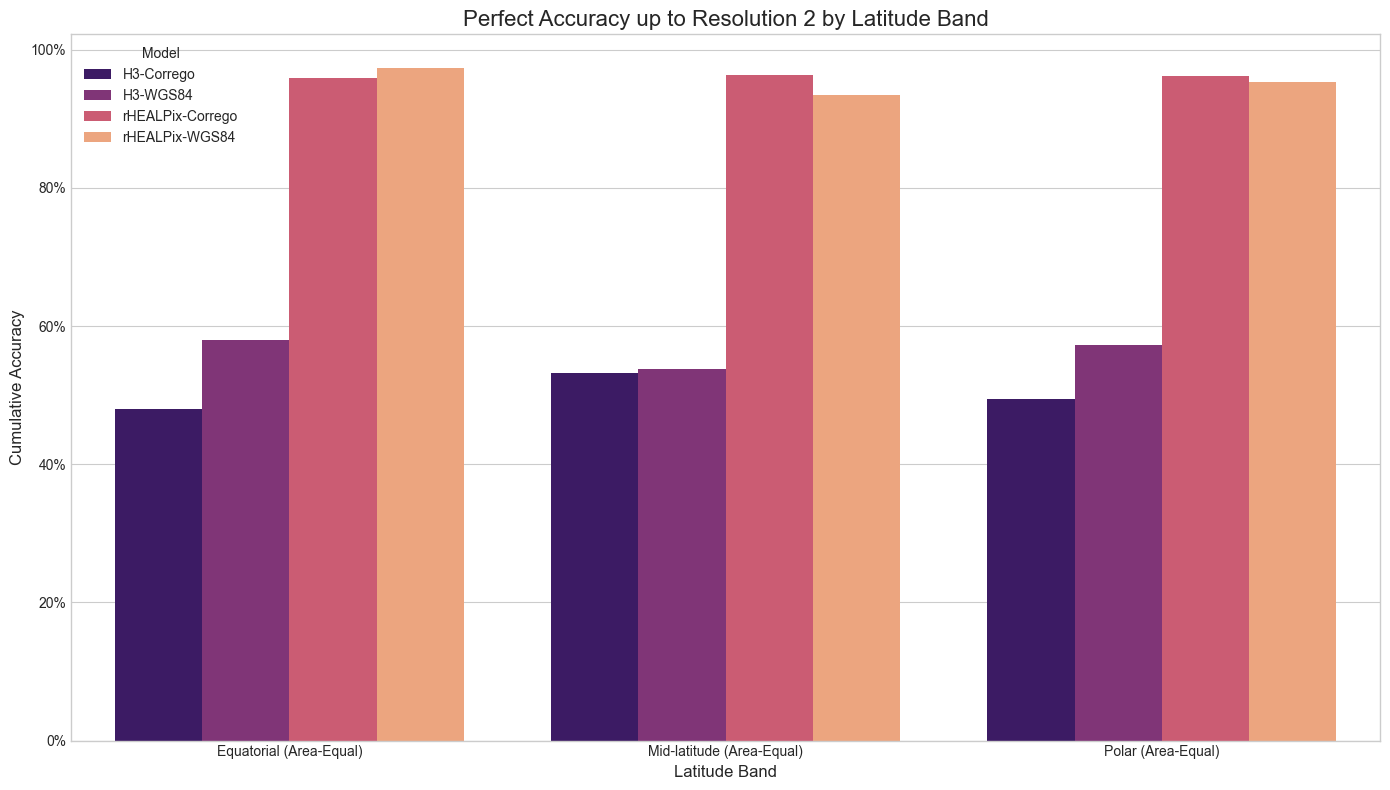

In [134]:
import matplotlib.ticker as mticker # Import para formatação de eixos

def calculate_cumulative_accuracy(series):
    """Função de agregação para calcular a acurácia cumulativa para um grupo."""
    dist = series.value_counts(normalize=True).sort_index()
    # Garante que todos os níveis de resolução (-1 a 15) estejam presentes para um eixo consistente
    dist = dist.reindex(range(-1, 16), fill_value=0)
    cumulative_dist = dist.iloc[::-1].cumsum().iloc[::-1]
    return cumulative_dist

if not all_results_df.empty:
    
    # --- Tabela 1: Resumo Geral de Performance ---
    print("\n" + "="*80)
    print("Table 1: Overall Predictive Performance Summary by Model")
    print("="*80)
    
    # Agregação para a nova tabela resumo
    summary_final = all_results_df.groupby('model')['max_correct_resolution'].agg(
        Base_Cell_Accuracy=lambda s: (s >= 0).mean(),
        Mean_Correct_Resolution=('mean'),
        Median_Correct_Resolution=('median')
    ).reset_index()

    # Formatação dos dados da tabela
    summary_final['Base_Cell_Accuracy'] = summary_final['Base_Cell_Accuracy'].map("{:.2%}".format)
    summary_final['Mean_Correct_Resolution'] = summary_final['Mean_Correct_Resolution'].map("{:.2f}".format)
    summary_final['Median_Correct_Resolution'] = summary_final['Median_Correct_Resolution'].map("{:.0f}".format)
    
    # Renomeia as colunas para inglês
    summary_final.rename(columns={
        'model': 'Model',
        'Base_Cell_Accuracy': 'Base Cell Accuracy',
        'Mean_Correct_Resolution': 'Mean Correct Resolution',
        'Median_Correct_Resolution': 'Median Correct Resolution'
    }, inplace=True)
    
    print(summary_final.to_string(index=False))
    
    
    # --- Tabela 2: Análise Completa por Faixa de Latitude ---
    print("\n\n" + "="*80)
    print("Table 2: Cumulative Hierarchical Accuracy by Latitude Band")
    print("="*80)
    
    # Agregação e pivoteamento dos dados
    accuracy_by_latband = all_results_df.groupby(['model', 'latitude_band'])['max_correct_resolution'].apply(calculate_cumulative_accuracy)
    acc_latband_pivot = accuracy_by_latband.unstack(level=[1,2]).fillna(0).drop(columns=[-1], errors='ignore')
    
    # Remove colunas que contenham apenas zeros
    cols_to_drop_lat = [col for col in acc_latband_pivot.columns if acc_latband_pivot[col].sum() == 0]
    acc_latband_pivot = acc_latband_pivot.drop(columns=cols_to_drop_lat)
    
    print(acc_latband_pivot.to_string(formatters={col: '{:.1%}'.format for col in acc_latband_pivot.columns}))


    # --- Gráfico 1: Visualização Principal (Acurácia Cumulativa Geral) ---
    print("\n\n" + "="*80)
    print("Figure 1: Comparative Plot of Overall Cumulative Accuracy")
    print("="*80)
    
    # Agregação dos dados para o gráfico principal
    overall_cumulative_accuracy = all_results_df.groupby('model')['max_correct_resolution'].apply(calculate_cumulative_accuracy).unstack(level=0)
    # 1. Filtra para manter apenas as resoluções de 0 (acerto base) em diante
    plot_data = overall_cumulative_accuracy.loc[0:]
    # 2. Remove as linhas (resoluções) onde a soma da acurácia de todos os modelos é 0
    plot_data = plot_data[plot_data.sum(axis=1) > 0]
    
    # Configuração do estilo de plotagem
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plota apenas para resoluções de 0 (acerto base) em diante
    plot_data.plot(kind='bar', width=0.85, ax=ax, colormap='viridis')
    
    # Definição dos títulos e rótulos em inglês
    ax.set_title('Cumulative Hierarchical Accuracy by Model', fontsize=22, pad=20)
    ax.set_xlabel('Perfect Prediction UP TO Resolution N', fontsize=18)
    ax.set_ylabel('Percentage of Correct Test Samples', fontsize=18)
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))
    ax.tick_params(axis='both', which='major', labelsize=16, rotation=0) # Aumenta eixos X e Y
    ax.legend(title='Model', fontsize=14, title_fontsize=16)
    
    # Adiciona os valores no topo das barras para clareza
    for container in ax.containers:
        ax.bar_label(container, fmt='{:.1%}', fontsize=12, padding=3) # Aumenta rótulos das barras
        
    plt.tight_layout()
    plt.show()

    # --- Gráfico 2: Visualização de Performance Geográfica ---
    print("\n\n" + "="*80)
    print("Figure 2: Comparative Plot of Performance by Latitude Band")
    print("="*80)
    
    # Define a resolução chave para a análise
    KEY_RESOLUTION = 2
    
    # Prepara os dados para o gráfico de barras agrupado
    lat_band_summary = all_results_df.groupby(['model', 'latitude_band'])['max_correct_resolution'].apply(
        lambda s: (s >= KEY_RESOLUTION).mean() 
    ).reset_index()
    lat_band_summary.rename(columns={'max_correct_resolution': f'Accuracy_until_Res_{KEY_RESOLUTION}'}, inplace=True)
    
    # Cria a figura e os eixos
    fig1, ax1 = plt.subplots(figsize=(14, 8))
    
    # Plota o gráfico de barras agrupadas
    sns.barplot(data=lat_band_summary, x='latitude_band', y=f'Accuracy_until_Res_{KEY_RESOLUTION}', hue='model', ax=ax1, palette='magma')
    
    # Definição dos títulos e rótulos em inglês
    ax1.set_title(f'Perfect Accuracy up to Resolution {KEY_RESOLUTION} by Latitude Band', fontsize=16)
    ax1.set_xlabel('Latitude Band', fontsize=12)
    ax1.set_ylabel('Cumulative Accuracy', fontsize=12)
    ax1.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0)) # Formato de porcentagem
    ax1.legend(title='Model')
    
    plt.tight_layout()
    plt.show()

else:
    # Mensagem de erro caso o DataFrame de resultados esteja vazio
    print("Results DataFrame is empty. No analysis was generated.")

#### Checar o atendimento das resoluções

2025-06-23 23:49:21,026 - INFO - Starting: calculate_fidelity_metrics



--- Processing Model for Fidelity Check: H3-WGS84 ---
Analyzing resolution fidelity for 10000 points...


Analyzing each prediction: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 19923.35it/s]
2025-06-23 23:49:23,202 - INFO - Completed calculate_fidelity_metrics in 2.17 seconds
2025-06-23 23:49:23,272 - INFO - Starting: calculate_fidelity_metrics



--- Processing Model for Fidelity Check: H3-Corrego ---
Analyzing resolution fidelity for 10000 points...


Analyzing each prediction: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 20384.74it/s]
2025-06-23 23:49:25,416 - INFO - Completed calculate_fidelity_metrics in 2.14 seconds
2025-06-23 23:49:25,484 - INFO - Starting: calculate_fidelity_metrics



--- Processing Model for Fidelity Check: rHEALPix-WGS84 ---
Analyzing resolution fidelity for 10000 points...


Analyzing each prediction: 100%|█████████████████████████████████████████████| 10000/10000 [00:00<00:00, 317464.10it/s]
2025-06-23 23:49:27,159 - INFO - Completed calculate_fidelity_metrics in 1.67 seconds
2025-06-23 23:49:27,227 - INFO - Starting: calculate_fidelity_metrics



--- Processing Model for Fidelity Check: rHEALPix-Corrego ---
Analyzing resolution fidelity for 10000 points...


Analyzing each prediction: 100%|█████████████████████████████████████████████| 10000/10000 [00:00<00:00, 317339.20it/s]
2025-06-23 23:49:28,839 - INFO - Completed calculate_fidelity_metrics in 1.61 seconds




Análise de Fidelidade da Resolução (Matrizes de Confusão)


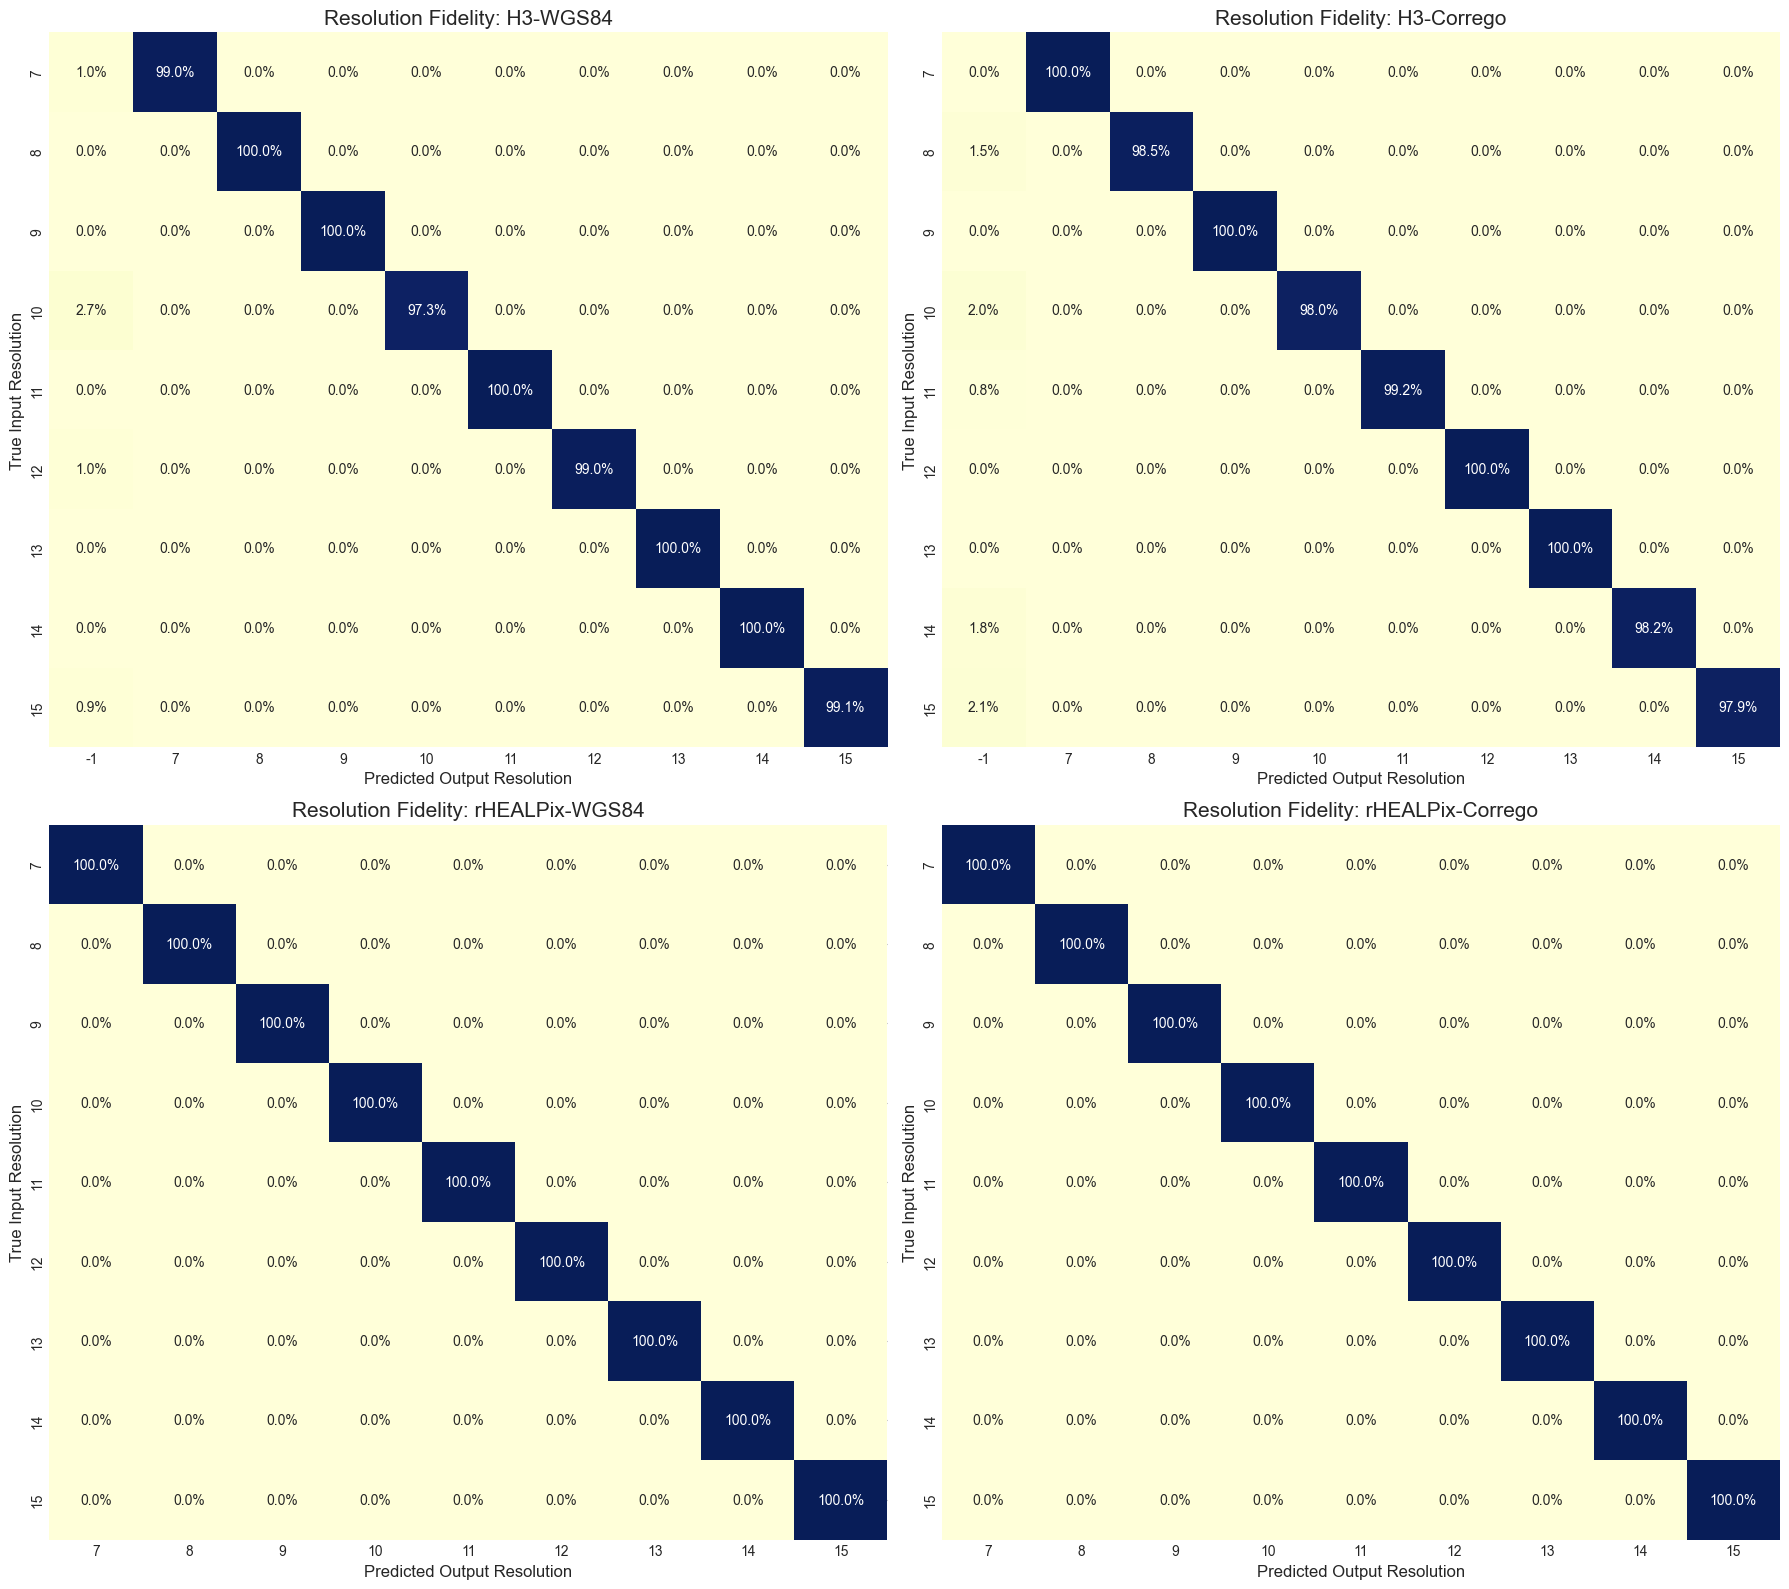

In [125]:
import pandas as pd
import numpy as np
import os
import time
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from rhealpixdggs import dggs as rhealpix_module
import h3 # Necessário para a análise H3

# ==============================================================================
# SEÇÃO 1: FUNÇÃO DE COLETA DE MÉTRICAS ATUALIZADA
# ==============================================================================
# Supondo que as funções auxiliares (get_latitude_band, reconstruct_*, etc.) estão disponíveis.

@log_time_v2
def calculate_fidelity_metrics(model, X_data, y_data, dggs_type):
    """
    Testa um modelo e calcula a resolução de saída para cada predição.
    """
    print(f"Analyzing resolution fidelity for {len(X_data)} points...")
    
    y_pred_dict = model.predict(X_data, verbose=0)
    predicted_components = {key: np.argmax(pred_array, axis=1) for key, pred_array in y_pred_dict.items()}
    
    results = []
    dg_instance_rhp = rhealpix_module.RHEALPixDGGS() if dggs_type.upper() == 'RHEALPIX' else None

    for i in tqdm(range(len(X_data)), desc="Analyzing each prediction"):
        input_res = int(round(X_data[i, -1] * 15.0)) # Extrai a resolução de entrada do vetor X
        
        pred_base = predicted_components['base'][i]
        
        # O número de dígitos previstos é o que define a resolução de saída
        # Para H3 e rHEALPix, o número de dígitos é igual à resolução
        # (considerando res 1 = 1 dígito, etc.)
        # No nosso caso, o modelo sempre gera saídas para todas as resoluções possíveis (até 15)
        # A resolução 'efetiva' da predição é a mesma da entrada, pois usamos 'res' para construir o índice
        predicted_res = input_res

        # Vamos verificar se o índice reconstruído é válido para aquela resolução.
        # Se a reconstrução falhar, podemos considerar a resolução como "inválida" ou -1.
        pred_digits = [predicted_components[f'digit_{d+1}'][i] for d in range(input_res)]
        
        if dggs_type.upper() == 'H3':
            # Para H3, uma forma de verificar é se o índice é válido
            pred_cell_str = reconstruct_h3_index_safe(pred_base, pred_digits, input_res)
            if pred_cell_str is None:
                predicted_res = -1 # A combinação de dígitos foi inválida (ex: pentágono)
        else: # rHEALPix
             # rHEALPix é mais permissivo, a reconstrução raramente falha se os dígitos estiverem no intervalo [0-8]
             pass


        results.append({
            'resolution_input': input_res,
            'resolution_predicted': predicted_res,
        })
        
    return pd.DataFrame(results)


# ==============================================================================
# SEÇÃO 2: EXECUÇÃO E APRESENTAÇÃO
# ==============================================================================

# Supondo que os dicionários `model_paths` e `datasets_for_testing` estão definidos
all_fidelity_results = pd.DataFrame()

for model_name, path in model_paths.items():
    print(f"\n--- Processing Model for Fidelity Check: {model_name} ---")
    try:
        model = keras.models.load_model(path, compile=False)
        X_data, y_data, _, dggs_type = datasets_for_testing[model_name]
        
        # Executa a nova análise de fidelidade
        fidelity_df = calculate_fidelity_metrics(model, X_data, y_data, dggs_type)
        fidelity_df['model'] = model_name # Adiciona o nome do modelo para agrupamento
        
        all_fidelity_results = pd.concat([all_fidelity_results, fidelity_df], ignore_index=True)

    except Exception as e:
        print(f"💥 ERROR processing model {model_name}: {e}")

# --- Geração dos Gráficos de Matriz de Confusão ---

if not all_fidelity_results.empty:
    print("\n\n" + "="*80)
    print("Análise de Fidelidade da Resolução (Matrizes de Confusão)")
    print("="*80)
    
    # Cria um subplot para cada modelo
    fig, axes = plt.subplots(2, 2, figsize=(18, 16))
    axes = axes.flatten() # Transforma a grade 2x2 em uma lista para facilitar a iteração
    
    model_names = all_fidelity_results['model'].unique()
    
    for i, model_name in enumerate(model_names):
        ax = axes[i]
        subset_df = all_fidelity_results[all_fidelity_results['model'] == model_name]
        
        # Cria a matriz de confusão usando o crosstab do pandas
        # normalize='index' mostra as porcentagens por linha
        confusion_matrix = pd.crosstab(
            subset_df['resolution_input'], 
            subset_df['resolution_predicted'],
            normalize='index'
        )
        
        sns.heatmap(confusion_matrix, annot=True, fmt=".1%", cmap="YlGnBu", ax=ax, cbar=False)
        
        ax.set_title(f'Resolution Fidelity: {model_name}', fontsize=15)
        ax.set_xlabel('Predicted Output Resolution', fontsize=12)
        ax.set_ylabel('True Input Resolution', fontsize=12)

    plt.tight_layout()
    plt.show()
else:
    print("No fidelity results were generated.")

## 4. Experimento (novo)

A avaliação da MCR foi conduzida através de dois experimentos em **Delineamento em Blocos Completamente Randomizados (DBCR)**, para cada DGGS, permitindo analisar o impacto de diferentes fatores no desempenho do modelo. A estrutura dos dois experimentos foi a seguinte:

* Fatores Principais: 
    1. Volume de Treinamento (10k, 100k, e 1M de pontos).
    2. Faixa de Latitude (Equatorial, Média e Polar).
* Blocos: O experimento foi bloqueado pela Origem (WGS84 vs. Córrego Alegre).

Essa nova abordagem analítica nos permite sair de uma conclusão de "falha total" para uma caracterização de performance muito mais rica. Ela quantifica a utilidade prática de cada modelo e nos permite avaliar, de forma estatística, como fatores como o sistema DGGS, o volume de dados de treinamento e a localização geográfica impactam a capacidade da rede neural em aprender a complexa estrutura hierárquica dos grids.

### 4.1 Geração da Tabela do Experimento

#### Criação dos dados do experimento

In [63]:
# Quantidade de Pontos
n_points = 100_000

# Geração de fragmentos para WGS84
print('[INFO] Initializing generation of coordinate image fragments for H3 DGGS for WGS84')
dataset_H3_WGS84 = generate_image_points(n_points=n_points, dggs='H3', res_range=(7, 15), crs='WGS84')
print('[INFO] Initializing generation of coordinate image fragments for H3 DGGS for Corrego Alegre')
dataset_H3_Corrego = generate_image_points(n_points=n_points, dggs='H3', res_range=(7, 15), crs='CÓRREGO ALEGRE')
print('[INFO] Initializing generation of coordinate image fragments for rHEALPix DGGS for WGS84')
dataset_rHEALPix_WGS84 = generate_image_points(n_points=n_points, dggs='rHEALPix', res_range=(7, 15), crs='WGS84')
print('[INFO] Initializing generation of coordinate image fragments for rHEALPix DGGS for Corrego Alegre')
dataset_rHEALPix_Corrego = generate_image_points(n_points=n_points, dggs='rHEALPix', res_range=(7, 15), crs='CÓRREGO ALEGRE')

# Construção das entradas para MLP
print('[INFO] Normalizing coordinate image fragments with Fourier Features')
X_H3_WGS84, y_H3_WGS84 = dataset_H3_WGS84.get_X_y('H3')
X_H3_Corrego, y_H3_Corrego = dataset_H3_Corrego.get_X_y('H3')
X_rHEALPix_WGS84, y_rHEALPix_WGS84 = dataset_rHEALPix_WGS84.get_X_y('rHEALPix')
X_rHEALPix_Corrego, y_rHEALPix_Corrego = dataset_rHEALPix_Corrego.get_X_y('rHEALPix')

2025-06-22 23:41:48,484 - INFO - Starting: generate_image_points


[INFO] Initializing generation of coordinate image fragments for H3 DGGS for WGS84


2025-06-22 23:41:49,367 - INFO - Completed generate_image_points in 0.88 seconds
2025-06-22 23:41:49,368 - INFO - Starting: generate_image_points


[INFO] Initializing generation of coordinate image fragments for H3 DGGS for Corrego Alegre


2025-06-22 23:42:10,648 - INFO - Completed generate_image_points in 21.28 seconds
2025-06-22 23:42:10,649 - INFO - Starting: generate_image_points


[INFO] Initializing generation of coordinate image fragments for rHEALPix DGGS for WGS84


2025-06-22 23:42:15,556 - INFO - Completed generate_image_points in 4.91 seconds
2025-06-22 23:42:15,557 - INFO - Starting: generate_image_points


[INFO] Initializing generation of coordinate image fragments for rHEALPix DGGS for Corrego Alegre


2025-06-22 23:42:20,615 - INFO - Completed generate_image_points in 5.06 seconds
2025-06-22 23:42:20,616 - INFO - Starting: build_X_y


[INFO] Normalizing coordinate image fragments with Fourier Features


2025-06-22 23:42:21,202 - INFO - Completed build_X_y in 0.58 seconds
2025-06-22 23:42:21,203 - INFO - Starting: build_X_y
2025-06-22 23:42:21,788 - INFO - Completed build_X_y in 0.58 seconds
2025-06-22 23:42:21,789 - INFO - Starting: build_X_y
2025-06-22 23:42:22,379 - INFO - Completed build_X_y in 0.59 seconds
2025-06-22 23:42:22,380 - INFO - Starting: build_X_y
2025-06-22 23:42:22,946 - INFO - Completed build_X_y in 0.56 seconds


#### Setup e configuração

In [72]:
import pandas as pd
import numpy as np
import os
import time
import tensorflow as tf
from tensorflow import keras

# Supondo que as funções auxiliares (generate_image_points, get_X_y, 
# calculate_hierarchical_metrics, etc.) estão definidas e disponíveis.

# Fatores e Blocos do Experimento
TRAINING_VOLUMES = [10000, 100000, 1000000]
CRS_TYPES = ['WGS84', 'Corrego']
DGGS_TYPES = ['H3', 'rHEALPix']
TEST_SET_SIZE = len(dataset_H3_WGS84.data['H3'])

# Redefine os datasets
datasets_for_experiment = {
    "H3-WGS84": (X_H3_WGS84, y_H3_WGS84, dataset_H3_WGS84, "H3"),
    "H3-Corrego": (X_H3_Corrego, y_H3_Corrego, dataset_H3_Corrego, "H3"),
    "rHEALPix-WGS84": (X_rHEALPix_WGS84, y_rHEALPix_WGS84, dataset_rHEALPix_WGS84, "RHEALPIX"),
    "rHEALPix-Corrego": (X_rHEALPix_Corrego, y_rHEALPix_Corrego, dataset_rHEALPix_Corrego, "RHEALPIX")
}


#### Coleta de amostras

In [73]:
# Lista para armazenar os DataFrames de resultados de cada execução
list_of_results_df = []

print("[INFO] Starting to collect metrics for statistical analysis...")

for volume in TRAINING_VOLUMES:
    # Este laço garante que a variável 'volume' exista e que testaremos
    # os modelos treinados com 10k, 100k e 1M de pontos.

    for dggs in DGGS_TYPES:
        for crs in CRS_TYPES:
            
            # Constrói os nomes do modelo e o caminho do arquivo
            model_label = f"{dggs}-{crs}"
            model_name_full = f"{model_label}_{volume}"
            model_path = f"trained_{model_name_full}.keras"

            print(f"\n[INFO] Processing: Model '{model_name_full}'")

            try:
                # Carrega o modelo treinado
                model = keras.models.load_model(model_path, compile=False)
                
                # --- CORREÇÃO 2: Acesso simplificado e correto aos dados de teste ---
                # Pega o conjunto de teste correspondente do dicionário que já criamos
                # (ex: datasets_for_testing['H3-WGS84'])
                X_data, y_data, original_dataset, dggs_type_check = datasets_for_experiment[model_label]
                
                # Executa a avaliação detalhada
                # A função 'calculate_hierarchical_metrics' foi proposta no passo anterior
                max_correct_res_series = calculate_hierarchical_metrics(model, X_data, y_data)
                
                # Constrói um DataFrame com os resultados detalhados
                temp_df = pd.DataFrame({
                    'training_volume': volume,
                    'crs': crs,
                    'dggs': dggs,
                    'latitude': [d['coord'][0] for d in original_dataset.data[dggs.upper()]],
                    'max_correct_resolution': max_correct_res_series
                })
                temp_df['latitude_band'] = temp_df['latitude'].apply(get_latitude_band)
                
                list_of_results_df.append(temp_df)

            except Exception as e:
                print(f"[ERROR]💥 ERROR processing model {model_path}: {e}")

# Concatena todos os resultados em um único DataFrame mestre
if list_of_results_df:
    master_results_df = pd.concat(list_of_results_df, ignore_index=True)
    print("\n\n[SUCCESS] Detailed metrics collection complete.")
    print(f"[INFO] Total results collected: {len(master_results_df)} data points.")
else:
    master_results_df = pd.DataFrame() # Garante que o dataframe exista mesmo se houver erros
    print("\n\n[WARNING] No results were collected.")

2025-06-23 00:50:55,941 - INFO - Starting: calculate_hierarchical_metrics


[INFO] Starting to collect metrics for statistical analysis...

[INFO] Processing: Model 'H3-WGS84_10000'
Analyzing hierarchical accuracy for 100000 points...


Analyzing each prediction: 100%|██████████████████████████████████████████| 100000/100000 [00:00<00:00, 1747816.01it/s]
2025-06-23 00:51:10,914 - INFO - Completed calculate_hierarchical_metrics in 14.97 seconds
2025-06-23 00:51:11,026 - INFO - Starting: calculate_hierarchical_metrics



[INFO] Processing: Model 'H3-Corrego_10000'
Analyzing hierarchical accuracy for 100000 points...


Analyzing each prediction: 100%|██████████████████████████████████████████| 100000/100000 [00:00<00:00, 1921691.92it/s]
2025-06-23 00:51:25,942 - INFO - Completed calculate_hierarchical_metrics in 14.92 seconds
2025-06-23 00:51:26,053 - INFO - Starting: calculate_hierarchical_metrics



[INFO] Processing: Model 'rHEALPix-WGS84_10000'
Analyzing hierarchical accuracy for 100000 points...


Analyzing each prediction: 100%|██████████████████████████████████████████| 100000/100000 [00:00<00:00, 1261524.49it/s]
2025-06-23 00:51:40,851 - INFO - Completed calculate_hierarchical_metrics in 14.80 seconds
2025-06-23 00:51:40,964 - INFO - Starting: calculate_hierarchical_metrics



[INFO] Processing: Model 'rHEALPix-Corrego_10000'
Analyzing hierarchical accuracy for 100000 points...


Analyzing each prediction: 100%|██████████████████████████████████████████| 100000/100000 [00:00<00:00, 1314268.53it/s]
2025-06-23 00:51:55,677 - INFO - Completed calculate_hierarchical_metrics in 14.71 seconds
2025-06-23 00:51:55,787 - INFO - Starting: calculate_hierarchical_metrics



[INFO] Processing: Model 'H3-WGS84_100000'
Analyzing hierarchical accuracy for 100000 points...


Analyzing each prediction: 100%|██████████████████████████████████████████| 100000/100000 [00:00<00:00, 1480182.38it/s]
2025-06-23 00:52:10,469 - INFO - Completed calculate_hierarchical_metrics in 14.68 seconds
2025-06-23 00:52:10,576 - INFO - Starting: calculate_hierarchical_metrics



[INFO] Processing: Model 'H3-Corrego_100000'
Analyzing hierarchical accuracy for 100000 points...


Analyzing each prediction: 100%|██████████████████████████████████████████| 100000/100000 [00:00<00:00, 1502031.93it/s]
2025-06-23 00:52:25,219 - INFO - Completed calculate_hierarchical_metrics in 14.64 seconds
2025-06-23 00:52:25,328 - INFO - Starting: calculate_hierarchical_metrics



[INFO] Processing: Model 'rHEALPix-WGS84_100000'
Analyzing hierarchical accuracy for 100000 points...


Analyzing each prediction: 100%|██████████████████████████████████████████| 100000/100000 [00:00<00:00, 1066832.17it/s]
2025-06-23 00:52:39,783 - INFO - Completed calculate_hierarchical_metrics in 14.45 seconds
2025-06-23 00:52:39,892 - INFO - Starting: calculate_hierarchical_metrics



[INFO] Processing: Model 'rHEALPix-Corrego_100000'
Analyzing hierarchical accuracy for 100000 points...


Analyzing each prediction: 100%|██████████████████████████████████████████| 100000/100000 [00:00<00:00, 1049342.02it/s]
2025-06-23 00:52:54,352 - INFO - Completed calculate_hierarchical_metrics in 14.46 seconds
2025-06-23 00:52:54,458 - INFO - Starting: calculate_hierarchical_metrics



[INFO] Processing: Model 'H3-WGS84_1000000'
Analyzing hierarchical accuracy for 100000 points...


Analyzing each prediction: 100%|██████████████████████████████████████████| 100000/100000 [00:00<00:00, 1296603.23it/s]
2025-06-23 00:53:09,109 - INFO - Completed calculate_hierarchical_metrics in 14.65 seconds
2025-06-23 00:53:09,216 - INFO - Starting: calculate_hierarchical_metrics



[INFO] Processing: Model 'H3-Corrego_1000000'
Analyzing hierarchical accuracy for 100000 points...


Analyzing each prediction: 100%|██████████████████████████████████████████| 100000/100000 [00:00<00:00, 1238006.46it/s]
2025-06-23 00:53:23,841 - INFO - Completed calculate_hierarchical_metrics in 14.62 seconds
2025-06-23 00:53:23,948 - INFO - Starting: calculate_hierarchical_metrics



[INFO] Processing: Model 'rHEALPix-WGS84_1000000'
Analyzing hierarchical accuracy for 100000 points...


Analyzing each prediction: 100%|███████████████████████████████████████████| 100000/100000 [00:00<00:00, 856200.57it/s]
2025-06-23 00:53:38,347 - INFO - Completed calculate_hierarchical_metrics in 14.40 seconds
2025-06-23 00:53:38,455 - INFO - Starting: calculate_hierarchical_metrics



[INFO] Processing: Model 'rHEALPix-Corrego_1000000'
Analyzing hierarchical accuracy for 100000 points...


Analyzing each prediction: 100%|███████████████████████████████████████████| 100000/100000 [00:00<00:00, 895652.32it/s]
2025-06-23 00:53:52,733 - INFO - Completed calculate_hierarchical_metrics in 14.28 seconds




[SUCCESS] Detailed metrics collection complete.
[INFO] Total results collected: 1200000 data points.


#### Agregação final para a tabela ANOVA

In [74]:
print("\n" + "="*80)
print("[INFO] Final Mean Correct Resolution (MCR) Table for ANOVA")
print("="*80)

# Agrupa por todos os fatores e blocos para calcular a MCR para cada condição
anova_df = master_results_df.groupby([
    'dggs',
    'crs',
    'training_volume',
    'latitude_band'
]).agg(
    MCR=('max_correct_resolution', 'mean')
).reset_index()

# Apresenta a tabela final
# Usando 'display()' se estiver em um notebook para uma melhor formatação
try:
    from IPython.display import display
    display(anova_df)
except ImportError:
    print(anova_df.to_string())

# Salva a tabela em um arquivo CSV para uso em software estatístico
anova_df.to_csv("anova_final_results.csv", index=False)
print("\n[INFO] Table for ANOVA saved in 'anova_final_results.csv'")


[INFO] Final Mean Correct Resolution (MCR) Table for ANOVA


,dggs,crs,training_volume,latitude_band,MCR
0,H3,Corrego,10000,Equatorial (Area-Equal),0.215458
1,H3,Corrego,10000,Mid-latitude (Area-Equal),0.240399
2,H3,Corrego,10000,Polar (Area-Equal),0.181805
3,H3,Corrego,100000,Equatorial (Area-Equal),0.843925
4,H3,Corrego,100000,Mid-latitude (Area-Equal),0.908324
5,H3,Corrego,100000,Polar (Area-Equal),0.873686
6,H3,Corrego,1000000,Equatorial (Area-Equal),1.427100
7,H3,Corrego,1000000,Mid-latitude (Area-Equal),1.485035
8,H3,Corrego,1000000,Polar (Area-Equal),1.472061
9,H3,WGS84,10000,Equatorial (Area-Equal),0.270389



[INFO] Table for ANOVA saved in 'anova_final_results.csv'


### 4.2 Estatística do Experimento

#### Preparação final dos dados

In [77]:
# !pip install statsmodels

In [96]:
import pandas as pd
import io

# backup para anova_df
data = """
dggs,crs,training_volume,latitude_band,MCR
H3,Corrego,10000,Equatorial (Area-Equal),0.215458
H3,Corrego,10000,Mid-latitude (Area-Equal),0.240399
H3,Corrego,10000,Polar (Area-Equal),0.181805
H3,Corrego,100000,Equatorial (Area-Equal),0.843925
H3,Corrego,100000,Mid-latitude (Area-Equal),0.908324
H3,Corrego,100000,Polar (Area-Equal),0.873686
H3,Corrego,1000000,Equatorial (Area-Equal),1.427100
H3,Corrego,1000000,Mid-latitude (Area-Equal),1.485035
H3,Corrego,1000000,Polar (Area-Equal),1.472061
H3,WGS84,10000,Equatorial (Area-Equal),0.270389
H3,WGS84,10000,Mid-latitude (Area-Equal),0.189383
H3,WGS84,10000,Polar (Area-Equal),0.117759
H3,WGS84,100000,Equatorial (Area-Equal),0.861886
H3,WGS84,100000,Mid-latitude (Area-Equal),0.836076
H3,WGS84,100000,Polar (Area-Equal),0.860035
H3,WGS84,1000000,Equatorial (Area-Equal),1.424504
H3,WGS84,1000000,Mid-latitude (Area-Equal),1.453762
H3,WGS84,1000000,Polar (Area-Equal),1.508150
rHEALPix,Corrego,10000,Equatorial (Area-Equal),1.452622
rHEALPix,Corrego,10000,Mid-latitude (Area-Equal),1.402842
rHEALPix,Corrego,10000,Polar (Area-Equal),1.258932
rHEALPix,Corrego,100000,Equatorial (Area-Equal),2.437022
rHEALPix,Corrego,100000,Mid-latitude (Area-Equal),2.409460
rHEALPix,Corrego,100000,Polar (Area-Equal),2.153940
rHEALPix,Corrego,1000000,Equatorial (Area-Equal),3.550140
rHEALPix,Corrego,1000000,Mid-latitude (Area-Equal),3.546261
rHEALPix,Corrego,1000000,Polar (Area-Equal),3.061413
rHEALPix,WGS84,10000,Equatorial (Area-Equal),1.332562
rHEALPix,WGS84,10000,Mid-latitude (Area-Equal),1.411381
rHEALPix,WGS84,10000,Polar (Area-Equal),1.322941
rHEALPix,WGS84,100000,Equatorial (Area-Equal),2.392230
rHEALPix,WGS84,100000,Mid-latitude (Area-Equal),2.410910
rHEALPix,WGS84,100000,Polar (Area-Equal),2.192894
rHEALPix,WGS84,1000000,Equatorial (Area-Equal),3.503559
rHEALPix,WGS84,1000000,Mid-latitude (Area-Equal),3.546425
rHEALPix,WGS84,1000000,Polar (Area-Equal),3.044894
"""

bck_df = pd.read_csv(io.StringIO(data))

bck_df

,dggs,crs,training_volume,latitude_band,MCR
0,H3,Corrego,10000,Equatorial (Area-Equal),0.215458
1,H3,Corrego,10000,Mid-latitude (Area-Equal),0.240399
2,H3,Corrego,10000,Polar (Area-Equal),0.181805
3,H3,Corrego,100000,Equatorial (Area-Equal),0.843925
4,H3,Corrego,100000,Mid-latitude (Area-Equal),0.908324
5,H3,Corrego,100000,Polar (Area-Equal),0.873686
6,H3,Corrego,1000000,Equatorial (Area-Equal),1.427100
7,H3,Corrego,1000000,Mid-latitude (Area-Equal),1.485035
8,H3,Corrego,1000000,Polar (Area-Equal),1.472061
9,H3,WGS84,10000,Equatorial (Area-Equal),0.270389


In [95]:
anova_df

,dggs,crs,training_volume,latitude_band,MCR
0,H3,Corrego,10000,Equatorial (Area-Equal),0.215458
1,H3,Corrego,10000,Mid-latitude (Area-Equal),0.240399
2,H3,Corrego,10000,Polar (Area-Equal),0.181805
3,H3,Corrego,100000,Equatorial (Area-Equal),0.843925
4,H3,Corrego,100000,Mid-latitude (Area-Equal),0.908324
5,H3,Corrego,100000,Polar (Area-Equal),0.873686
6,H3,Corrego,1000000,Equatorial (Area-Equal),1.427100
7,H3,Corrego,1000000,Mid-latitude (Area-Equal),1.485035
8,H3,Corrego,1000000,Polar (Area-Equal),1.472061
9,H3,WGS84,10000,Equatorial (Area-Equal),0.270389


#### Visualização exploratória com boxplot

2025-06-23 03:53:42,421 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-23 03:53:42,424 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-23 03:53:42,446 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-23 03:53:42,448 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



Visualizing MCR Distribution with Boxplots


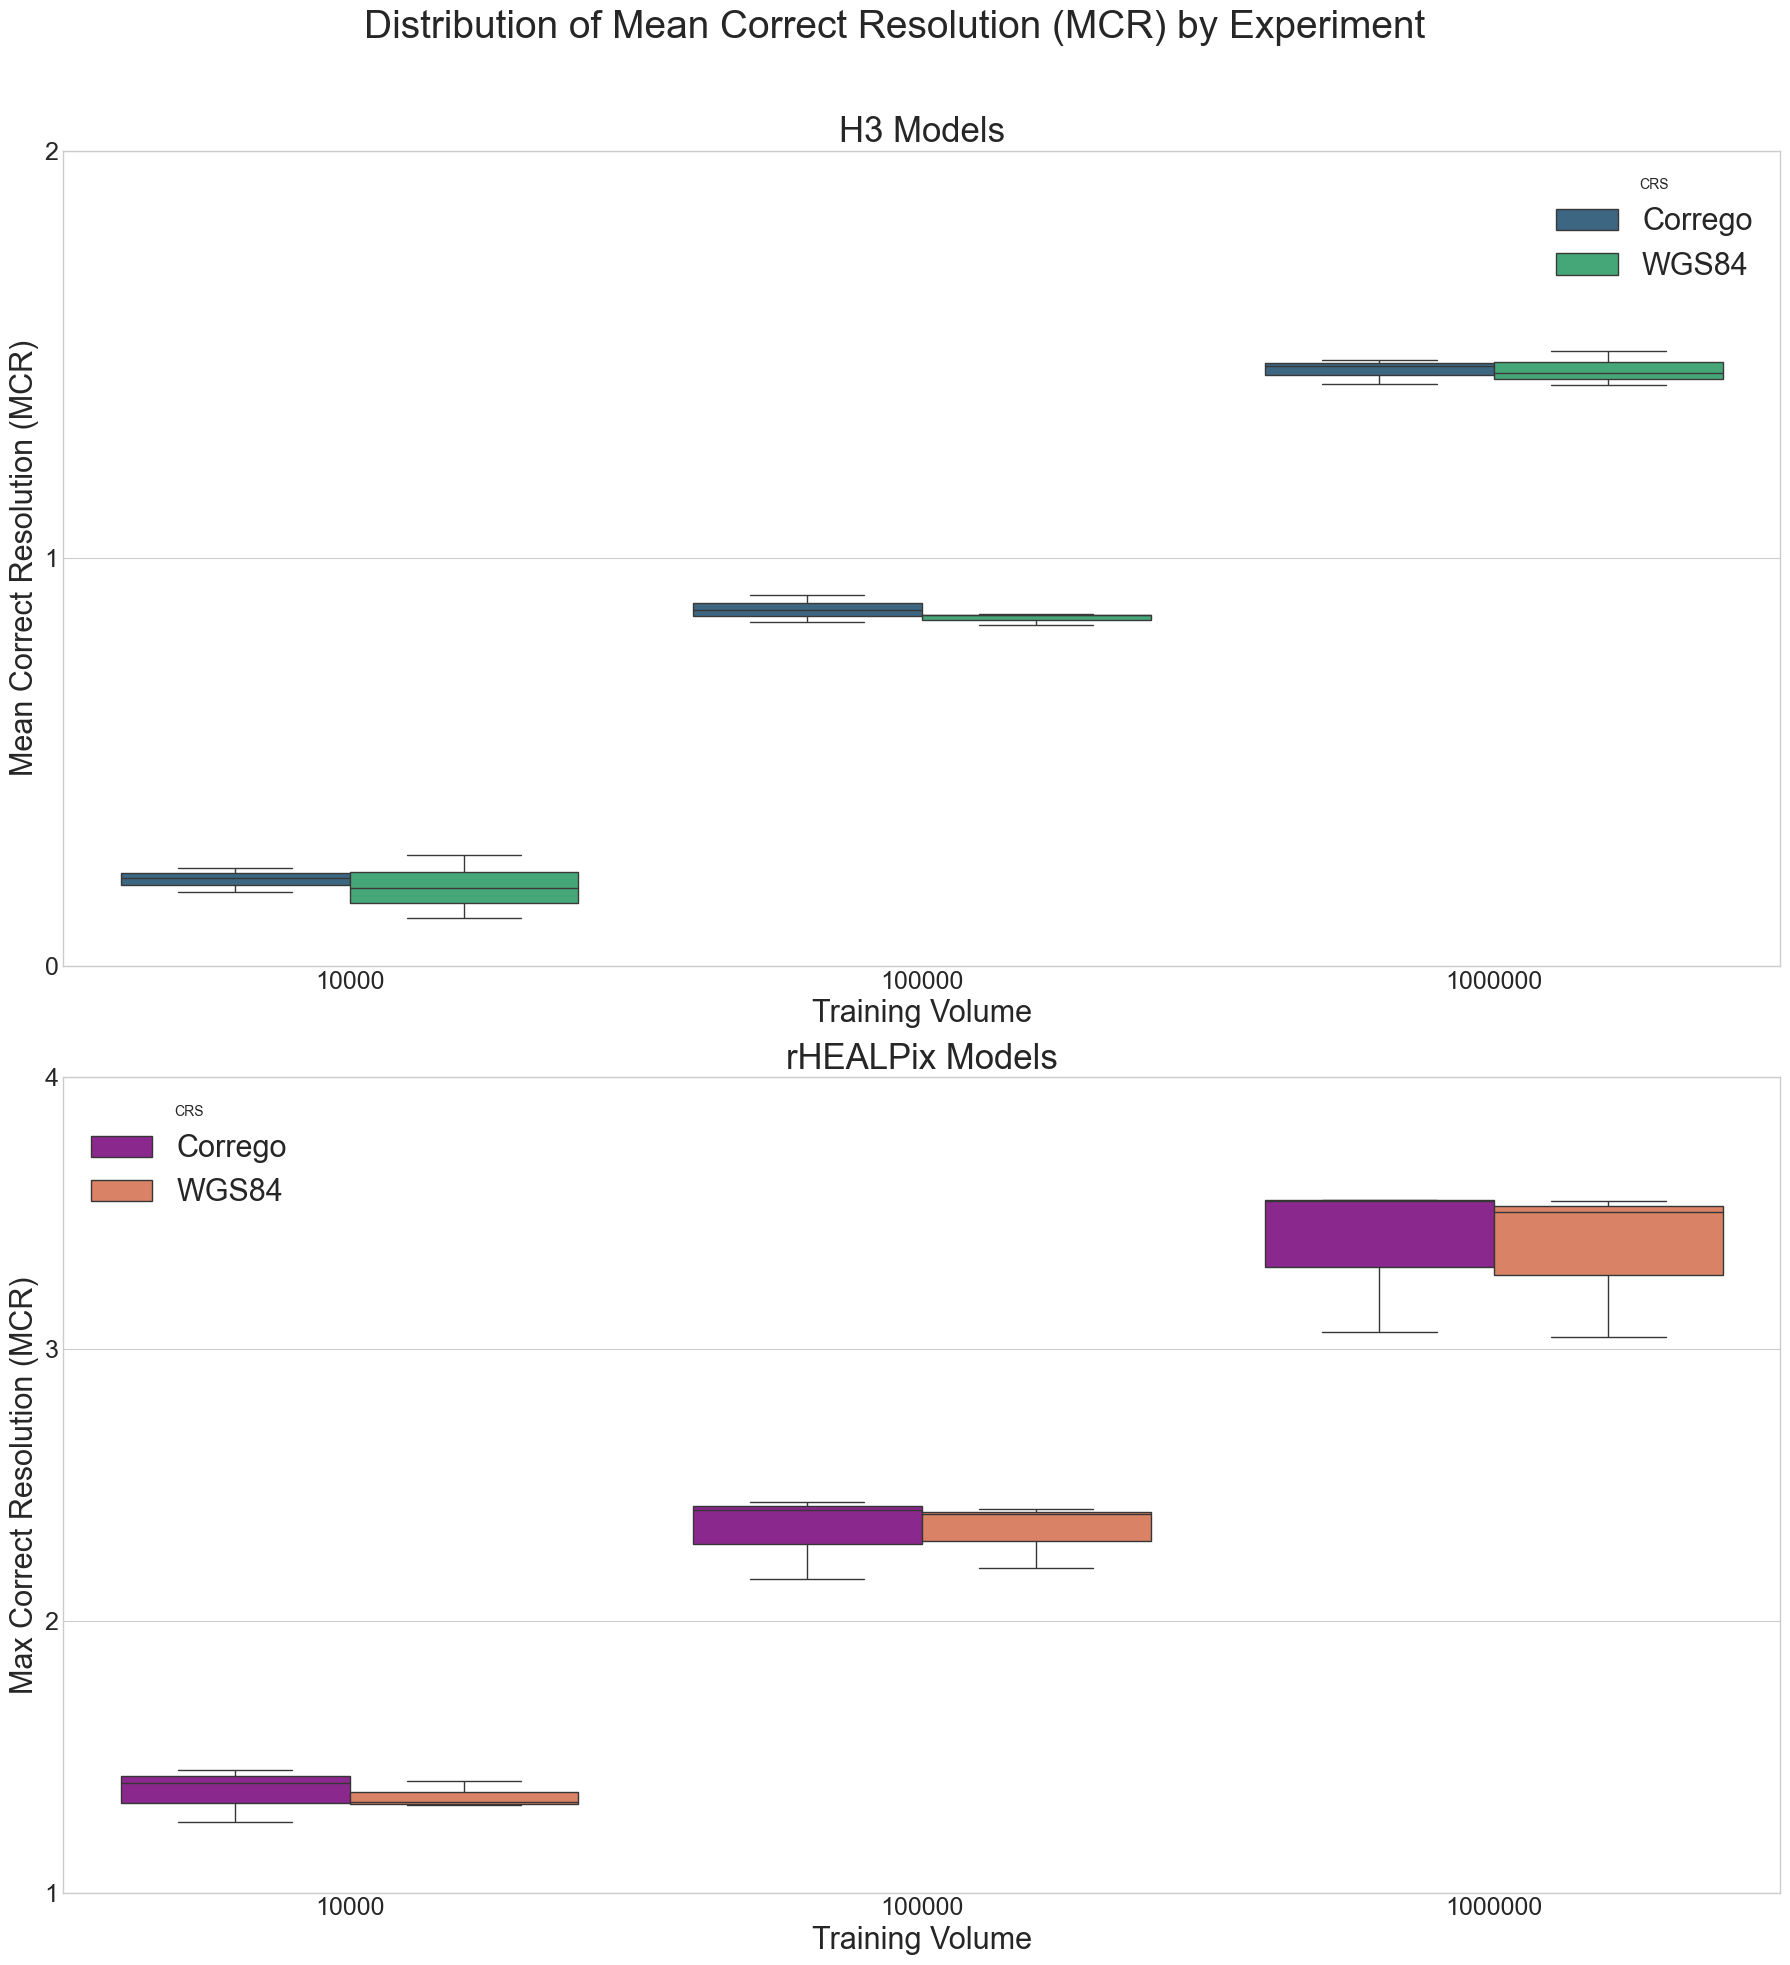

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Supondo que 'anova_df' já foi criado e está disponível.

def plot_mcr_boxplots(df):
    """
    Cria boxplots agrupados para a MCR (mean_correct_resolution)
    separados por sistema DGGS.
    """
    if df.empty:
        print("[WARNING] Results DataFrame is empty. Cannot generate plots.")
        return

    print("\n" + "="*80)
    print("Visualizing MCR Distribution with Boxplots")
    print("="*80)

    # Configura o estilo do gráfico
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Cria uma figura com 2 linhas e 1 coluna.
    # sharey=False permite que cada subplot tenha sua própria escala de eixo Y.
    fig, axes = plt.subplots(2, 1, figsize=(18, 20), sharey=False)
    
    # Título principal da figura
    fig.suptitle('Distribution of Mean Correct Resolution (MCR) by Experiment', fontsize=28)

    # --- Gráfico 1: H3 (Linha Superior) ---
    ax_h3 = axes[0]
    df_h3 = df[df['dggs'] == 'H3']
    
    sns.boxplot(data=df_h3, 
                x='training_volume', 
                y='MCR', 
                hue='crs', 
                ax=ax_h3,
                palette='viridis')
    
    ax_h3.set_title('H3 Models', fontsize=25)
    ax_h3.set_xlabel('Training Volume', fontsize=22)
    ax_h3.set_ylabel('Mean Correct Resolution (MCR)', fontsize=22)
    ax_h3.legend(title='CRS', fontsize=22)
    # Define os limites do eixo y para incluir todas as resoluções possíveis
    ax_h3.set_ylim(0, 2) 
    ax_h3.set_yticks(range(0, 3, 1)) # Marcações de 1 em 1 no eixo y
    ax_h3.tick_params(axis='both', which='major', labelsize=18)

    # --- Gráfico 2: rHEALPix (Linha Inferior) ---
    ax_rhealpix = axes[1]
    df_rhealpix = df[df['dggs'] == 'rHEALPix']
    
    sns.boxplot(data=df_rhealpix, 
                x='training_volume', 
                y='MCR', 
                hue='crs', 
                ax=ax_rhealpix,
                palette='plasma')
                
    ax_rhealpix.set_title('rHEALPix Models', fontsize=25)
    ax_rhealpix.set_xlabel('Training Volume', fontsize=22)
    ax_rhealpix.set_ylabel('Max Correct Resolution (MCR)', fontsize=22)
    ax_rhealpix.legend(title='CRS', fontsize=22)
    ax_rhealpix.set_ylim(1, 4) 
    ax_rhealpix.set_yticks(range(1, 5, 1))
    ax_rhealpix.tick_params(axis='both', which='major', labelsize=18)

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajusta o layout para o título principal
    plt.show()

# --- Execução da Função de Plotagem ---
plot_mcr_boxplots(anova_df)


Visualizing MCR Distribution with Boxplots


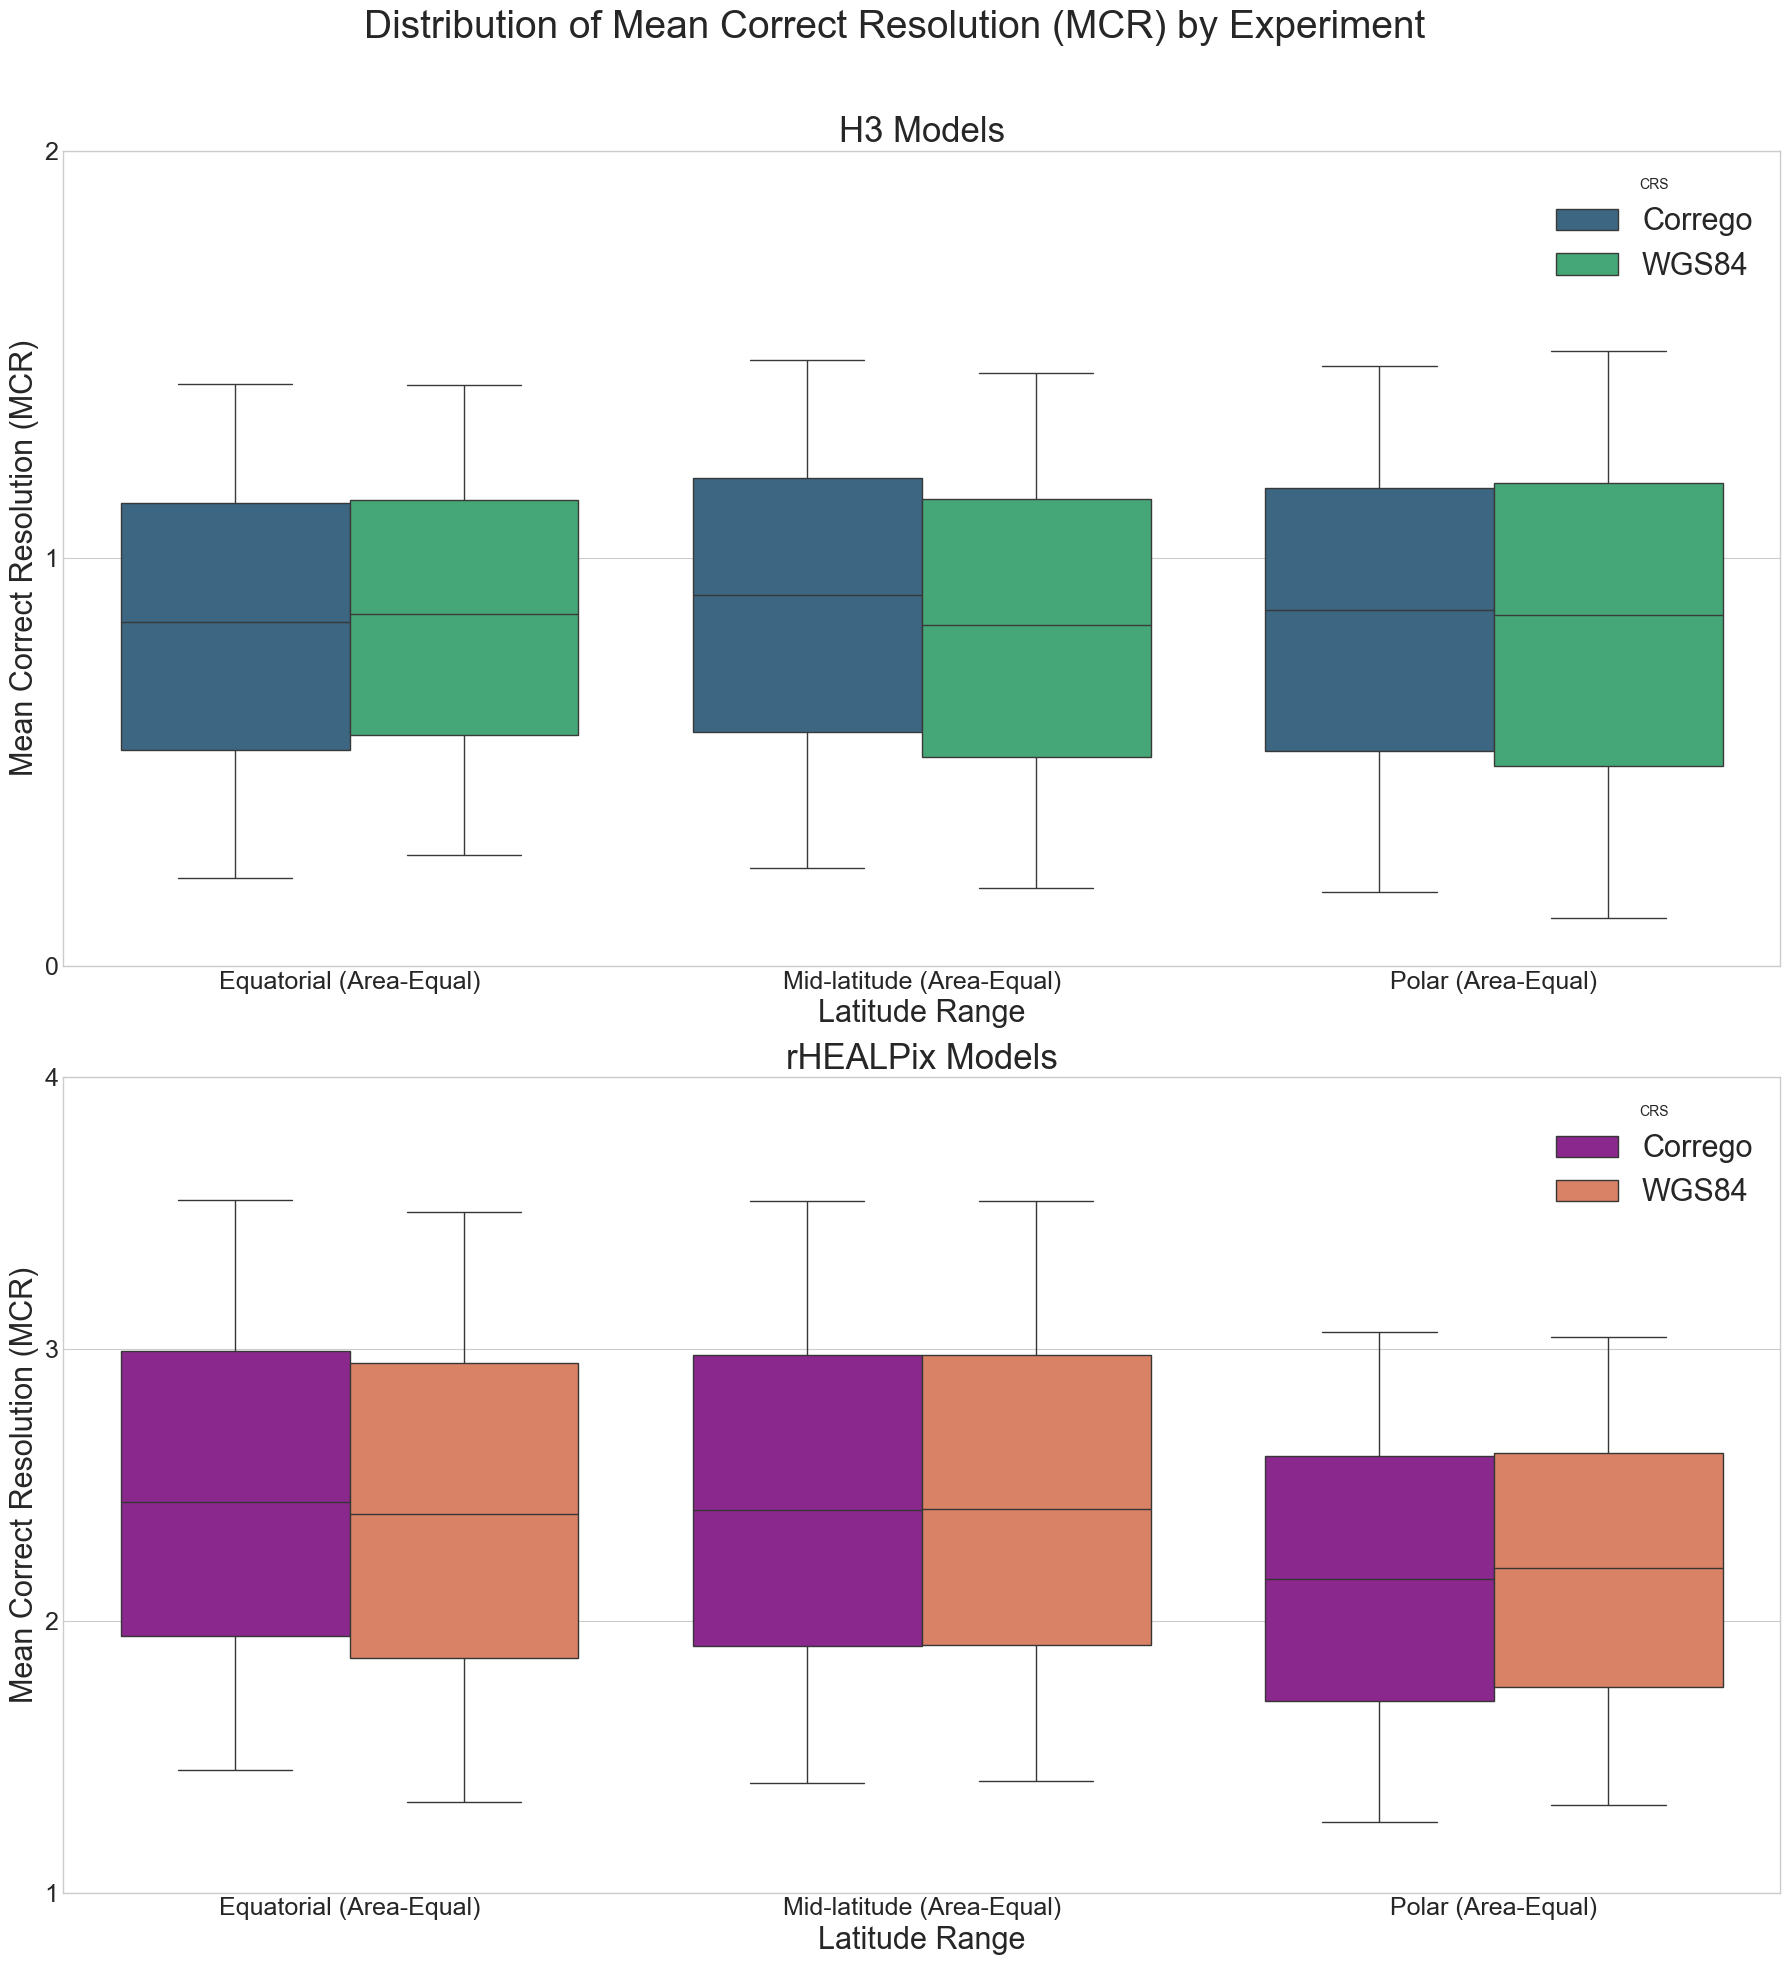

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Supondo que 'anova_df' já foi criado e está disponível.

def plot_mcr_boxplots(df):
    """
    Cria boxplots agrupados para a MCR (mean_correct_resolution)
    separados por sistema DGGS.
    """
    if df.empty:
        print("[WARNING] Results DataFrame is empty. Cannot generate plots.")
        return

    print("\n" + "="*80)
    print("Visualizing MCR Distribution with Boxplots")
    print("="*80)

    # Configura o estilo do gráfico
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Cria uma figura com 2 linhas e 1 coluna.
    # sharey=False permite que cada subplot tenha sua própria escala de eixo Y.
    fig, axes = plt.subplots(2, 1, figsize=(18, 20), sharey=False)
    
    # Título principal da figura
    fig.suptitle('Distribution of Mean Correct Resolution (MCR) by Experiment', fontsize=28)

    # --- Gráfico 1: H3 (Linha Superior) ---
    ax_h3 = axes[0]
    df_h3 = df[df['dggs'] == 'H3']
    
    sns.boxplot(data=df_h3, 
                x='latitude_band', 
                y='MCR', 
                hue='crs', 
                ax=ax_h3,
                palette='viridis')
    
    ax_h3.set_title('H3 Models', fontsize=25)
    ax_h3.set_xlabel('Latitude Range', fontsize=22)
    ax_h3.set_ylabel('Mean Correct Resolution (MCR)', fontsize=22)
    ax_h3.legend(title='CRS', fontsize=22)
    # Define os limites do eixo y para incluir todas as resoluções possíveis
    ax_h3.set_ylim(0, 2) 
    ax_h3.set_yticks(range(0, 3, 1)) # Marcações de 1 em 1 no eixo y
    ax_h3.tick_params(axis='both', which='major', labelsize=18)

    # --- Gráfico 2: rHEALPix (Linha Inferior) ---
    ax_rhealpix = axes[1]
    df_rhealpix = df[df['dggs'] == 'rHEALPix']
    
    sns.boxplot(data=df_rhealpix, 
                x='latitude_band', 
                y='MCR', 
                hue='crs', 
                ax=ax_rhealpix,
                palette='plasma')
                
    ax_rhealpix.set_title('rHEALPix Models', fontsize=25)
    ax_rhealpix.set_xlabel('Latitude Range', fontsize=22)
    ax_rhealpix.set_ylabel('Mean Correct Resolution (MCR)', fontsize=22)
    ax_rhealpix.legend(title='CRS', fontsize=22)
    ax_rhealpix.set_ylim(1, 4) 
    ax_rhealpix.set_yticks(range(1, 5, 1))
    ax_rhealpix.tick_params(axis='both', which='major', labelsize=18)

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajusta o layout para o título principal
    plt.show()

# --- Execução da Função de Plotagem ---
plot_mcr_boxplots(anova_df)

#### ANOVA e testes post-hoc

In [107]:
# Itera sobre cada DGGS como um experimento separado
for dggs_type in anova_df['dggs'].unique():
    
    print("\n\n" + "#"*80)
    print(f"[INFO] Analysis of variance (ANOVA) for the DGGS: {dggs_type}")
    print("#"*80)

    # Filtra o DataFrame para o DGGS atual
    df_experiment = anova_df[anova_df['dggs'] == dggs_type]

    # --- a. Construção e Execução do Modelo ANOVA ---
    
    # A fórmula define MCR como a variável dependente e os outros como fatores.
    # C() trata a variável como Categórica.
    # O '*' inclui os efeitos principais e todas as interações entre eles.
    model_formula = 'MCR ~ C(training_volume) * C(latitude_band) + C(crs)'
    
    # Cria o modelo de regressão por Mínimos Quadrados Ordinários (OLS)
    model = ols(model_formula, data=df_experiment).fit()
    
    # Gera a tabela ANOVA. Usamos typ=2, que é o padrão recomendado para
    # modelos com interações, pois avalia o efeito de cada fator após
    # considerar os outros fatores.
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    print("\n--- ANOVA Table ---")
    print(anova_table)
    
    # --- b. Teste Post-Hoc de Tukey HSD ---
    # A ANOVA nos diz SE um fator é significativo, mas não QUAIS NÍVEIS são diferentes.
    # O teste de Tukey compara todos os pares de níveis para encontrar as diferenças.
    
    print("\n--- Tukey HSD Post-Hoc Test for 'Training Volume' ---")
    
    # Executa o teste para o fator 'training_volume'
    tukey_volume = pairwise_tukeyhsd(endog=df_experiment['MCR'],
                                     groups=df_experiment['training_volume'],
                                     alpha=0.05) # Nível de significância de 5%
    
    print(tukey_volume)

    print("\n--- Tukey HSD Post-Hoc Test for 'Latitude Range' ---")
    
    # Executa o teste para o fator 'latitude_band'
    tukey_latitude = pairwise_tukeyhsd(endog=df_experiment['MCR'],
                                       groups=df_experiment['latitude_band'],
                                       alpha=0.05)
    
    print(tukey_latitude)



################################################################################
[INFO] Analysis of variance (ANOVA) for the DGGS: H3
################################################################################

--- ANOVA Table ---
                                       sum_sq   df            F        PR(>F)
C(training_volume)                   4.761085  2.0  2383.813419  7.874780e-12
C(latitude_band)                     0.000869  2.0     0.435128  6.616302e-01
C(crs)                               0.000880  1.0     0.881117  3.753674e-01
C(training_volume):C(latitude_band)  0.012971  4.0     3.247234  7.335022e-02
Residual                             0.007989  8.0          NaN           NaN

--- Tukey HSD Post-Hoc Test for 'Training Volume' ---
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1  group2 meandiff p-adj lower  upper  reject
--------------------------------------------------
 10000  100000   0.6615   0.0 0.6031 0.7198   True
 10000 1000000   1.2592   0.0 1.20

#### Gráficos de diagnóstico


################################################################################
# Generating ANOVA Diagnostic Plots for DGGS: H3
################################################################################


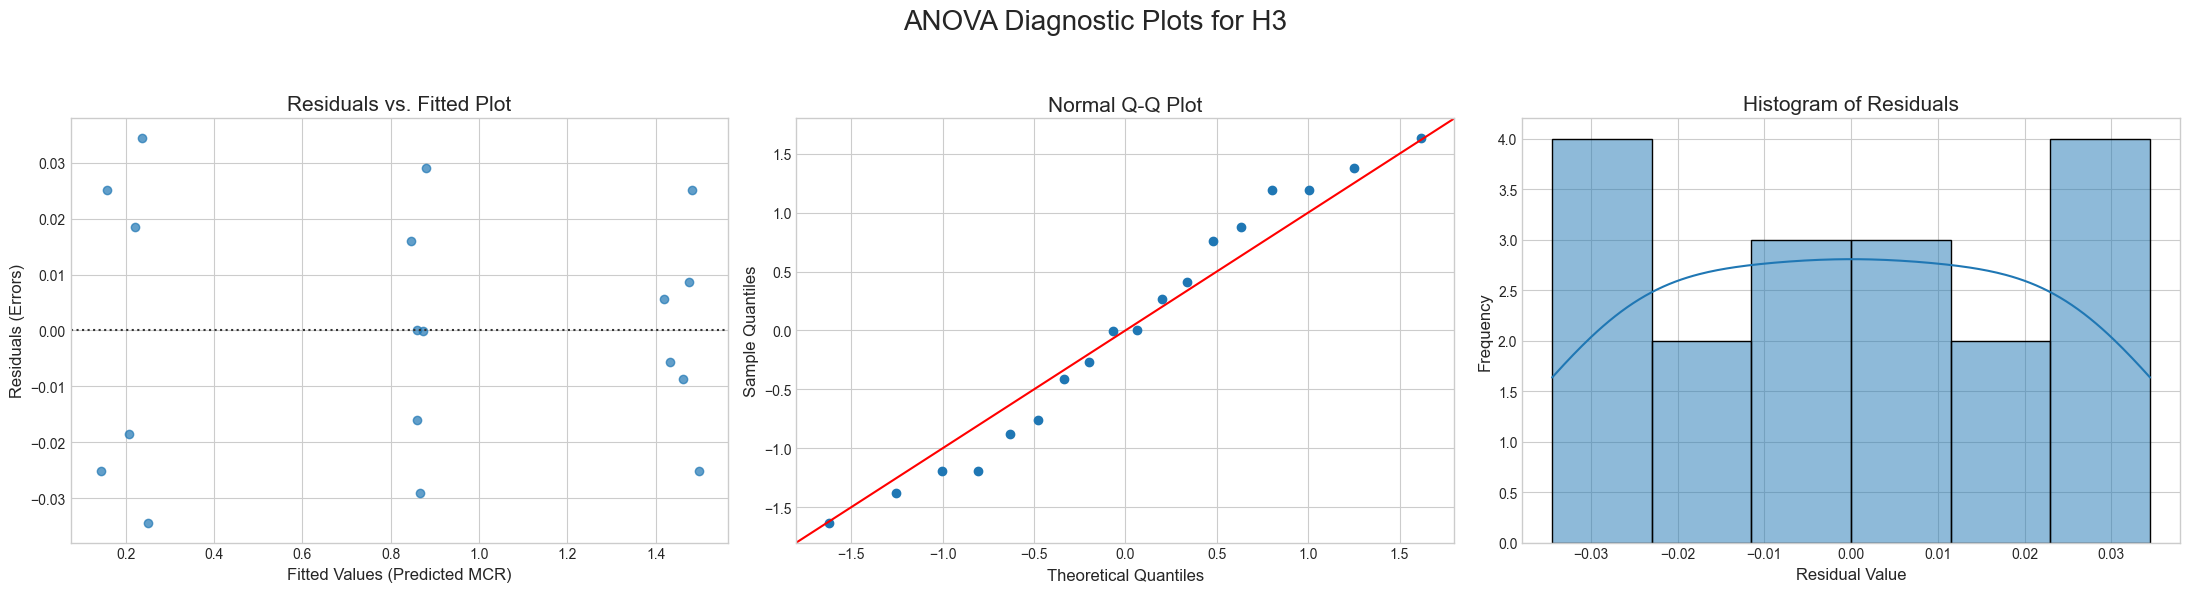


################################################################################
# Generating ANOVA Diagnostic Plots for DGGS: rHEALPix
################################################################################


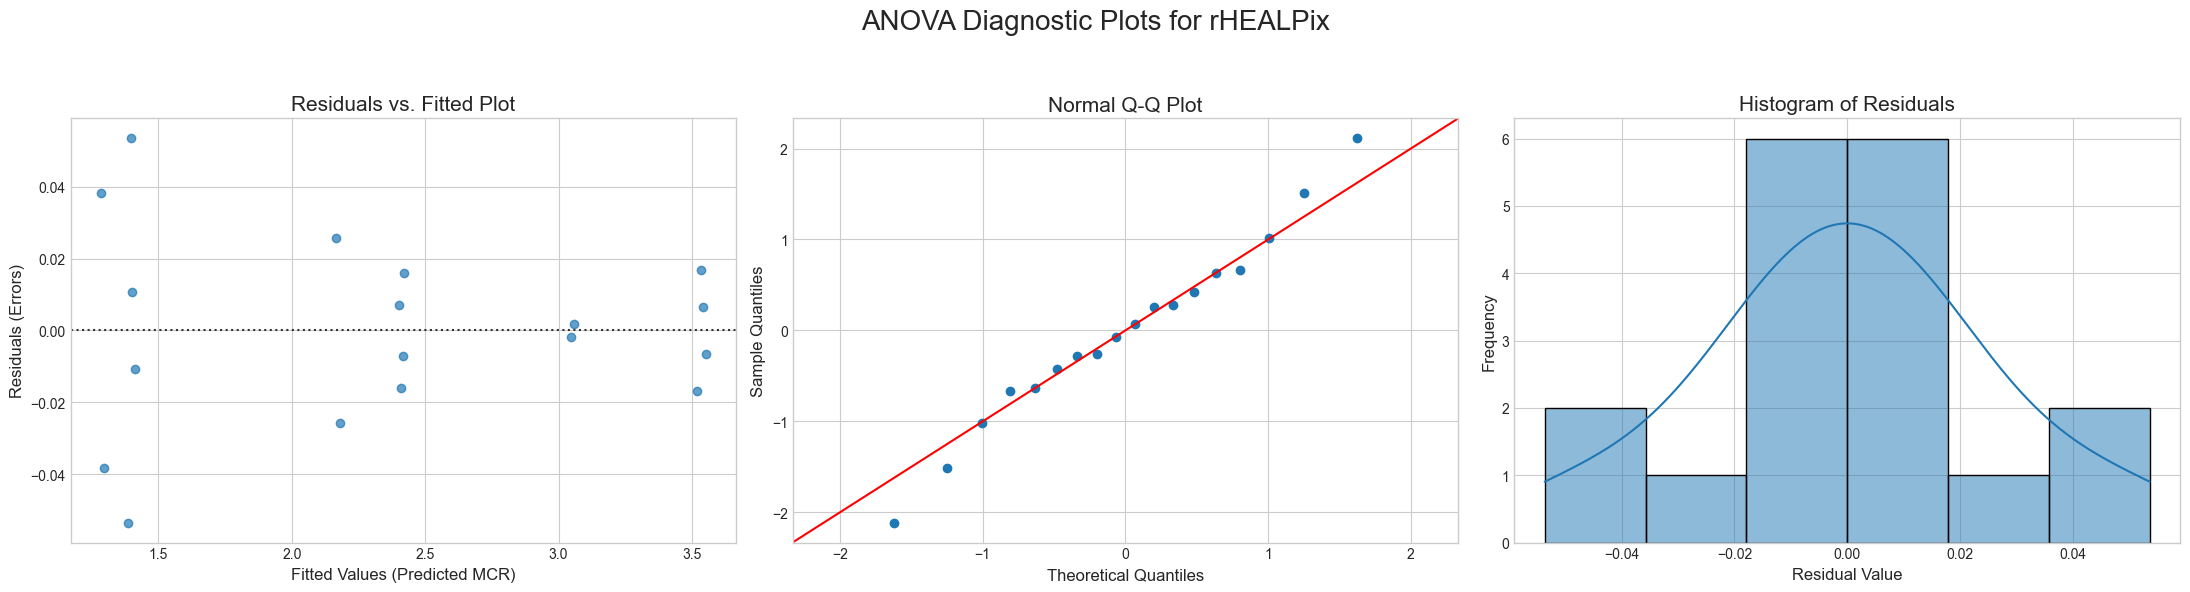

In [110]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns

# Supondo que 'anova_df' já foi criado e está disponível.

def plot_anova_diagnostics(model_fit, title_suffix=""):
    """
    Cria um conjunto de gráficos de diagnóstico para um modelo OLS ajustado.
    Os gráficos ajudam a verificar as suposições do modelo ANOVA.
    
    Args:
        model_fit: O objeto do modelo retornado pela função .fit() do statsmodels.
        title_suffix (str): Um rótulo para adicionar ao título do gráfico.
    """
    # Extrai os resíduos (erros) e os valores previstos (fitted) do modelo
    residuals = model_fit.resid
    fitted_values = model_fit.fittedvalues
    
    # Configura a figura para ter 3 gráficos lado a lado
    fig, axes = plt.subplots(1, 3, figsize=(22, 6))
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # --- Gráfico 1: Resíduos vs. Valores Previstos ---
    # Objetivo: Verificar a constância da variância (homocedasticidade).
    sns.residplot(x=fitted_values, y=residuals, lowess=False, ax=axes[0],
              # A linha de tendência foi desativada, mas podemos manter a formatação do scatter
              scatter_kws={'alpha': 0.7})
    axes[0].set_title('Residuals vs. Fitted Plot', fontsize=15)
    axes[0].set_xlabel('Fitted Values (Predicted MCR)', fontsize=12)
    axes[0].set_ylabel('Residuals (Errors)', fontsize=12)
    
    # --- Gráfico 2: QQ-Plot (Quantile-Quantile) ---
    # Objetivo: Verificar se os resíduos seguem uma distribuição Normal.
    sm.qqplot(residuals, line='45', fit=True, ax=axes[1])
    axes[1].set_title('Normal Q-Q Plot', fontsize=15)
    axes[1].set_xlabel('Theoretical Quantiles', fontsize=12)
    axes[1].set_ylabel('Sample Quantiles', fontsize=12)

    # --- Gráfico 3: Histograma dos Resíduos ---
    # Objetivo: Confirmação visual da distribuição dos resíduos.
    sns.histplot(residuals, kde=True, ax=axes[2])
    axes[2].set_title('Histogram of Residuals', fontsize=15)
    axes[2].set_xlabel('Residual Value', fontsize=12)
    axes[2].set_ylabel('Frequency', fontsize=12)
    
    fig.suptitle(f'ANOVA Diagnostic Plots for {title_suffix}', fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

# Itera sobre cada DGGS como um experimento separado
for dggs_type in anova_df['dggs'].unique():
    
    print("\n" + "#"*80)
    print(f"# Generating ANOVA Diagnostic Plots for DGGS: {dggs_type}")
    print("#"*80)

    # Filtra o DataFrame para o DGGS atual
    df_experiment = anova_df[anova_df['dggs'] == dggs_type]

    # Ajusta novamente o modelo para ter acesso ao objeto 'model_fit' com seus resíduos
    model_formula = 'MCR ~ C(training_volume) * C(latitude_band) + C(crs)'
    fitted_model = ols(model_formula, data=df_experiment).fit()
    
    # Chama a função de plotagem com o modelo ajustado
    plot_anova_diagnostics(fitted_model, title_suffix=dggs_type)